In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# Set display options
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)
pd.set_option('display.float_format', lambda x: '%.3f' % x)

# Set visualization style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
sns.set_style('whitegrid')

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
def missing_data(df):
    """Calculate missing value statistics"""
    total = df.isnull().sum().sort_values(ascending=False)
    percent = (df.isnull().sum() / df.isnull().count() * 100).sort_values(ascending=False)
    return pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])

def plot_default_rate(df, category, figsize=(10, 6), rotation=45):
    """Plot default rate by category"""
    group = df.groupby(category)['TARGET'].mean().sort_values(ascending=False).reset_index()

    plt.figure(figsize=figsize)
    ax = sns.barplot(x=category, y='TARGET', data=group, palette='Reds_r')
    plt.title(f'Default Rate by {category}')
    plt.ylabel('Default Rate')
    plt.xticks(rotation=rotation)

    # Add value labels
    for p in ax.patches:
        ax.annotate(f'{p.get_height():.3f}',
                   (p.get_x() + p.get_width()/2., p.get_height()),
                   ha='center', va='bottom')
    plt.show()
    return group

def assess_data_quality(df, df_name):
    """Comprehensive data quality assessment"""
    print(f"\n{'='*80}")
    print(f"DATA QUALITY ASSESSMENT: {df_name}")
    print(f"{'='*80}")

    # Missing values analysis
    print("\n1. MISSING VALUES ANALYSIS:")
    missing_stats = pd.DataFrame({
        'column': df.columns,
        'missing_count': df.isnull().sum(),
        'missing_percentage': (df.isnull().sum() / len(df)) * 100
    })
    missing_stats = missing_stats[missing_stats['missing_count'] > 0].sort_values('missing_percentage', ascending=False)

    print(f"Total columns with missing values: {len(missing_stats)}")
    print(f"Columns with >30% missing values: {len(missing_stats[missing_stats['missing_percentage'] > 30])}")

    # Duplicate rows
    print(f"\n2. DUPLICATE ROWS: {df.duplicated().sum()}")

    # Data types analysis
    print("\n3. DATA TYPES DISTRIBUTION:")
    dtype_counts = df.dtypes.value_counts()
    for dtype, count in dtype_counts.items():
        print(f"  {dtype}: {count} columns")

    return missing_stats

def plot_categorical_analysis(df, column, target_col='TARGET', top_n=10):
    """Analyze categorical variable relationship with target"""
    if column in df.columns:
        print(f"\n{'='*60}")
        print(f"ANALYSIS OF: {column}")
        print(f"{'='*60}")

        unique_vals = df[column].nunique()
        print(f"Unique values: {unique_vals}")

        if unique_vals <= 20:
            fig, axes = plt.subplots(1, 2, figsize=(14, 5))

            # Count plot
            order = df[column].value_counts().index
            sns.countplot(x=column, data=df, ax=axes[0], order=order)
            axes[0].set_title(f'Distribution of {column}')
            axes[0].tick_params(axis='x', rotation=45)

            # Default rate by category
            default_rate = df.groupby(column)[target_col].mean().sort_values(ascending=False)
            default_rate.plot(kind='bar', ax=axes[1], color='salmon')
            axes[1].set_title(f'Default Rate by {column}')
            axes[1].set_ylabel('Default Rate')
            axes[1].tick_params(axis='x', rotation=45)

            # Add value labels
            for i, v in enumerate(default_rate.values):
                axes[1].text(i, v + 0.01, f'{v:.2%}', ha='center', va='bottom')

            plt.tight_layout()
            plt.show()

            # Display statistics
            stats = df.groupby(column).agg({
                target_col: ['count', 'mean', 'sum']
            }).round(3)
            stats.columns = ['Count', 'Default_Rate', 'Default_Count']
            stats = stats.sort_values('Default_Rate', ascending=False)
            print(f"\nDefault Statistics by {column}:")
            display(stats)

        else:
            print(f"Skipping visualization for {column} (too many unique values: {unique_vals})")

def analyze_continuous_variable(df, col, target_col='TARGET', bins=10):
    """Analyze continuous variable relationship with target"""
    if col in df.columns:
        # Remove outliers for binning (5th and 95th percentiles)
        Q1 = df[col].quantile(0.05)
        Q3 = df[col].quantile(0.95)
        filtered_data = df[(df[col] >= Q1) & (df[col] <= Q3)].copy()

        # Create bins
        filtered_data[f'{col}_bin'] = pd.qcut(filtered_data[col], q=bins, duplicates='drop')

        # Calculate default rate by bin
        default_by_bin = filtered_data.groupby(f'{col}_bin')[target_col].agg(['count', 'mean']).round(3)
        default_by_bin.columns = ['Count', 'Default_Rate']
        default_by_bin['Default_Rate'] = default_by_bin['Default_Rate'] * 100

        print(f"\n{col} - Default Rate by Percentile Bins:")
        display(default_by_bin)

        # Visualize
        fig, axes = plt.subplots(1, 2, figsize=(14, 5))

        # Box plot by target
        sns.boxplot(x=target_col, y=col, data=filtered_data, ax=axes[0])
        axes[0].set_title(f'{col} Distribution by Default Status')
        axes[0].set_xlabel('Default Status (0=No, 1=Yes)')
        axes[0].set_ylabel(col)

        # Default rate by bins
        default_by_bin['Default_Rate'].plot(kind='bar', ax=axes[1], color='salmon')
        axes[1].set_title(f'Default Rate by {col} Bins')
        axes[1].set_xlabel(f'{col} Bins')
        axes[1].set_ylabel('Default Rate (%)')
        axes[1].tick_params(axis='x', rotation=45)

        plt.tight_layout()
        plt.show()

def detect_outliers_iqr(df, columns, multiplier=1.5):
    """Detect outliers using IQR method"""
    outlier_summary = {}

    for col in columns:
        if col in df.columns and df[col].dtype in ['int64', 'float64']:
            Q1 = df[col].quantile(0.25)
            Q3 = df[col].quantile(0.75)
            IQR = Q3 - Q1
            lower_bound = Q1 - multiplier * IQR
            upper_bound = Q3 + multiplier * IQR

            outliers = df[(df[col] < lower_bound) | (df[col] > upper_bound)][col]
            outlier_summary[col] = {
                'count': len(outliers),
                'percentage': len(outliers) / len(df) * 100,
                'lower_bound': lower_bound,
                'upper_bound': upper_bound
            }

    return outlier_summary

In [ ]:
business_problem = """
BUSINESS GOAL:
The finance company needs to minimize loan default risk while maximizing portfolio growth.
We need to identify patterns that predict repayment behavior to enable better credit decisions.

ANALYSIS QUESTIONS:

1. DEMOGRAPHIC FACTORS:
   - How do age, gender, and family status affect default rates?
   - Which education and employment types show higher risk?

2. FINANCIAL FACTORS:
   - What income levels correlate with defaults?
   - How does credit-to-income ratio relate to repayment?
   - Do loan amounts and annuity sizes indicate risk?

3. CREDIT HISTORY:
   - How does previous loan behavior predict current defaults?
   - Do external credit scores reliably indicate risk?

4. BEHAVIORAL SIGNALS:
   - Do document submission patterns matter?
   - Do social circle defaults influence individual risk?

5. RISK SEGMENTATION:
   - What combination of factors best separates defaulters from non-defaulters?
"""

print(business_problem)


BUSINESS GOAL:
The finance company needs to minimize loan default risk while maximizing portfolio growth.
We need to identify patterns that predict repayment behavior to enable better credit decisions.

ANALYSIS QUESTIONS:

1. DEMOGRAPHIC FACTORS:
   - How do age, gender, and family status affect default rates?
   - Which education and employment types show higher risk?

2. FINANCIAL FACTORS:
   - What income levels correlate with defaults?
   - How does credit-to-income ratio relate to repayment?
   - Do loan amounts and annuity sizes indicate risk?

3. CREDIT HISTORY:
   - How does previous loan behavior predict current defaults?
   - Do external credit scores reliably indicate risk?

4. BEHAVIORAL SIGNALS:
   - Do document submission patterns matter?
   - Do social circle defaults influence individual risk?

5. RISK SEGMENTATION:
   - What combination of factors best separates defaulters from non-defaulters?



In [ ]:
try:
    app_data = pd.read_csv('/content/drive/MyDrive/file_zip/application_data.csv')
    prev_app = pd.read_csv('/content/drive/MyDrive/file_zip/previous_application.csv')
    print("Successfully loaded datasets")
except FileNotFoundError as e:
    print(f"Error loading files: {e}")
    print("Please ensure 'application_data.csv' and 'previous_application.csv' are in the working directory")
    # Create empty dataframes for demonstration
    app_data = pd.DataFrame()
    prev_app = pd.DataFrame()
print(f"\nApplication Data Shape: {app_data.shape}")
print(f"Previous Application Shape: {prev_app.shape}")

if not app_data.empty:
    print("\nApplication Data Info:")
    print(app_data.info())

    print("\nFirst few rows:")
    display(app_data.head())

Successfully loaded datasets

Application Data Shape: (307511, 122)
Previous Application Shape: (1670214, 37)

Application Data Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 307511 entries, 0 to 307510
Columns: 122 entries, SK_ID_CURR to AMT_REQ_CREDIT_BUREAU_YEAR
dtypes: float64(65), int64(41), object(16)
memory usage: 286.2+ MB
None

First few rows:


SK_ID_CURR  TARGET NAME_CONTRACT_TYPE CODE_GENDER FLAG_OWN_CAR  \
0      100002       1         Cash loans           M            N   
1      100003       0         Cash loans           F            N   
2      100004       0    Revolving loans           M            Y   
3      100006       0         Cash loans           F            N   
4      100007       0         Cash loans           M            N   

  FLAG_OWN_REALTY  CNT_CHILDREN  AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  \
0               Y             0        202500.000  406597.500    24700.500   
1               N             0        270000.000 1293502.500    35698.500   
2               Y             0         67500.000  135000.000     6750.000   
3               Y             0        135000.000  312682.500    29686.500   
4               Y             0        121500.000  513000.000    21865.500   

   AMT_GOODS_PRICE NAME_TYPE_SUITE NAME_INCOME_TYPE  \
0       351000.000   Unaccompanied          Working   
1      1129500.000          Family    State servant   
2       135000.000   Unaccompanied          Working   
3       297000.000   Unaccompanied          Working   
4       513000.000   Unaccompanied          Working   

             NAME_EDUCATION_TYPE    NAME_FAMILY_STATUS  NAME_HOUSING_TYPE  \
0  Secondary / secondary special  Single / not married  House / apartment   
1               Higher education               Married  House / apartment   
2  Secondary / secondary special  Single / not married  House / apartment   
3  Secondary / secondary special        Civil marriage  House / apartment   
4  Secondary / secondary special  Single / not married  House / apartment   

   REGION_POPULATION_RELATIVE  DAYS_BIRTH  DAYS_EMPLOYED  DAYS_REGISTRATION  \
0                       0.019       -9461           -637          -3648.000   
1                       0.004      -16765          -1188          -1186.000   
2                       0.010      -19046           -225          -4260.000   
3                       0.008      -19005          -3039          -9833.000   
4                       0.029      -19932          -3038          -4311.000   

   DAYS_ID_PUBLISH  OWN_CAR_AGE  FLAG_MOBIL  FLAG_EMP_PHONE  FLAG_WORK_PHONE  \
0            -2120          NaN           1               1                0   
1             -291          NaN           1               1                0   
2            -2531       26.000           1               1                1   
3            -2437          NaN           1               1                0   
4            -3458          NaN           1               1                0   

   FLAG_CONT_MOBILE  FLAG_PHONE  FLAG_EMAIL OCCUPATION_TYPE  CNT_FAM_MEMBERS  \
0                 1           1           0        Laborers            1.000   
1                 1           1           0      Core staff            2.000   
2                 1           1           0        Laborers            1.000   
3                 1           0           0        Laborers            2.000   
4                 1           0           0      Core staff            1.000   

   REGION_RATING_CLIENT  REGION_RATING_CLIENT_W_CITY  \
0                     2                            2   
1                     1                            1   
2                     2                            2   
3                     2                            2   
4                     2                            2   

  WEEKDAY_APPR_PROCESS_START  HOUR_APPR_PROCESS_START  \
0                  WEDNESDAY                       10   
1                     MONDAY                       11   
2                     MONDAY                        9   
3                  WEDNESDAY                       17   
4                   THURSDAY                       11   

   REG_REGION_NOT_LIVE_REGION  REG_REGION_NOT_WORK_REGION  \
0                           0                           0   
1                           0                           0   
2                        


DATA QUALITY ASSESSMENT: Application Data

1. MISSING VALUES ANALYSIS:
Total columns with missing values: 67
Columns with >30% missing values: 50

2. DUPLICATE ROWS: 0

3. DATA TYPES DISTRIBUTION:
  float64: 65 columns
  int64: 41 columns
  object: 16 columns

Top 20 columns with highest missing percentages:


column  missing_count  \
COMMONAREA_MEDI                    COMMONAREA_MEDI         214865   
COMMONAREA_MODE                    COMMONAREA_MODE         214865   
COMMONAREA_AVG                      COMMONAREA_AVG         214865   
NONLIVINGAPARTMENTS_MODE  NONLIVINGAPARTMENTS_MODE         213514   
NONLIVINGAPARTMENTS_MEDI  NONLIVINGAPARTMENTS_MEDI         213514   
NONLIVINGAPARTMENTS_AVG    NONLIVINGAPARTMENTS_AVG         213514   
FONDKAPREMONT_MODE              FONDKAPREMONT_MODE         210295   
LIVINGAPARTMENTS_AVG          LIVINGAPARTMENTS_AVG         210199   
LIVINGAPARTMENTS_MEDI        LIVINGAPARTMENTS_MEDI         210199   
LIVINGAPARTMENTS_MODE        LIVINGAPARTMENTS_MODE         210199   
FLOORSMIN_MEDI                      FLOORSMIN_MEDI         208642   
FLOORSMIN_MODE                      FLOORSMIN_MODE         208642   
FLOORSMIN_AVG                        FLOORSMIN_AVG         208642   
YEARS_BUILD_MODE                  YEARS_BUILD_MODE         204488   
YEARS_BUILD_MEDI                  YEARS_BUILD_MEDI         204488   
YEARS_BUILD_AVG                    YEARS_BUILD_AVG         204488   
OWN_CAR_AGE                            OWN_CAR_AGE         202929   
LANDAREA_AVG                          LANDAREA_AVG         182590   
LANDAREA_MEDI                        LANDAREA_MEDI         182590   
LANDAREA_MODE                        LANDAREA_MODE         182590   

                          missing_percentage  
COMMONAREA_MEDI                       69.872  
COMMONAREA_MODE                       69.872  
COMMONAREA_AVG                        69.872  
NONLIVINGAPARTMENTS_MODE              69.433  
NONLIVINGAPARTMENTS_MEDI              69.433  
NONLIVINGAPARTMENTS_AVG               69.433  
FONDKAPREMONT_MODE                    68.386  
LIVINGAPARTMENTS_AVG                  68.355  
LIVINGAPARTMENTS_MEDI                 68.355  
LIVINGAPARTMENTS_MODE                 68.355  
FLOORSMIN_MEDI                        67.849  
FLOORSMIN_MODE                        67.849  
FLOORSMIN_AVG                         67.849  
YEARS_BUILD_MODE                      66.498  
YEARS_BUILD_MEDI                      66.498  
YEARS_BUILD_AVG                       66.498  
OWN_CAR_AGE                           65.991  
LANDAREA_AVG                          59.377  
LANDAREA_MEDI                         59.377  
LANDAREA_MODE                         59.377

<Figure size 1200x600 with 0 Axes>

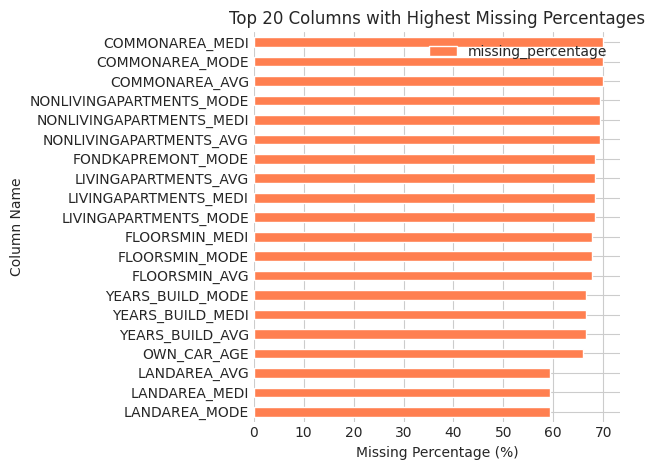


Dropped 49 columns with >40% missing values
New shape: (307511, 73)


In [ ]:
if not app_data.empty:
    missing_app = assess_data_quality(app_data, "Application Data")

    # Display top columns with missing values
    if len(missing_app) > 0:
        print("\nTop 20 columns with highest missing percentages:")
        display(missing_app.head(20))

        # Visualize missing values pattern
        plt.figure(figsize=(12, 6))
        missing_app[missing_app['missing_percentage'] > 0].sort_values('missing_percentage', ascending=False).head(20).plot(
            kind='barh', x='column', y='missing_percentage', color='coral')
        plt.title('Top 20 Columns with Highest Missing Percentages')
        plt.xlabel('Missing Percentage (%)')
        plt.ylabel('Column Name')
        plt.gca().invert_yaxis()
        plt.tight_layout()
        plt.show()

    # Strategy: Drop columns with > 40% missing values
    if 'Percent' in missing_data(app_data).columns:
        cols_to_drop = missing_data(app_data)[missing_data(app_data)['Percent'] > 40].index
        app_data_clean = app_data.drop(columns=cols_to_drop)
        print(f"\nDropped {len(cols_to_drop)} columns with >40% missing values")
        print(f"New shape: {app_data_clean.shape}")
    else:
        app_data_clean = app_data.copy()
else:
    app_data_clean = app_data

Target Distribution:
0 (No payment difficulties): 282,686 (91.93%)
1 (Payment difficulties): 24,825 (8.07%)


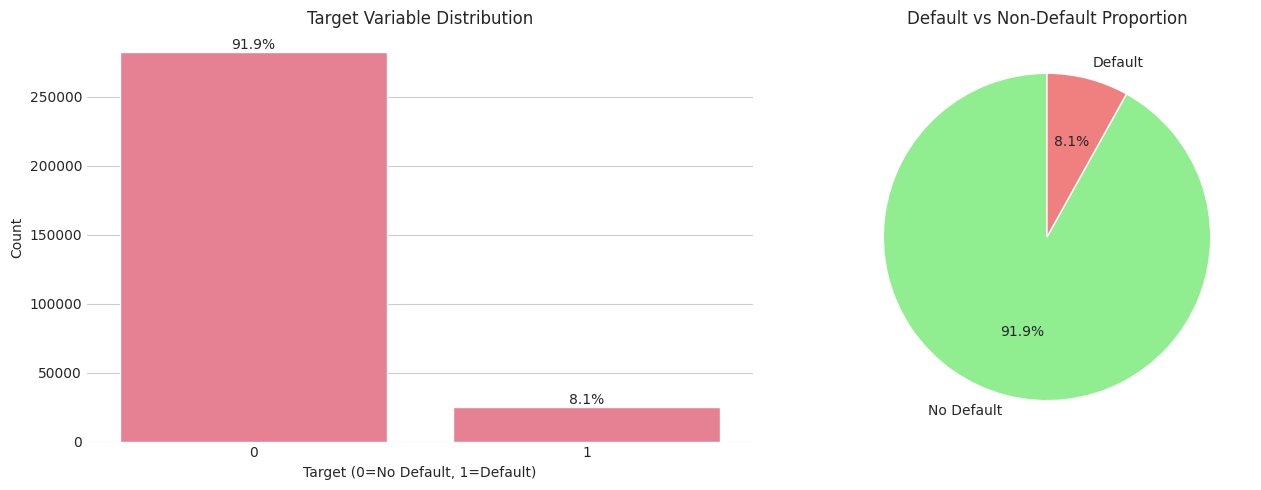


Class Imbalance Ratio (Non-default:Default): 11.39:1
This is a highly imbalanced dataset!


In [ ]:
if not app_data.empty and 'TARGET' in app_data.columns:
    target_dist = app_data['TARGET'].value_counts()
    target_percentage = app_data['TARGET'].value_counts(normalize=True) * 100

    print(f"Target Distribution:")
    print(f"0 (No payment difficulties): {target_dist.get(0, 0):,} ({target_percentage.get(0, 0):.2f}%)")
    print(f"1 (Payment difficulties): {target_dist.get(1, 0):,} ({target_percentage.get(1, 0):.2f}%)")

    # Visualize target distribution
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))

    # Count plot
    sns.countplot(x='TARGET', data=app_data, ax=axes[0])
    axes[0].set_title('Target Variable Distribution')
    axes[0].set_xlabel('Target (0=No Default, 1=Default)')
    axes[0].set_ylabel('Count')

    # Add percentage labels
    total = len(app_data)
    for p in axes[0].patches:
        percentage = f'{100 * p.get_height() / total:.1f}%'
        axes[0].text(p.get_x() + p.get_width() / 2, p.get_height(),
                    percentage, ha='center', va='bottom')

    # Pie chart
    axes[1].pie(target_dist.values, labels=['No Default', 'Default'],
                autopct='%1.1f%%', startangle=90, colors=['lightgreen', 'lightcoral'])
    axes[1].set_title('Default vs Non-Default Proportion')

    plt.tight_layout()
    plt.show()

    # Calculate class imbalance
    imbalance_ratio = target_dist.get(0, 0) / max(target_dist.get(1, 1), 1)
    print(f"\nClass Imbalance Ratio (Non-default:Default): {imbalance_ratio:.2f}:1")
    print("This is a highly imbalanced dataset!")

In [ ]:
if not app_data_clean.empty:
    # Convert days to years for better interpretation
    # Age in years (DAYS_BIRTH is negative, so we take absolute value)
    app_data_clean['AGE'] = abs(app_data_clean['DAYS_BIRTH']) / 365.25

    # Employment years (handle anomaly 365243 days = 1000 years)
    app_data_clean['EMPLOYMENT_YEARS'] = app_data_clean['DAYS_EMPLOYED'].apply(
        lambda x: np.nan if x == 365243 else abs(min(x, 0)) / 365.25
    )
    app_data_clean['EMPLOYMENT_ANOMALY'] = (app_data_clean['DAYS_EMPLOYED'] == 365243).astype(int)

    print(f"Number of employment anomalies (365243 days): {app_data_clean['EMPLOYMENT_ANOMALY'].sum()}")
    print(f"Percentage: {(app_data_clean['EMPLOYMENT_ANOMALY'].sum() / len(app_data_clean)) * 100:.2f}%")

    # Create financial ratios
    if all(col in app_data_clean.columns for col in ['AMT_CREDIT', 'AMT_INCOME_TOTAL', 'AMT_ANNUITY']):
        app_data_clean['CREDIT_INCOME_RATIO'] = app_data_clean['AMT_CREDIT'] / app_data_clean['AMT_INCOME_TOTAL']
        app_data_clean['ANNUITY_INCOME_RATIO'] = app_data_clean['AMT_ANNUITY'] / app_data_clean['AMT_INCOME_TOTAL']
        app_data_clean['ANNUITY_CREDIT_RATIO'] = app_data_clean['AMT_ANNUITY'] / app_data_clean['AMT_CREDIT']

    # Social circle default rates
    if all(col in app_data_clean.columns for col in ['DEF_30_CNT_SOCIAL_CIRCLE', 'OBS_30_CNT_SOCIAL_CIRCLE']):
        app_data_clean['SOCIAL_30_DEFAULT_RATE'] = app_data_clean['DEF_30_CNT_SOCIAL_CIRCLE'] / app_data_clean['OBS_30_CNT_SOCIAL_CIRCLE'].replace(0, np.nan)

    print("\nCreated derived features:")
    print("  - AGE (years)")
    print("  - EMPLOYMENT_YEARS (years)")
    print("  - EMPLOYMENT_ANOMALY flag")
    print("  - CREDIT_INCOME_RATIO")
    print("  - ANNUITY_INCOME_RATIO")
    print("  - SOCIAL_30_DEFAULT_RATE")

Number of employment anomalies (365243 days): 55374
Percentage: 18.01%

Created derived features:
  - AGE (years)
  - EMPLOYMENT_YEARS (years)
  - EMPLOYMENT_ANOMALY flag
  - CREDIT_INCOME_RATIO
  - ANNUITY_INCOME_RATIO
  - SOCIAL_30_DEFAULT_RATE


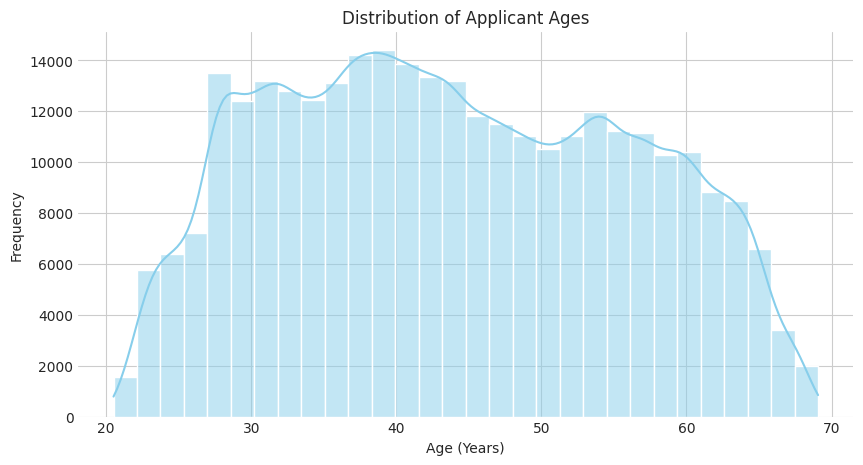

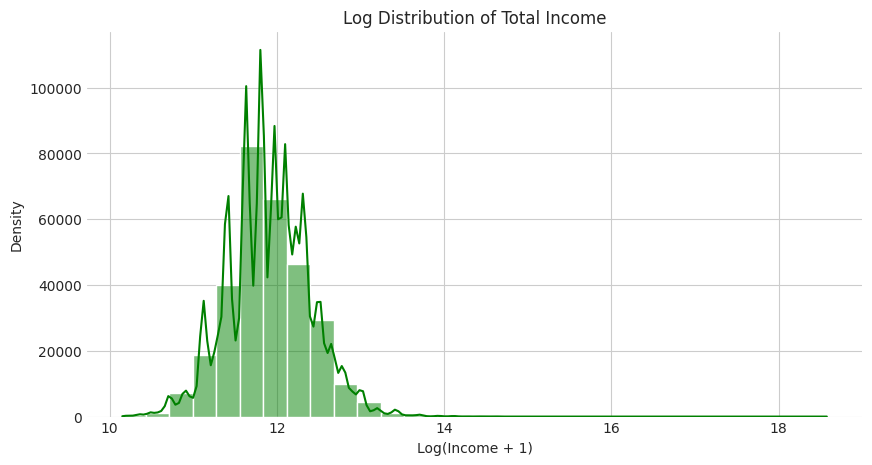

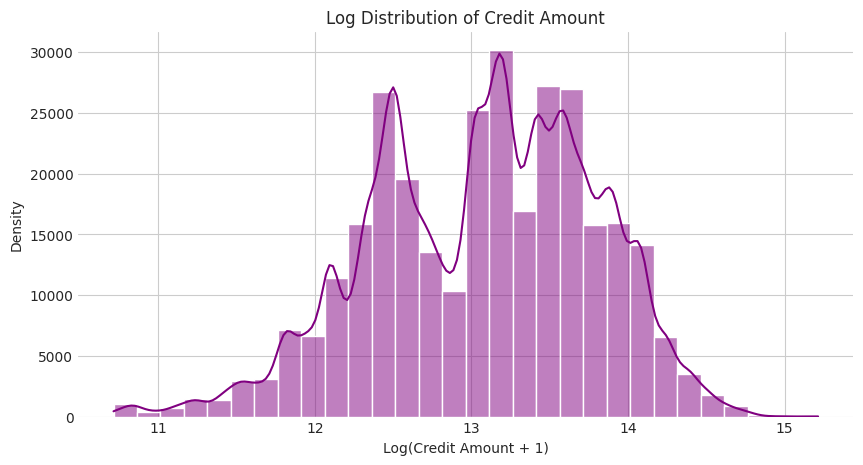

In [ ]:
if not app_data_clean.empty:
    # 1. Age Distribution
    plt.figure(figsize=(10,5))
    sns.histplot(app_data_clean['AGE'].dropna(), bins=30, kde=True, color='skyblue')
    plt.title('Distribution of Applicant Ages')
    plt.xlabel('Age (Years)')
    plt.ylabel('Frequency')
    plt.show()

    # 2. Income Distribution (Log scale for better visualization)
    if 'AMT_INCOME_TOTAL' in app_data_clean.columns:
        plt.figure(figsize=(10,5))
        sns.histplot(np.log1p(app_data_clean['AMT_INCOME_TOTAL']), kde=True, color='green', bins=30)
        plt.title('Log Distribution of Total Income')
        plt.xlabel('Log(Income + 1)')
        plt.ylabel('Density')
        plt.show()

    # 3. Credit Amount Distribution
    if 'AMT_CREDIT' in app_data_clean.columns:
        plt.figure(figsize=(10,5))
        sns.histplot(np.log1p(app_data_clean['AMT_CREDIT']), kde=True, color='purple', bins=30)
        plt.title('Log Distribution of Credit Amount')
        plt.xlabel('Log(Credit Amount + 1)')
        plt.ylabel('Density')
        plt.show()


ANALYSIS OF: CODE_GENDER
Unique values: 3


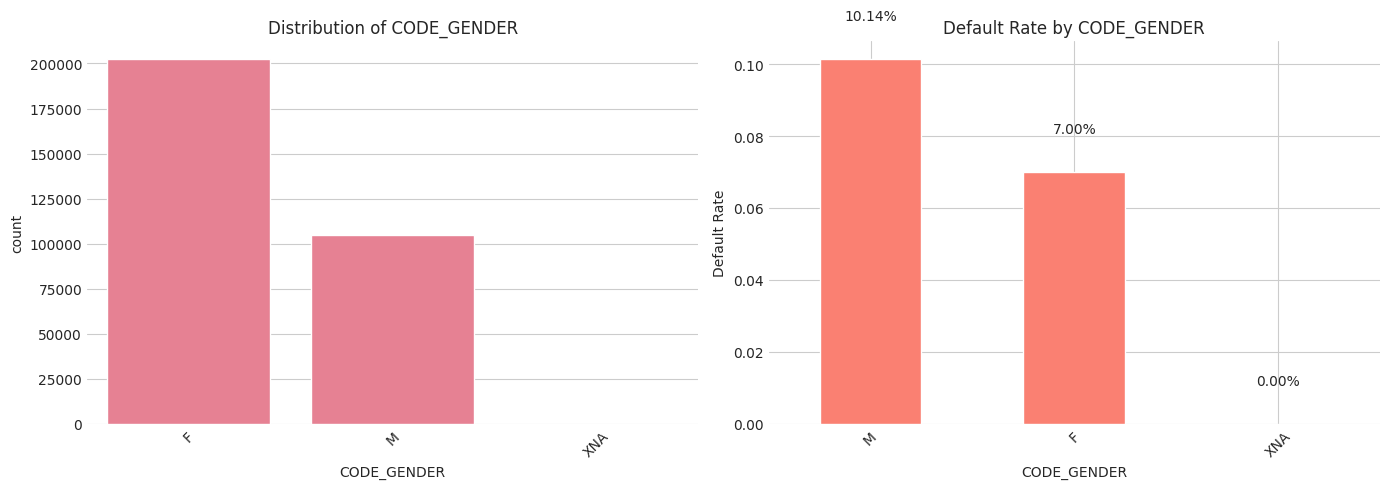


Default Statistics by CODE_GENDER:


Count  Default_Rate  Default_Count
CODE_GENDER                                     
M            105059         0.101          10655
F            202448         0.070          14170
XNA               4         0.000              0


ANALYSIS OF: FLAG_OWN_CAR
Unique values: 2


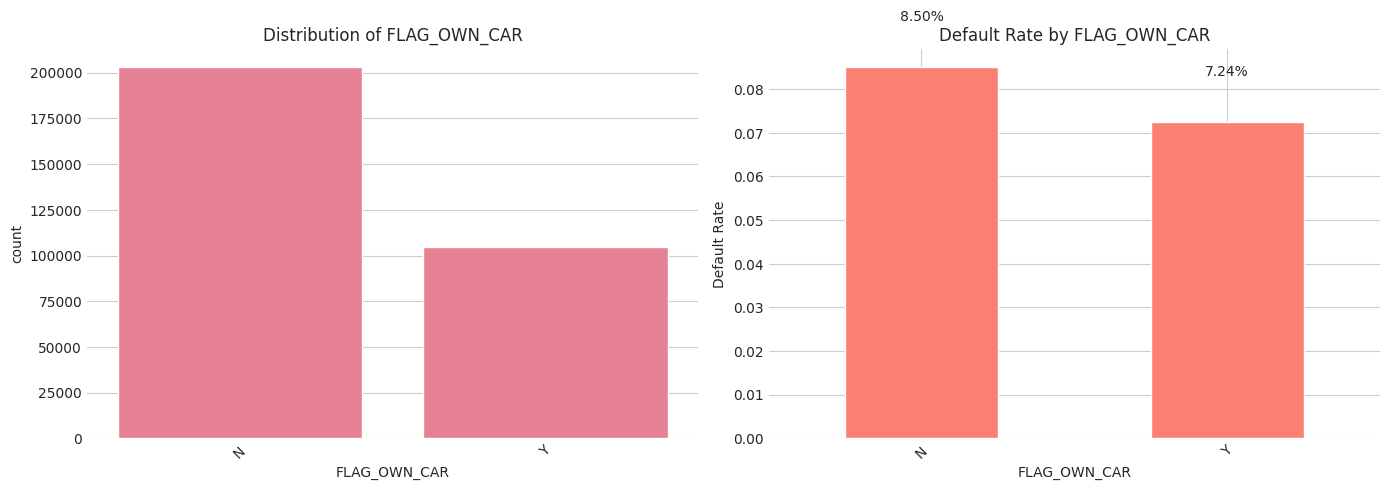


Default Statistics by FLAG_OWN_CAR:


Count  Default_Rate  Default_Count
FLAG_OWN_CAR                                     
N             202924         0.085          17249
Y             104587         0.072           7576


ANALYSIS OF: FLAG_OWN_REALTY
Unique values: 2


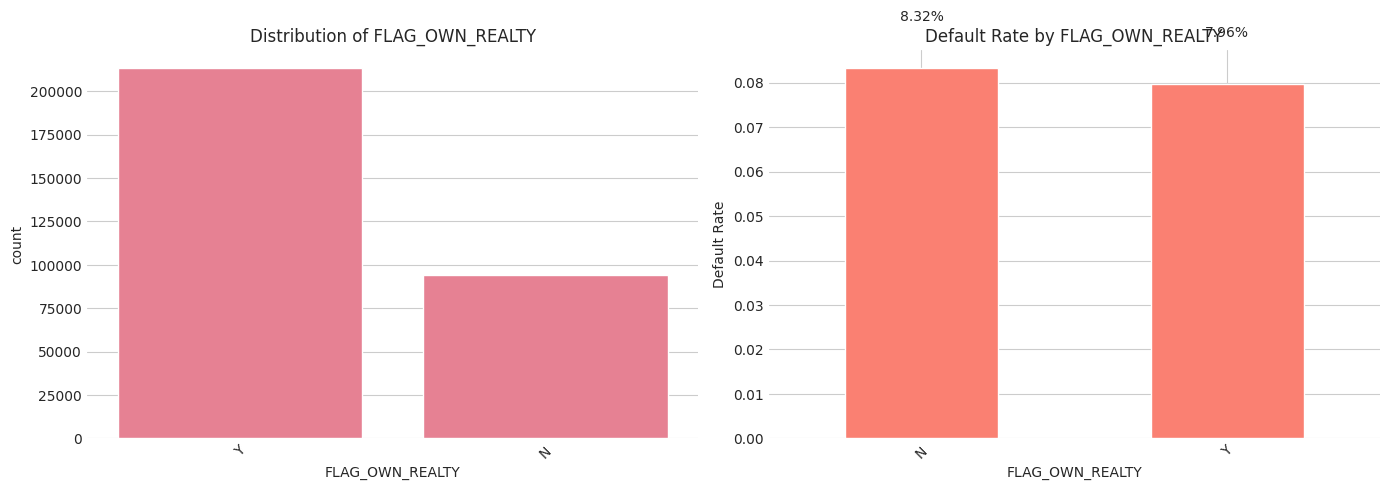


Default Statistics by FLAG_OWN_REALTY:


Count  Default_Rate  Default_Count
FLAG_OWN_REALTY                                     
N                 94199         0.083           7842
Y                213312         0.080          16983


ANALYSIS OF: NAME_INCOME_TYPE
Unique values: 8


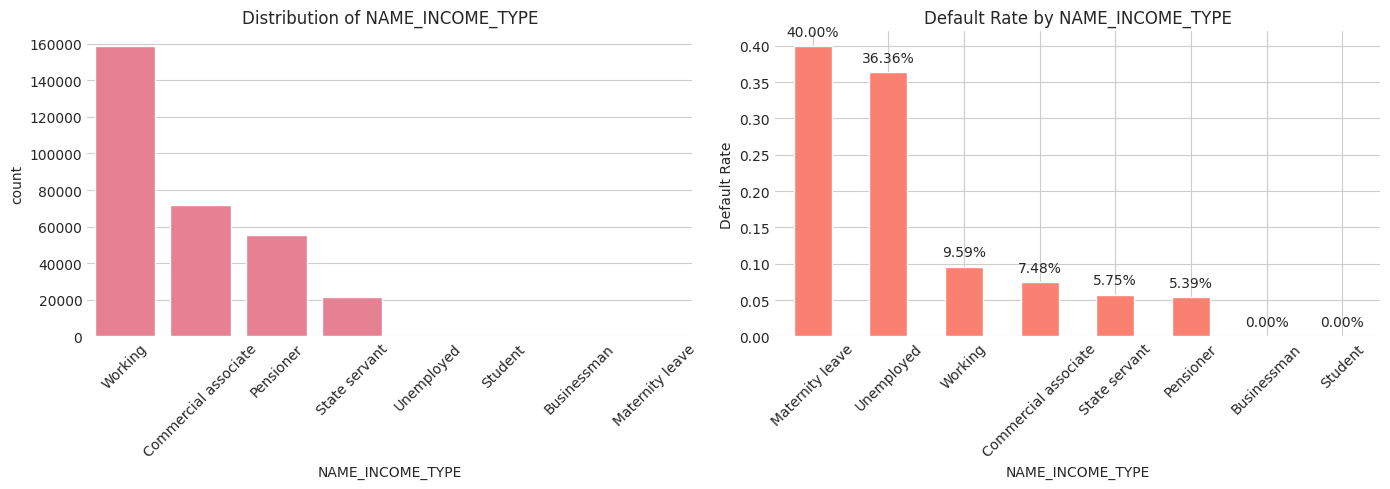


Default Statistics by NAME_INCOME_TYPE:


Count  Default_Rate  Default_Count
NAME_INCOME_TYPE                                         
Maternity leave            5         0.400              2
Unemployed                22         0.364              8
Working               158774         0.096          15224
Commercial associate   71617         0.075           5360
State servant          21703         0.058           1249
Pensioner              55362         0.054           2982
Businessman               10         0.000              0
Student                   18         0.000              0


ANALYSIS OF: NAME_EDUCATION_TYPE
Unique values: 5


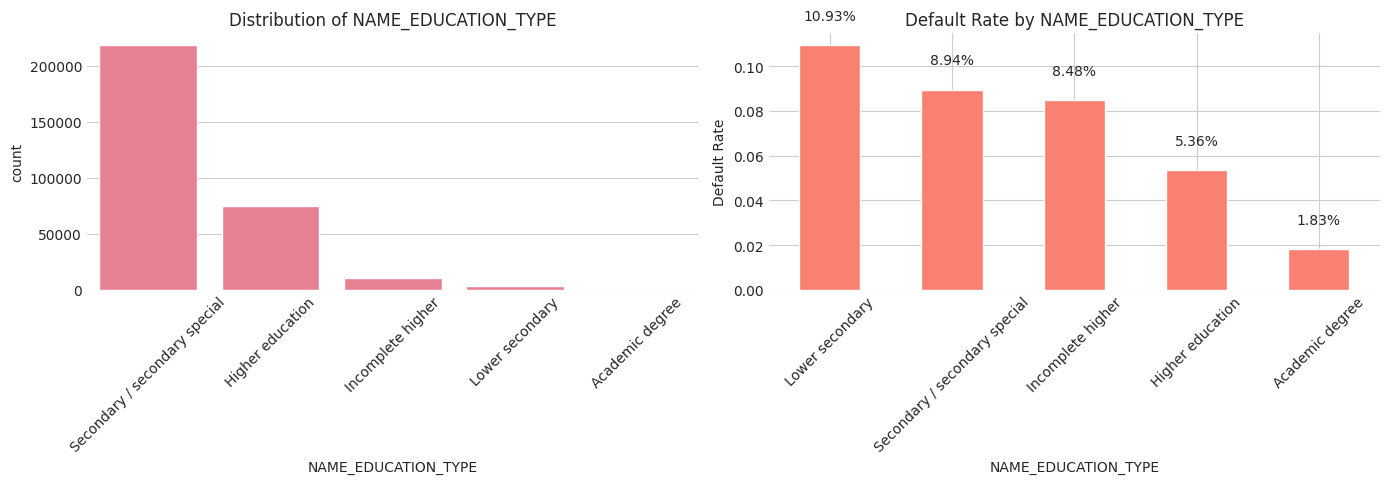


Default Statistics by NAME_EDUCATION_TYPE:


Count  Default_Rate  Default_Count
NAME_EDUCATION_TYPE                                               
Lower secondary                  3816         0.109            417
Secondary / secondary special  218391         0.089          19524
Incomplete higher               10277         0.085            872
Higher education                74863         0.054           4009
Academic degree                   164         0.018              3


ANALYSIS OF: NAME_FAMILY_STATUS
Unique values: 6


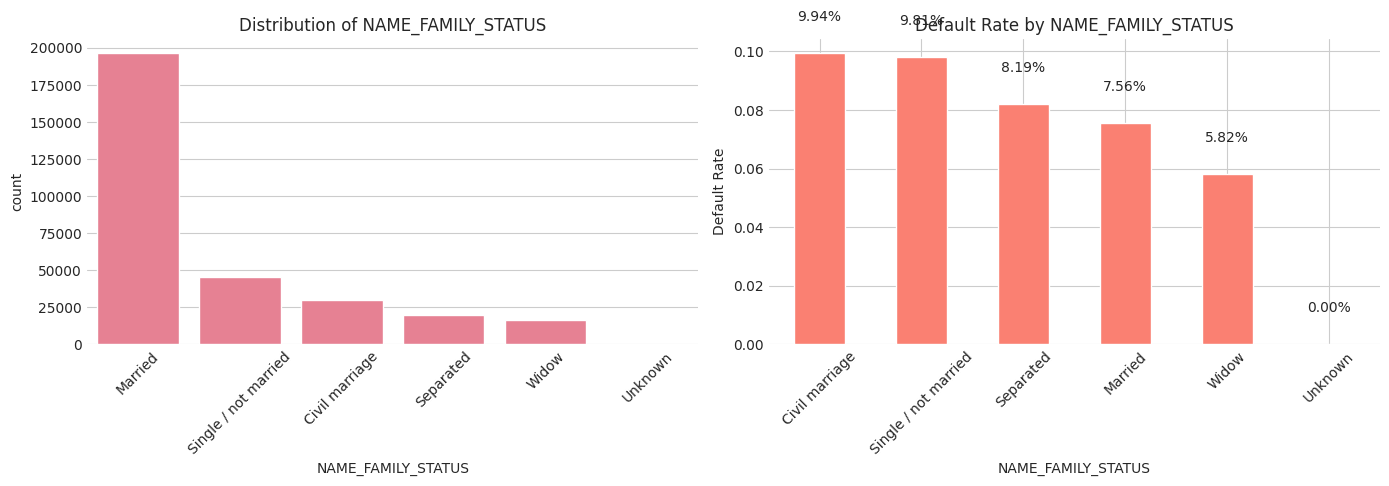


Default Statistics by NAME_FAMILY_STATUS:


Count  Default_Rate  Default_Count
NAME_FAMILY_STATUS                                       
Civil marriage         29775         0.099           2961
Single / not married   45444         0.098           4457
Separated              19770         0.082           1620
Married               196432         0.076          14850
Widow                  16088         0.058            937
Unknown                    2         0.000              0


ANALYSIS OF: NAME_HOUSING_TYPE
Unique values: 6


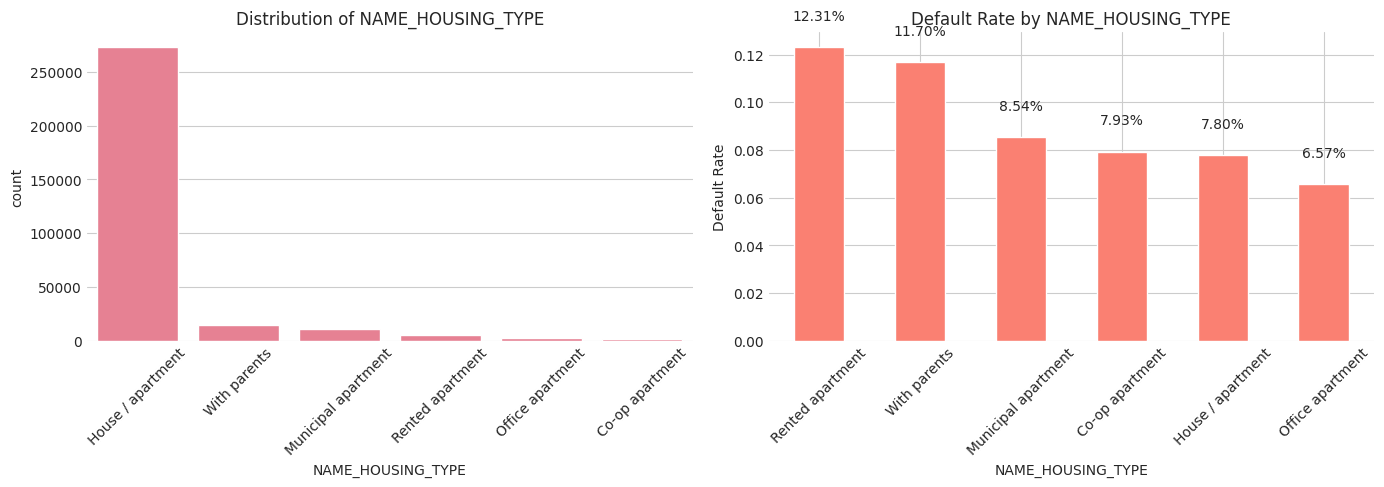


Default Statistics by NAME_HOUSING_TYPE:


Count  Default_Rate  Default_Count
NAME_HOUSING_TYPE                                       
Rented apartment       4881         0.123            601
With parents          14840         0.117           1736
Municipal apartment   11183         0.085            955
Co-op apartment        1122         0.079             89
House / apartment    272868         0.078          21272
Office apartment       2617         0.066            172


Top 10 Occupations by Default Rate:


Count  Default_Rate  Default_Count
OCCUPATION_TYPE                                         
Low-skill Laborers     2093         0.172            359
Drivers               18603         0.113           2107
Waiters/barmen staff   1348         0.113            152
Security staff         6721         0.107            722
Laborers              55186         0.106           5838
Cooking staff          5946         0.104            621
Sales staff           32102         0.096           3092
Cleaning staff         4653         0.096            447
Realty agents           751         0.079             59
Secretaries            1305         0.070             92

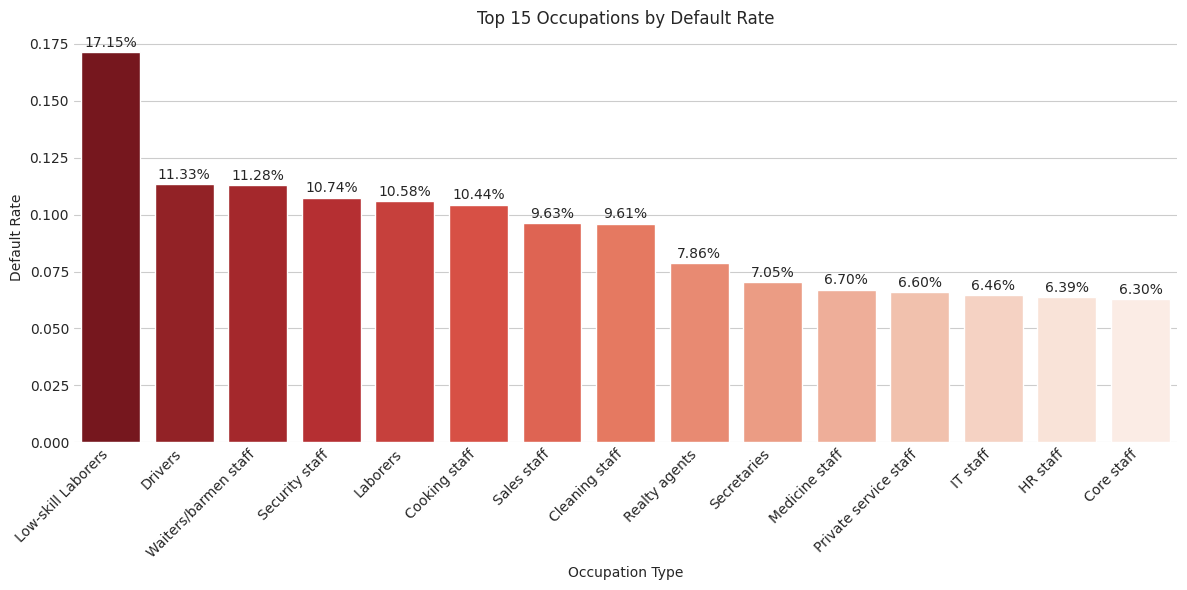

In [ ]:
if not app_data_clean.empty and 'TARGET' in app_data_clean.columns:
    # Analyze key demographic variables
    demographic_cols = [
        'CODE_GENDER',
        'FLAG_OWN_CAR',
        'FLAG_OWN_REALTY',
        'NAME_INCOME_TYPE',
        'NAME_EDUCATION_TYPE',
        'NAME_FAMILY_STATUS',
        'NAME_HOUSING_TYPE'
    ]

    for col in demographic_cols:
        if col in app_data_clean.columns:
            plot_categorical_analysis(app_data_clean, col)

    # Special analysis for occupation (has many categories)
    if 'OCCUPATION_TYPE' in app_data_clean.columns:
        occupation_stats = app_data_clean.groupby('OCCUPATION_TYPE')['TARGET'].agg(['count', 'mean', 'sum']).round(4)
        occupation_stats.columns = ['Count', 'Default_Rate', 'Default_Count']
        occupation_stats = occupation_stats.sort_values('Default_Rate', ascending=False)

        print("\nTop 10 Occupations by Default Rate:")
        display(occupation_stats.head(10))

        # Plot top 15 occupations by default rate
        plt.figure(figsize=(12, 6))
        top_occupations = occupation_stats.head(15)
        ax = sns.barplot(x=top_occupations.index, y='Default_Rate', data=top_occupations, palette='Reds_r')
        plt.title('Top 15 Occupations by Default Rate')
        plt.xlabel('Occupation Type')
        plt.ylabel('Default Rate')
        plt.xticks(rotation=45, ha='right')

        # Add value labels
        for i, v in enumerate(top_occupations['Default_Rate']):
            ax.text(i, v + 0.001, f'{v:.2%}', ha='center', va='bottom')

        plt.tight_layout()
        plt.show()


Financial Variables Summary Statistics:


count       mean        std       min        25%  \
AMT_INCOME_TOTAL     307511.000 168797.919 237123.146 25650.000 112500.000   
AMT_CREDIT           307511.000 599026.000 402490.777 45000.000 270000.000   
AMT_ANNUITY          307499.000  27108.574  14493.737  1615.500  16524.000   
AMT_GOODS_PRICE      307233.000 538396.207 369446.461 40500.000 238500.000   
CREDIT_INCOME_RATIO  307511.000      3.958      2.690     0.005      2.019   
ANNUITY_INCOME_RATIO 307499.000      0.181      0.095     0.000      0.115   

                            50%        75%           max  missing_pct  
AMT_INCOME_TOTAL     147150.000 202500.000 117000000.000        0.000  
AMT_CREDIT           513531.000 808650.000   4050000.000        0.000  
AMT_ANNUITY           24903.000  34596.000    258025.500        0.004  
AMT_GOODS_PRICE      450000.000 679500.000   4050000.000        0.090  
CREDIT_INCOME_RATIO       3.265      5.160        84.737        0.000  
ANNUITY_INCOME_RATIO      0.163      0.229         1.876        0.004


AMT_INCOME_TOTAL - Default Rate by Percentile Bins:


Count  Default_Rate
AMT_INCOME_TOTAL_bin                     
(67499.999, 90000.0]  47803         8.300
(90000.0, 103500.0]    9304         8.800
(103500.0, 112500.0]  33352         8.700
(112500.0, 135000.0]  48849         8.500
(135000.0, 144000.0]   4206         9.000
(144000.0, 157500.0]  29422         8.700
(157500.0, 180000.0]  32529         8.400
(180000.0, 211500.0]  22159         8.000
(211500.0, 247500.0]  29971         7.500
(247500.0, 337500.0]  25762         6.700

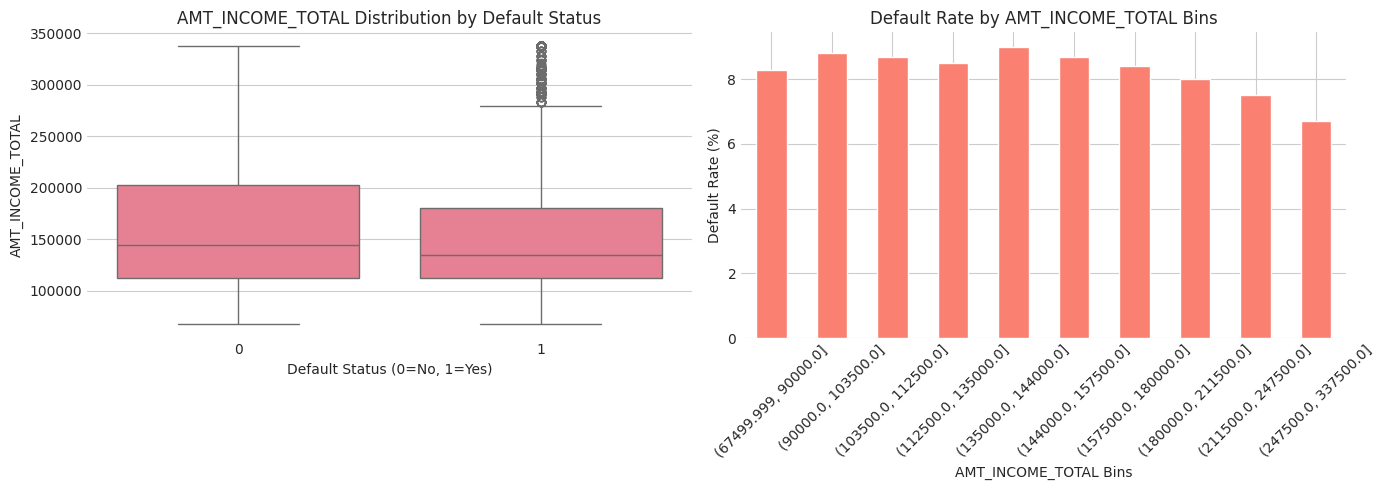


AMT_CREDIT - Default Rate by Percentile Bins:


Count  Default_Rate
AMT_CREDIT_bin                             
(134999.999, 208512.0]  28250         7.400
(208512.0, 265851.0]    28104         7.700
(265851.0, 315000.0]    30001         8.700
(315000.0, 440784.0]    26309        10.100
(440784.0, 509400.0]    28266         9.500
(509400.0, 592560.0]    29512        10.600
(592560.0, 711000.0]    26715         8.600
(711000.0, 838453.5]    28173         7.800
(838453.5, 1057500.0]   28176         6.800
(1057500.0, 1350000.0]  28120         6.200

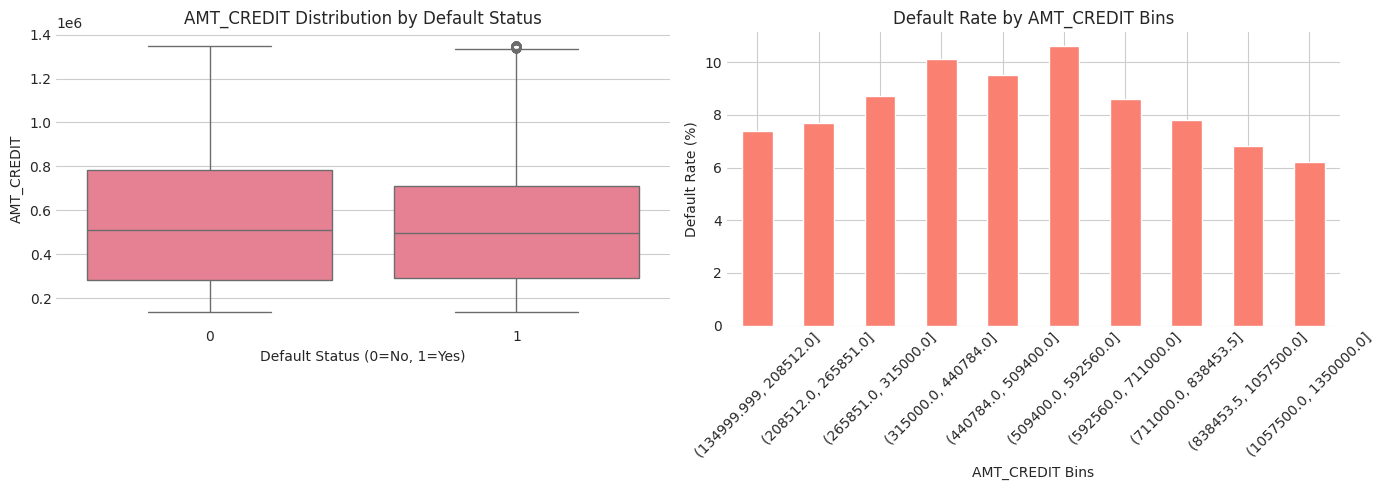


AMT_ANNUITY - Default Rate by Percentile Bins:


Count  Default_Rate
AMT_ANNUITY_bin                         
(8999.999, 12510.0]  27905         7.000
(12510.0, 15750.0]   28001         7.300
(15750.0, 18904.5]   27749         8.800
(18904.5, 21919.5]   27891         8.800
(21919.5, 24799.5]   27913         8.100
(24799.5, 27472.5]   27834         9.400
(27472.5, 31261.5]   28414         9.800
(31261.5, 35730.0]   27351         8.800
(35730.0, 41800.5]   27959         8.200
(41800.5, 53325.0]   27794         6.400

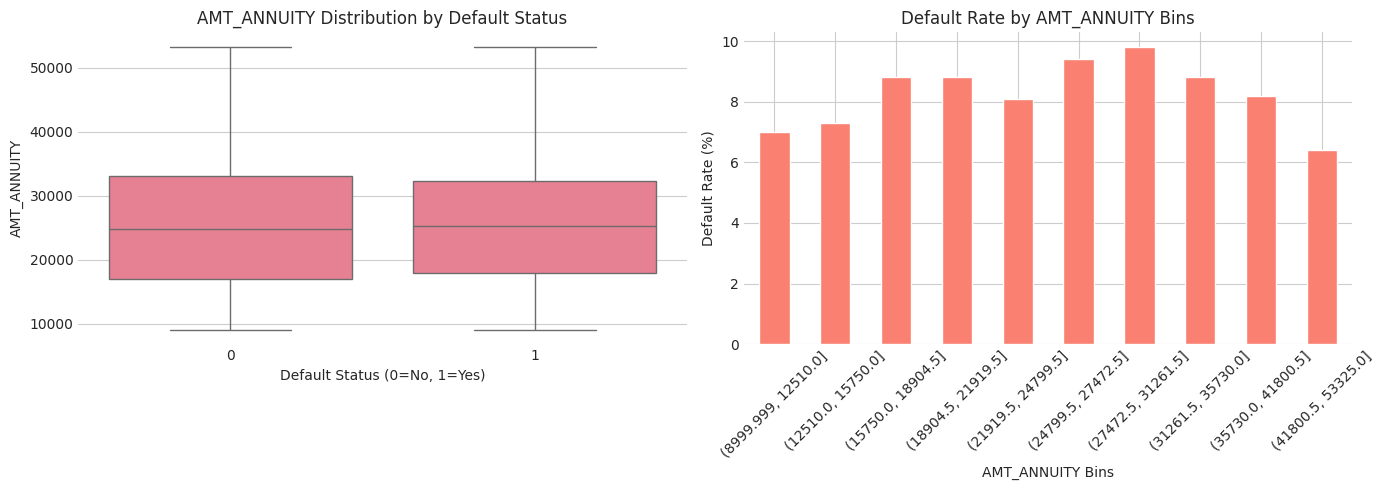


CREDIT_INCOME_RATIO - Default Rate by Percentile Bins:


Count  Default_Rate
CREDIT_INCOME_RATIO_bin                     
(0.999, 1.5]             27869         7.300
(1.5, 1.98]              27712         8.100
(1.98, 2.368]            27789         8.300
(2.368, 2.8]             28258         9.000
(2.8, 3.25]              27450         8.600
(3.25, 3.82]             27777         9.300
(3.82, 4.52]             27781         8.600
(4.52, 5.406]            27728         8.200
(5.406, 6.667]           28495         7.600
(6.667, 9.156]           27038         7.300

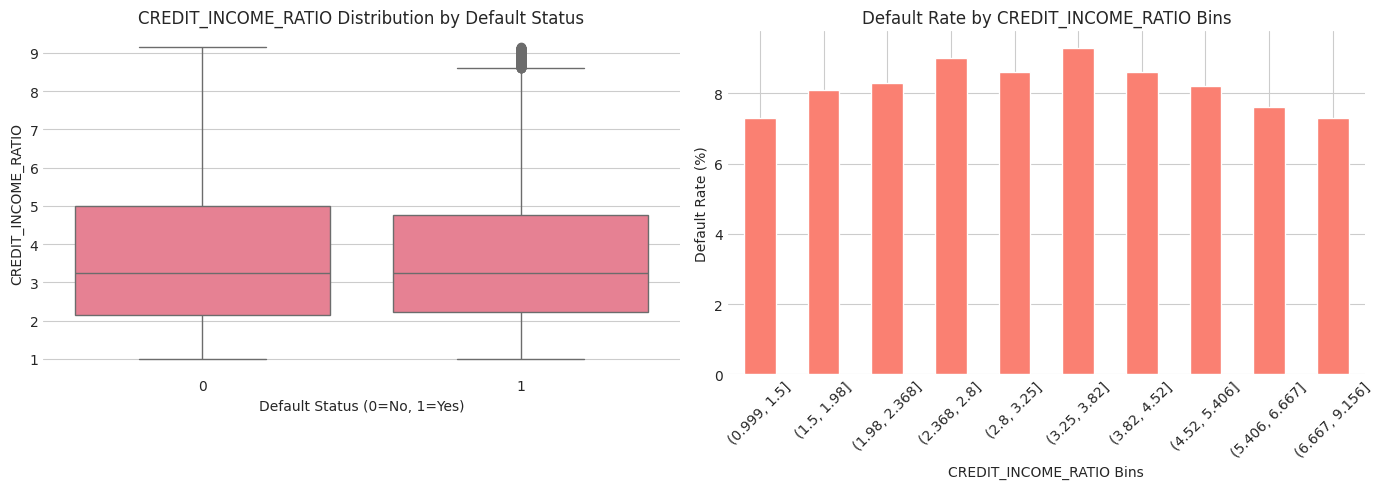

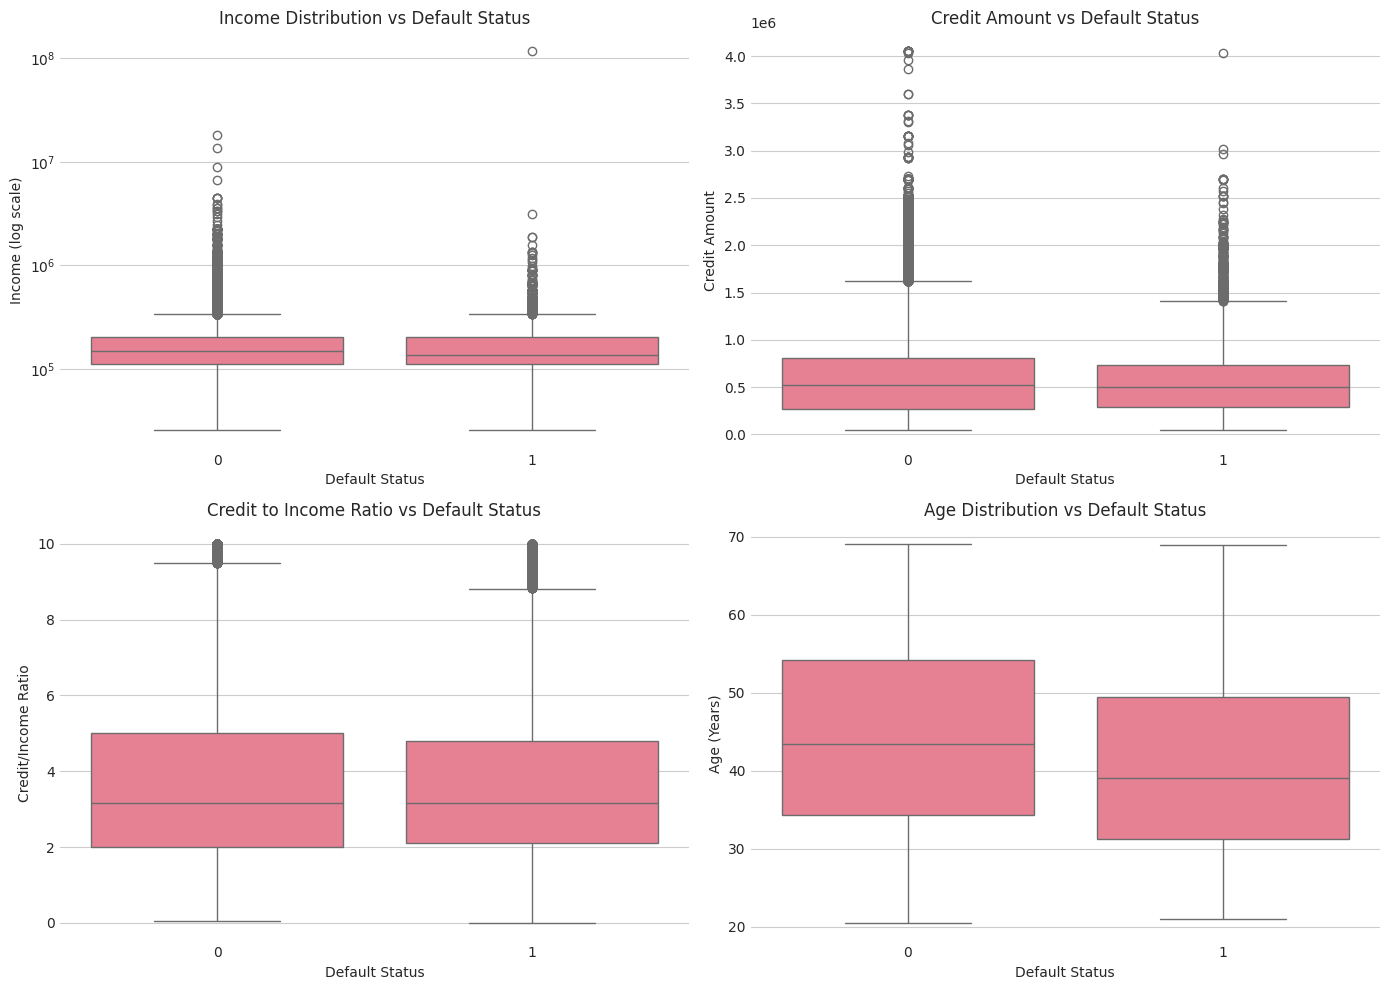

In [ ]:
if not app_data_clean.empty and 'TARGET' in app_data_clean.columns:
    # List of key financial variables
    financial_cols = [
        'AMT_INCOME_TOTAL',
        'AMT_CREDIT',
        'AMT_ANNUITY',
        'AMT_GOODS_PRICE',
        'CREDIT_INCOME_RATIO',
        'ANNUITY_INCOME_RATIO'
    ]

    # Create summary statistics
    existing_financial = [col for col in financial_cols if col in app_data_clean.columns]
    if existing_financial:
        financial_stats = app_data_clean[existing_financial].describe().T
        financial_stats['missing_pct'] = (app_data_clean[existing_financial].isnull().sum() / len(app_data_clean)) * 100
        print("\nFinancial Variables Summary Statistics:")
        display(financial_stats)

        # Analyze relationship with target for key financial variables
        for col in ['AMT_INCOME_TOTAL', 'AMT_CREDIT', 'AMT_ANNUITY', 'CREDIT_INCOME_RATIO']:
            if col in app_data_clean.columns:
                analyze_continuous_variable(app_data_clean, col)

        # Box plots for key financial variables vs target
        fig, axes = plt.subplots(2, 2, figsize=(14, 10))

        # Income vs Target
        if 'AMT_INCOME_TOTAL' in app_data_clean.columns:
            sns.boxplot(x='TARGET', y='AMT_INCOME_TOTAL', data=app_data_clean, ax=axes[0, 0])
            axes[0, 0].set_yscale('log')
            axes[0, 0].set_title('Income Distribution vs Default Status')
            axes[0, 0].set_xlabel('Default Status')
            axes[0, 0].set_ylabel('Income (log scale)')

        # Credit Amount vs Target
        if 'AMT_CREDIT' in app_data_clean.columns:
            sns.boxplot(x='TARGET', y='AMT_CREDIT', data=app_data_clean, ax=axes[0, 1])
            axes[0, 1].set_title('Credit Amount vs Default Status')
            axes[0, 1].set_xlabel('Default Status')
            axes[0, 1].set_ylabel('Credit Amount')

        # Credit to Income Ratio vs Target
        if 'CREDIT_INCOME_RATIO' in app_data_clean.columns:
            # Filter extreme values for better visualization
            filtered_data = app_data_clean[app_data_clean['CREDIT_INCOME_RATIO'] <= 10]
            sns.boxplot(x='TARGET', y='CREDIT_INCOME_RATIO', data=filtered_data, ax=axes[1, 0])
            axes[1, 0].set_title('Credit to Income Ratio vs Default Status')
            axes[1, 0].set_xlabel('Default Status')
            axes[1, 0].set_ylabel('Credit/Income Ratio')

        # Age vs Target
        if 'AGE' in app_data_clean.columns:
            sns.boxplot(x='TARGET', y='AGE', data=app_data_clean, ax=axes[1, 1])
            axes[1, 1].set_title('Age Distribution vs Default Status')
            axes[1, 1].set_xlabel('Default Status')
            axes[1, 1].set_ylabel('Age (Years)')

        plt.tight_layout()
        plt.show()

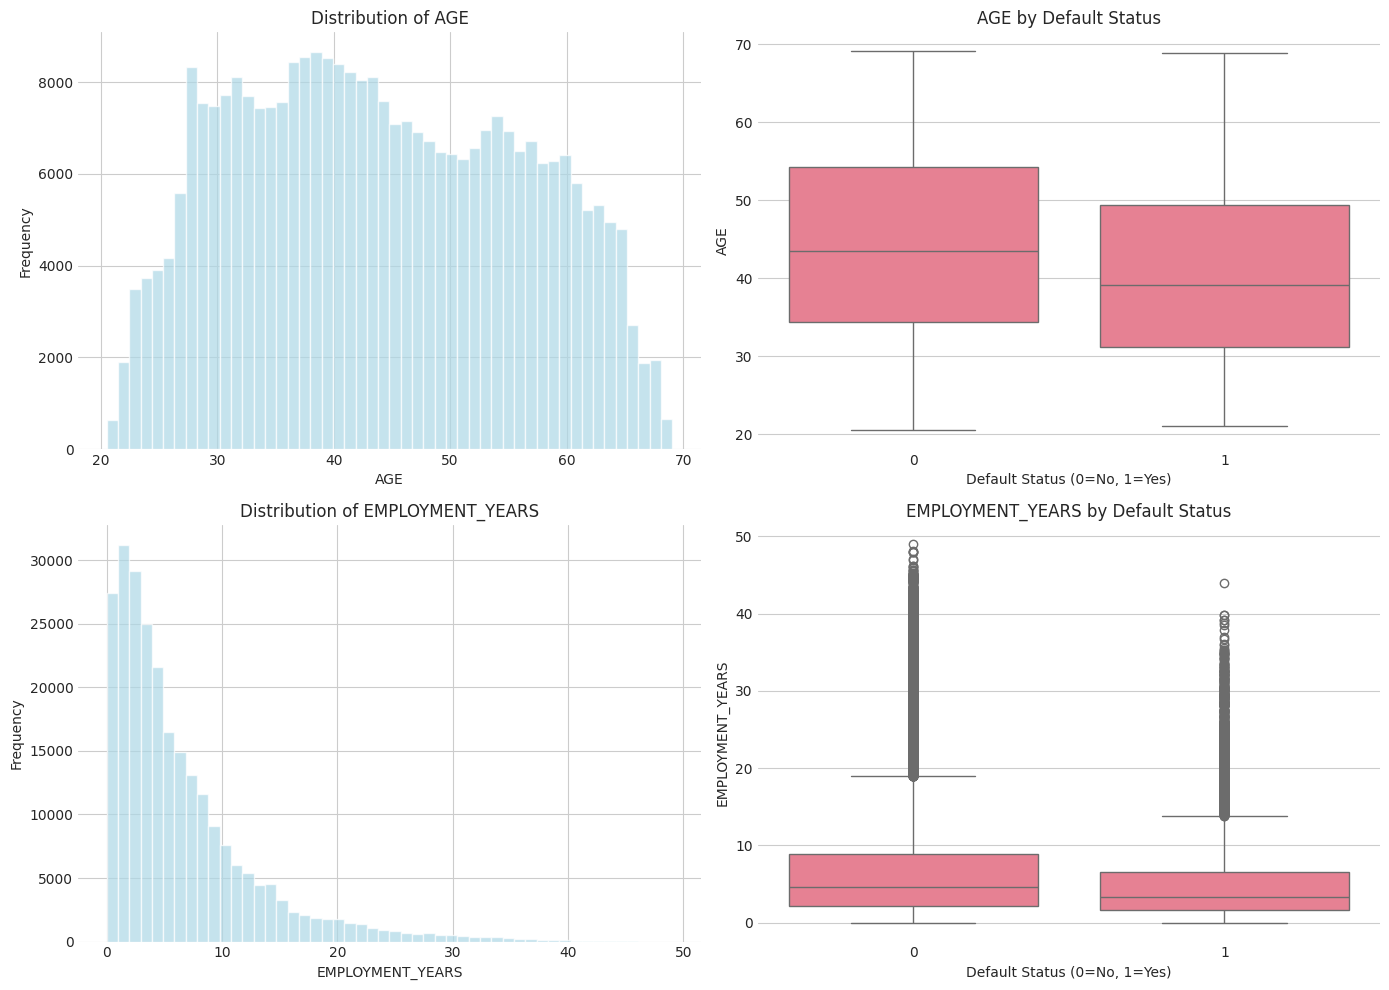


Employment Type Analysis:


Count  Default_Rate  Default_Count  Median_Income  \
NAME_INCOME_TYPE                                                           
Maternity leave            5        40.000              2      90000.000   
Unemployed                22        36.400              8      78750.000   
Working               158774         9.600          15224     135000.000   
Commercial associate   71617         7.500           5360     180000.000   
State servant          21703         5.800           1249     157500.000   
Pensioner              55362         5.400           2982     117000.000   
Businessman               10         0.000              0     495000.000   
Student                   18         0.000              0     157500.000   

                      Median_Age  
NAME_INCOME_TYPE                  
Maternity leave           39.324  
Unemployed                45.829  
Working                   39.849  
Commercial associate      39.754  
State servant             40.665  
Pensioner                 60.372  
Businessman               47.466  
Student                   36.638

In [ ]:
if not app_data_clean.empty and 'TARGET' in app_data_clean.columns:
    # Time-based analysis
    time_cols = ['AGE', 'EMPLOYMENT_YEARS']

    fig, axes = plt.subplots(2, 2, figsize=(14, 10))

    for idx, col in enumerate(time_cols):
        if col in app_data_clean.columns:
            # Distribution
            axes[idx, 0].hist(app_data_clean[col].dropna(), bins=50, alpha=0.7, color='lightblue')
            axes[idx, 0].set_title(f'Distribution of {col}')
            axes[idx, 0].set_xlabel(col)
            axes[idx, 0].set_ylabel('Frequency')

            # Box plot by target
            sns.boxplot(x='TARGET', y=col, data=app_data_clean, ax=axes[idx, 1])
            axes[idx, 1].set_title(f'{col} by Default Status')
            axes[idx, 1].set_xlabel('Default Status (0=No, 1=Yes)')
            axes[idx, 1].set_ylabel(col)

    plt.tight_layout()
    plt.show()

    # Employment type analysis
    if 'NAME_INCOME_TYPE' in app_data_clean.columns:
        employment_analysis = app_data_clean.groupby('NAME_INCOME_TYPE').agg({
            'TARGET': ['count', 'mean', 'sum'],
            'AMT_INCOME_TOTAL': 'median',
            'AGE': 'median'
        }).round(3)

        employment_analysis.columns = ['Count', 'Default_Rate', 'Default_Count',
                                       'Median_Income', 'Median_Age']
        employment_analysis['Default_Rate'] = employment_analysis['Default_Rate'] * 100
        employment_analysis = employment_analysis.sort_values('Default_Rate', ascending=False)

        print("\nEmployment Type Analysis:")
        display(employment_analysis)

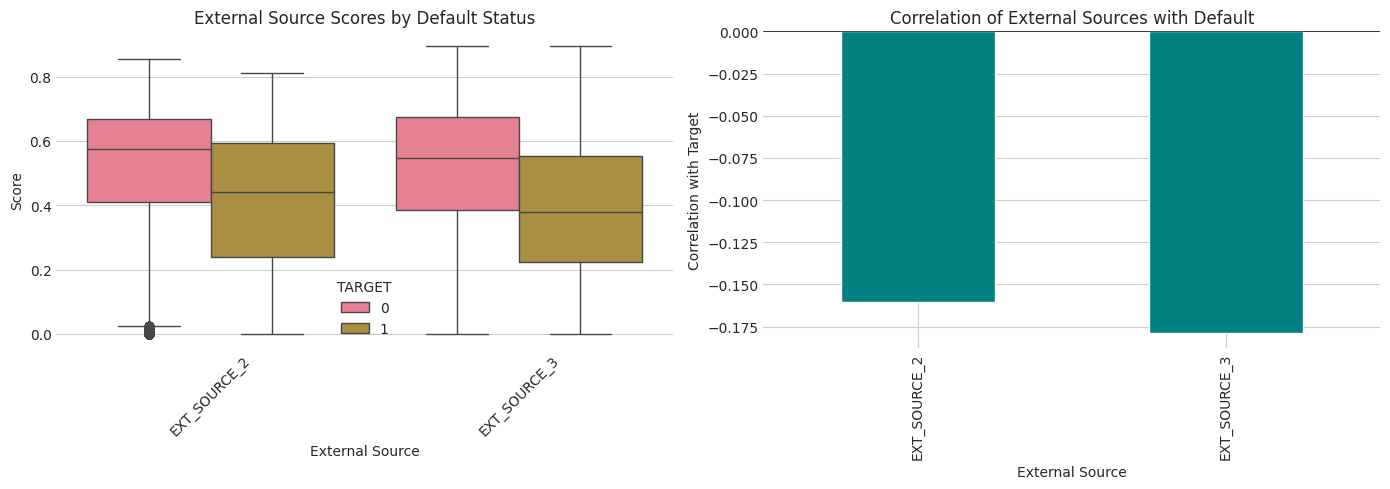


External Source Correlation with Target:


EXT_SOURCE_2  EXT_SOURCE_3
TARGET        -0.160        -0.179

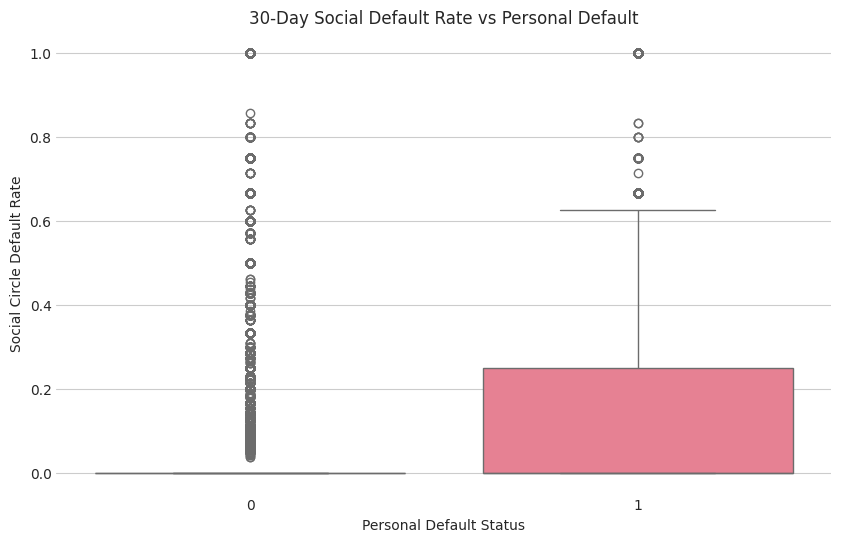

In [ ]:
if not app_data_clean.empty and 'TARGET' in app_data_clean.columns:
    # External source scores analysis
    ext_source_cols = ['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3']
    existing_ext = [col for col in ext_source_cols if col in app_data_clean.columns]

    if existing_ext:
        fig, axes = plt.subplots(1, 2, figsize=(14, 5))

        # Box plot of external scores by target
        ext_data = app_data_clean[existing_ext + ['TARGET']].melt(
            id_vars='TARGET',
            value_vars=existing_ext,
            var_name='Ext_Source',
            value_name='Score'
        )
        sns.boxplot(x='Ext_Source', y='Score', hue='TARGET',
                   data=ext_data, ax=axes[0])
        axes[0].set_title('External Source Scores by Default Status')
        axes[0].set_xlabel('External Source')
        axes[0].set_ylabel('Score')
        axes[0].tick_params(axis='x', rotation=45)

        # Correlation with target
        ext_corr = app_data_clean[existing_ext + ['TARGET']].corr()['TARGET'].drop('TARGET')
        ext_corr.plot(kind='bar', ax=axes[1], color='teal')
        axes[1].set_title('Correlation of External Sources with Default')
        axes[1].set_xlabel('External Source')
        axes[1].set_ylabel('Correlation with Target')
        axes[1].axhline(y=0, color='black', linestyle='-', linewidth=0.5)

        plt.tight_layout()
        plt.show()

        print("\nExternal Source Correlation with Target:")
        display(pd.DataFrame(ext_corr).T)

    # Social circle analysis
    if 'SOCIAL_30_DEFAULT_RATE' in app_data_clean.columns:
        plt.figure(figsize=(10, 6))
        mask = app_data_clean['OBS_30_CNT_SOCIAL_CIRCLE'] > 0
        sns.boxplot(x='TARGET', y='SOCIAL_30_DEFAULT_RATE',
                   data=app_data_clean[mask])
        plt.title('30-Day Social Default Rate vs Personal Default')
        plt.xlabel('Personal Default Status')
        plt.ylabel('Social Circle Default Rate')
        plt.show()

Total unique clients in previous applications: 338857
Total previous applications: 1670214
Average applications per client: 4.93

Percentage of clients with previous applications: 459.72%

Previous Application Status Distribution:
Approved: 1,036,781 (62.07%)
Canceled: 316,319 (18.94%)
Refused: 290,678 (17.40%)
Unused offer: 26,436 (1.58%)


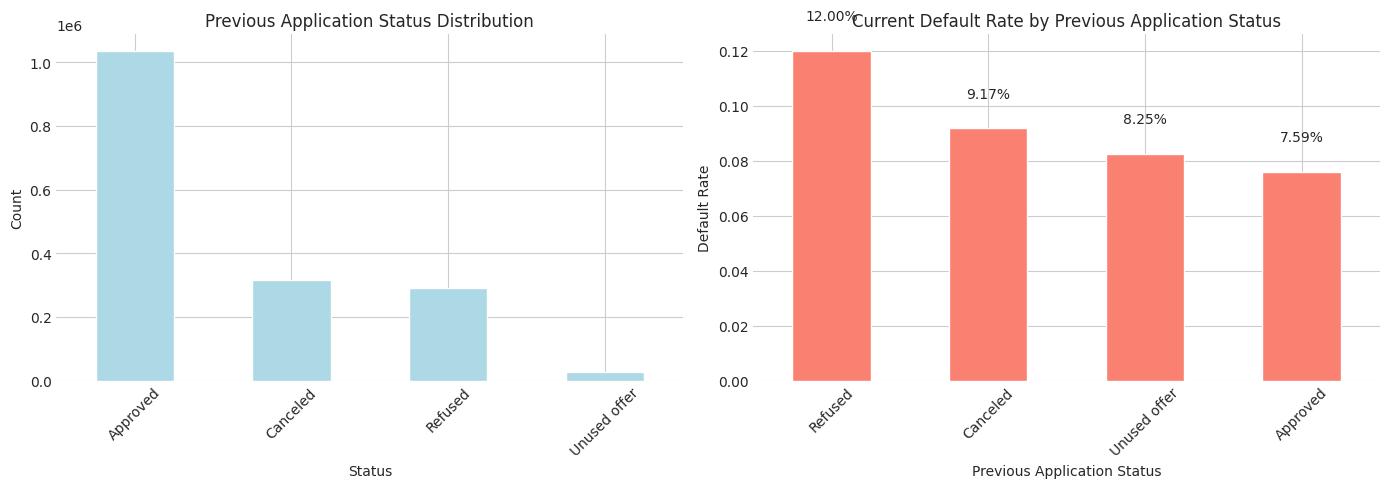


Previous Refusal Impact on Current Default:


Count  Default_Rate  Default_Count
PREV_REFUSED                                     
0             207217         0.070          14473
1             100294         0.103          10352

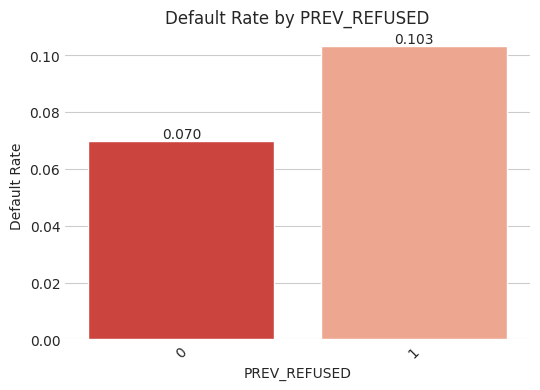

In [ ]:
if not prev_app.empty:
    print(f"Total unique clients in previous applications: {prev_app['SK_ID_CURR'].nunique()}")
    print(f"Total previous applications: {len(prev_app)}")
    print(f"Average applications per client: {len(prev_app) / prev_app['SK_ID_CURR'].nunique():.2f}")

    # Merge with application data to see previous loan impact
    if not app_data_clean.empty and 'SK_ID_CURR' in app_data_clean.columns:
        merged_data = pd.merge(
            app_data_clean[['SK_ID_CURR', 'TARGET']],
            prev_app,
            on='SK_ID_CURR',
            how='left'
        )

        print(f"\nPercentage of clients with previous applications: {(merged_data['SK_ID_PREV'].notnull().sum() / len(app_data_clean)) * 100:.2f}%")

        # Analyze previous application status
        if 'NAME_CONTRACT_STATUS' in prev_app.columns:
            prev_status_dist = prev_app['NAME_CONTRACT_STATUS'].value_counts()
            prev_status_pct = prev_app['NAME_CONTRACT_STATUS'].value_counts(normalize=True) * 100

            print("\nPrevious Application Status Distribution:")
            for status, count in prev_status_dist.items():
                print(f"{status}: {count:,} ({prev_status_pct[status]:.2f}%)")

            # Visualize
            fig, axes = plt.subplots(1, 2, figsize=(14, 5))

            # Status distribution
            prev_status_dist.plot(kind='bar', ax=axes[0], color='lightblue')
            axes[0].set_title('Previous Application Status Distribution')
            axes[0].set_xlabel('Status')
            axes[0].set_ylabel('Count')
            axes[0].tick_params(axis='x', rotation=45)

            # Analyze how previous status affects current default
            if not merged_data.empty:
                status_default = merged_data.groupby('NAME_CONTRACT_STATUS')['TARGET'].mean().sort_values(ascending=False)
                status_default.plot(kind='bar', ax=axes[1], color='salmon')
                axes[1].set_title('Current Default Rate by Previous Application Status')
                axes[1].set_xlabel('Previous Application Status')
                axes[1].set_ylabel('Default Rate')
                axes[1].tick_params(axis='x', rotation=45)

                # Add value labels
                for i, v in enumerate(status_default.values):
                    axes[1].text(i, v + 0.01, f'{v:.2%}', ha='center', va='bottom')

            plt.tight_layout()
            plt.show()

            # Create flag for previous refusals
            refused_ids = prev_app[prev_app['NAME_CONTRACT_STATUS'] == 'Refused']['SK_ID_CURR'].unique()
            app_data_clean['PREV_REFUSED'] = app_data_clean['SK_ID_CURR'].isin(refused_ids).astype(int)

            print("\nPrevious Refusal Impact on Current Default:")
            refusal_stats = app_data_clean.groupby('PREV_REFUSED')['TARGET'].agg(['count', 'mean', 'sum'])
            refusal_stats.columns = ['Count', 'Default_Rate', 'Default_Count']
            display(refusal_stats)

            # Plot default rate for those with previous refusals
            plot_default_rate(app_data_clean, 'PREV_REFUSED', figsize=(6, 4))

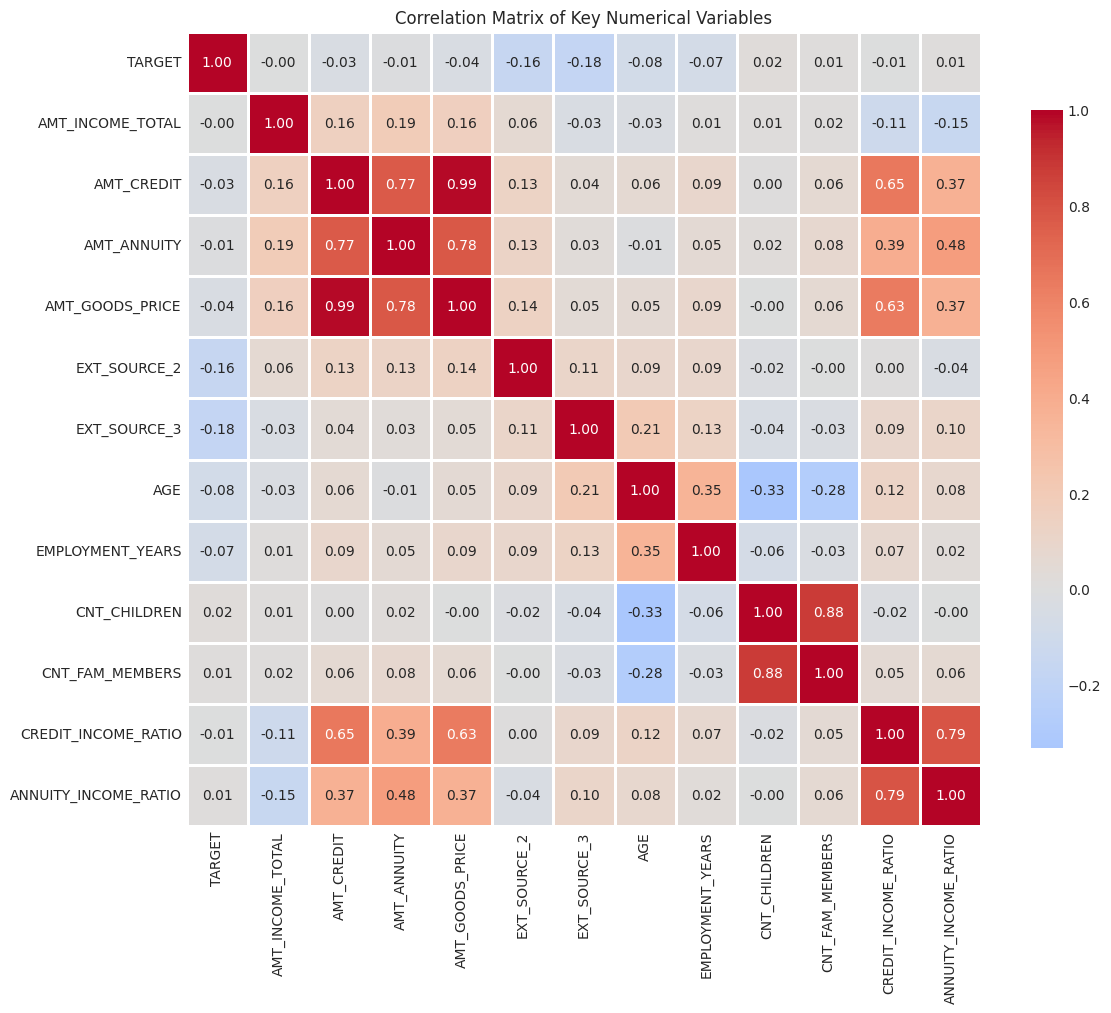


Top 15 Variables Correlated with Target (Absolute Value):


EXT_SOURCE_3           -0.179
EXT_SOURCE_2           -0.160
AGE                    -0.078
EMPLOYMENT_YEARS       -0.075
AMT_GOODS_PRICE        -0.040
AMT_CREDIT             -0.030
CNT_CHILDREN            0.019
ANNUITY_INCOME_RATIO    0.014
AMT_ANNUITY            -0.013
CNT_FAM_MEMBERS         0.009
CREDIT_INCOME_RATIO    -0.008
AMT_INCOME_TOTAL       -0.004
Name: TARGET, dtype: float64

In [ ]:
if not app_data_clean.empty and 'TARGET' in app_data_clean.columns:
    # Select key numerical variables for correlation
    key_numerical_cols = [
        'TARGET',
        'AMT_INCOME_TOTAL',
        'AMT_CREDIT',
        'AMT_ANNUITY',
        'AMT_GOODS_PRICE',
        'EXT_SOURCE_1',
        'EXT_SOURCE_2',
        'EXT_SOURCE_3',
        'AGE',
        'EMPLOYMENT_YEARS',
        'CNT_CHILDREN',
        'CNT_FAM_MEMBERS',
        'CREDIT_INCOME_RATIO',
        'ANNUITY_INCOME_RATIO'
    ]

    # Filter columns that exist in dataframe
    existing_cols = [col for col in key_numerical_cols if col in app_data_clean.columns]
    corr_data = app_data_clean[existing_cols].copy()

    # Calculate correlation matrix
    corr_matrix = corr_data.corr()

    # Visualize correlation matrix
    plt.figure(figsize=(12, 10))
    sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='coolwarm',
                center=0, square=True, linewidths=1, cbar_kws={"shrink": 0.8})
    plt.title('Correlation Matrix of Key Numerical Variables')
    plt.tight_layout()
    plt.show()

    # Top correlations with target
    if 'TARGET' in corr_matrix.columns:
        target_corr = corr_matrix['TARGET'].sort_values(key=abs, ascending=False)
        print("\nTop 15 Variables Correlated with Target (Absolute Value):")
        display(target_corr.head(16).iloc[1:])  # Skip TARGET itself

In [ ]:
if not app_data_clean.empty:
    # Key numerical variables for outlier detection
    outlier_cols = ['AMT_INCOME_TOTAL', 'AMT_CREDIT', 'AMT_ANNUITY',
                    'AMT_GOODS_PRICE', 'AGE', 'CNT_CHILDREN']

    existing_outlier_cols = [col for col in outlier_cols if col in app_data_clean.columns]

    if existing_outlier_cols:
        outliers = detect_outliers_iqr(app_data_clean, existing_outlier_cols)

        print("\nOutliers Summary (IQR Method, 1.5x IQR):")
        for col in existing_outlier_cols[:5]:  # Show first 5 for brevity
            if col in outliers:
                stats = outliers[col]
                if stats['count'] > 0:
                    print(f"\n{col}:")
                    print(f"  Outliers: {stats['count']:,} ({stats['percentage']:.2f}%)")
                    print(f"  Normal range: [{stats['lower_bound']:.2f}, {stats['upper_bound']:.2f}]")


Outliers Summary (IQR Method, 1.5x IQR):

AMT_INCOME_TOTAL:
  Outliers: 14,035 (4.56%)
  Normal range: [-22500.00, 337500.00]

AMT_CREDIT:
  Outliers: 6,562 (2.13%)
  Normal range: [-537975.00, 1616625.00]

AMT_ANNUITY:
  Outliers: 7,504 (2.44%)
  Normal range: [-10584.00, 61704.00]

AMT_GOODS_PRICE:
  Outliers: 14,728 (4.79%)
  Normal range: [-423000.00, 1341000.00]


In [ ]:
insights = {
    "Dataset Overview": {
        "Total Applications": len(app_data) if not app_data.empty else "N/A",
        "Default Rate": f"{app_data['TARGET'].mean() * 100:.2f}%" if not app_data.empty and 'TARGET' in app_data.columns else "N/A",
        "Class Imbalance": f"{app_data[app_data['TARGET'] == 0].shape[0] / app_data[app_data['TARGET'] == 1].shape[0]:.1f}:1" if not app_data.empty and 'TARGET' in app_data.columns else "N/A"
    },
    "Data Quality": {
        "Application Columns": app_data.shape[1] if not app_data.empty else "N/A",
        "Previous App Columns": prev_app.shape[1] if not prev_app.empty else "N/A",
        "High Missing Columns (>40%)": len(cols_to_drop) if 'cols_to_drop' in locals() else "N/A",
        "Employment Anomalies": f"{app_data_clean['EMPLOYMENT_ANOMALY'].sum():,} cases" if not app_data_clean.empty and 'EMPLOYMENT_ANOMALY' in app_data_clean.columns else "N/A"
    },
    "Key Findings": [
        "1. Dataset is highly imbalanced with only ~8% default cases",
        "2. Several columns have very high missing values (>40%)",
        "3. External source scores show strong correlation with default",
        "4. Income type and education level significantly impact default rates",
        "5. Social circle defaults correlate with personal default probability",
        "6. Previous loan refusals increase current default probability",
        "7. Higher credit-to-income ratios are associated with higher defaults",
        "8. Certain occupations (Laborers, Low-skill Laborers) have highest default rates"
    ]
}

# Display insights
for category, content in insights.items():
    print(f"\n{category}:")
    print("-" * 40)
    if isinstance(content, dict):
        for key, value in content.items():
            print(f"  {key}: {value}")
    else:
        for item in content:
            print(f"  {item}")


Dataset Overview:
----------------------------------------
  Total Applications: 307511
  Default Rate: 8.07%
  Class Imbalance: 11.4:1

Data Quality:
----------------------------------------
  Application Columns: 122
  Previous App Columns: 37
  High Missing Columns (>40%): 49
  Employment Anomalies: 55,374 cases

Key Findings:
----------------------------------------
  1. Dataset is highly imbalanced with only ~8% default cases
  2. Several columns have very high missing values (>40%)
  3. External source scores show strong correlation with default
  4. Income type and education level significantly impact default rates
  5. Social circle defaults correlate with personal default probability
  6. Previous loan refusals increase current default probability
  7. Higher credit-to-income ratios are associated with higher defaults
  8. Certain occupations (Laborers, Low-skill Laborers) have highest default rates


In [ ]:
app_data_clean.describe()

SK_ID_CURR     TARGET  CNT_CHILDREN  AMT_INCOME_TOTAL  AMT_CREDIT  \
count  307511.000 307511.000    307511.000        307511.000  307511.000   
mean   278180.519      0.081         0.417        168797.919  599026.000   
std    102790.175      0.272         0.722        237123.146  402490.777   
min    100002.000      0.000         0.000         25650.000   45000.000   
25%    189145.500      0.000         0.000        112500.000  270000.000   
50%    278202.000      0.000         0.000        147150.000  513531.000   
75%    367142.500      0.000         1.000        202500.000  808650.000   
max    456255.000      1.000        19.000     117000000.000 4050000.000   

       AMT_ANNUITY  AMT_GOODS_PRICE  REGION_POPULATION_RELATIVE  DAYS_BIRTH  \
count   307499.000       307233.000                  307511.000  307511.000   
mean     27108.574       538396.207                       0.021  -16036.995   
std      14493.737       369446.461                       0.014    4363.989   
min       1615.500        40500.000                       0.000  -25229.000   
25%      16524.000       238500.000                       0.010  -19682.000   
50%      24903.000       450000.000                       0.019  -15750.000   
75%      34596.000       679500.000                       0.029  -12413.000   
max     258025.500      4050000.000                       0.073   -7489.000   

       DAYS_EMPLOYED  DAYS_REGISTRATION  DAYS_ID_PUBLISH  FLAG_MOBIL  \
count     307511.000         307511.000       307511.000  307511.000   
mean       63815.046          -4986.120        -2994.202       1.000   
std       141275.767           3522.886         1509.450       0.002   
min       -17912.000         -24672.000        -7197.000       0.000   
25%        -2760.000          -7479.500        -4299.000       1.000   
50%        -1213.000          -4504.000        -3254.000       1.000   
75%         -289.000          -2010.000        -1720.000       1.000   
max       365243.000              0.000            0.000       1.000   

       FLAG_EMP_PHONE  FLAG_WORK_PHONE  FLAG_CONT_MOBILE  FLAG_PHONE  \
count      307511.000       307511.000        307511.000  307511.000   
mean            0.820            0.199             0.998       0.281   
std             0.384            0.400             0.043       0.450   
min             0.000            0.000             0.000       0.000   
25%             1.000            0.000             1.000       0.000   
50%             1.000            0.000             1.000       0.000   
75%             1.000            0.000             1.000       1.000   
max             1.000            1.000             1.000       1.000   

       FLAG_EMAIL  CNT_FAM_MEMBERS  REGION_RATING_CLIENT  \
count  307511.000       307509.000            307511.000   
mean        0.057            2.153                 2.052   
std         0.231            0.911                 0.509   
min         0.000            1.000                 1.000   
25%         0.000            2.000                 2.000   
50%         0.000            2.000                 2.000   
75%         0.000            3.000                 2.000   
max         1.000           20.000                 3.000   

       REGION_RATING_CLIENT_W_CITY  HOUR_APPR_PROCESS_START  \
count                   307511.000               307511.000   
mean                         2.032                   12.063   
std                          0.503                    3.266   
min                          1.000                    0.000   
25%                          2.000                   10.000   
50%                          2.000                   12.000   
75%                          2.000                   14.000   
max                          3.000                   23.000   

       REG_REGION_NOT_LIVE_REGION  REG_REGION_NOT_WORK_REGION  \
count                  307511.000                  307511.000   
mean                        0.015                       0.051   
std     

In [ ]:
prev_app.describe()

SK_ID_PREV  SK_ID_CURR  AMT_ANNUITY  AMT_APPLICATION  AMT_CREDIT  \
count 1670214.000 1670214.000  1297979.000      1670214.000 1670213.000   
mean  1923089.135  278357.174    15955.121       175233.860  196114.021   
std    532597.959  102814.824    14782.137       292779.762  318574.617   
min   1000001.000  100001.000        0.000            0.000       0.000   
25%   1461857.250  189329.000     6321.780        18720.000   24160.500   
50%   1923110.500  278714.500    11250.000        71046.000   80541.000   
75%   2384279.750  367514.000    20658.420       180360.000  216418.500   
max   2845382.000  456255.000   418058.145      6905160.000 6905160.000   

       AMT_DOWN_PAYMENT  AMT_GOODS_PRICE  HOUR_APPR_PROCESS_START  \
count        774370.000      1284699.000              1670214.000   
mean           6697.402       227847.279                   12.484   
std           20921.495       315396.558                    3.334   
min              -0.900            0.000                    0.000   
25%               0.000        50841.000                   10.000   
50%            1638.000       112320.000                   12.000   
75%            7740.000       234000.000                   15.000   
max         3060045.000      6905160.000                   23.000   

       NFLAG_LAST_APPL_IN_DAY  RATE_DOWN_PAYMENT  RATE_INTEREST_PRIMARY  \
count             1670214.000         774370.000               5951.000   
mean                    0.996              0.080                  0.188   
std                     0.059              0.108                  0.088   
min                     0.000             -0.000                  0.035   
25%                     1.000              0.000                  0.161   
50%                     1.000              0.052                  0.189   
75%                     1.000              0.109                  0.193   
max                     1.000              1.000                  1.000   

       RATE_INTEREST_PRIVILEGED  DAYS_DECISION  SELLERPLACE_AREA  CNT_PAYMENT  \
count                  5951.000    1670214.000       1670214.000  1297984.000   
mean                      0.774       -880.680           313.951       16.054   
std                       0.101        779.100          7127.443       14.567   
min                       0.373      -2922.000            -1.000        0.000   
25%                       0.716      -1300.000            -1.000        6.000   
50%                       0.835       -581.000             3.000       12.000   
75%                       0.853       -280.000            82.000       24.000   
max                       1.000         -1.000       4000000.000       84.000   

       DAYS_FIRST_DRAWING  DAYS_FIRST_DUE  DAYS_LAST_DUE_1ST_VERSION  \
count          997149.000      997149.000                 997149.000   
mean           342209.855       13826.269                  33767.774   
std             88916.116       72444.870                 106857.035   
min             -2922.000       -2892.000                  -2801.000   
25%            365243.000       -1628.000                  -1242.000   
50%            365243.000        -831.000                   -361.000   
75%            365243.000        -411.000                    129.000   
max            365243.000      365243.000                 365243.000   

       DAYS_LAST_DUE  DAYS_TERMINATION  NFLAG_INSURED_ON_APPROVAL  
count     997149.000        997149.000                 997149.000  
mean       76582.403         81992.344                      0.333  
std       149647.415        153303.517                      0.471  
min        -2889.000         -2874.000                      0.000  
25%        -1314.000         -1270.000                      0.000  
50%         -537.000          -499.000                      0.000  
75%          -74.000           -44.000                      1.000  
max       365243.000        365243.000                      1.000

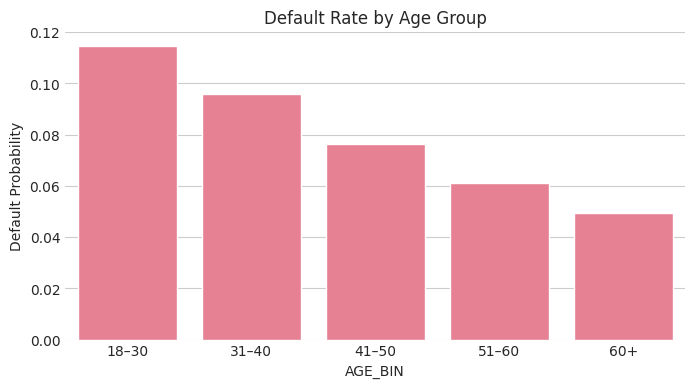

In [ ]:
app_data_clean['AGE_BIN'] = pd.cut(app_data_clean['AGE'], bins=[18,30,40,50,60,100],
                       labels=["18–30","31–40","41–50","51–60","60+"] )

age_default = app_data_clean.groupby('AGE_BIN')['TARGET'].mean().reset_index()

plt.figure(figsize=(8,4))
sns.barplot(data=age_default, x='AGE_BIN', y='TARGET')
plt.title("Default Rate by Age Group")
plt.ylabel("Default Probability")
plt.show()


Younger customers (18–30) show the highest default propensity, slowly decreasing with age.

Interpretation

Younger borrowers have unstable careers and less savings → higher risk.

Older borrowers (>50) are more stable → lower risk.

Business Implication

➜ Apply stricter underwriting and income validation for <30 years age group.

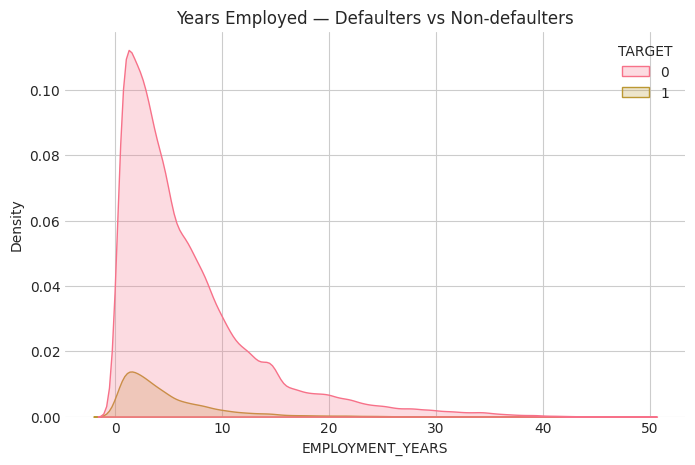

In [ ]:
plt.figure(figsize=(8,5))
sns.kdeplot(data=app_data_clean, x='EMPLOYMENT_YEARS', hue='TARGET', fill=True)
plt.title("Years Employed — Defaulters vs Non-defaulters")
plt.show()


In [ ]:
top_ext = ['EXT_SOURCE_2','EXT_SOURCE_3']
app_data_clean[top_ext + ['TARGET']].corr()


EXT_SOURCE_2  EXT_SOURCE_3  TARGET
EXT_SOURCE_2         1.000         0.109  -0.160
EXT_SOURCE_3         0.109         1.000  -0.179
TARGET              -0.160        -0.179   1.000

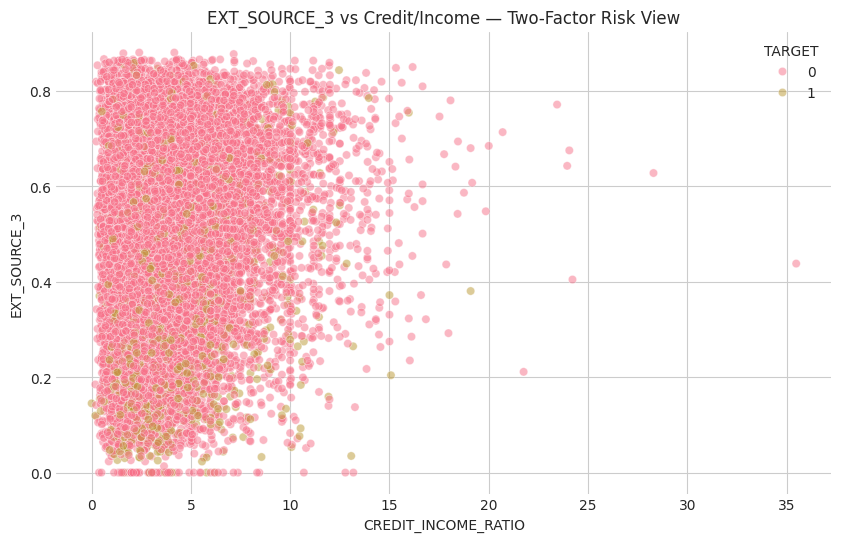

In [ ]:
plt.figure(figsize=(10,6))
sns.scatterplot(data=app_data_clean.sample(20000, random_state=42),
                x='CREDIT_INCOME_RATIO',
                y='EXT_SOURCE_3',
                hue='TARGET',
                alpha=0.5)
plt.title("EXT_SOURCE_3 vs Credit/Income — Two-Factor Risk View")
plt.show()


Two-factor risk visualization reveals a high-risk cluster.

Interpretation

Defaulters occupy the region:

High Credit/Income

Low EXT_SOURCE_3

Business Implication

➜ Build a rule:
If (Credit/Income > 4.0) & (EXT_SOURCE_3 < 0.4) → Manual Review Required

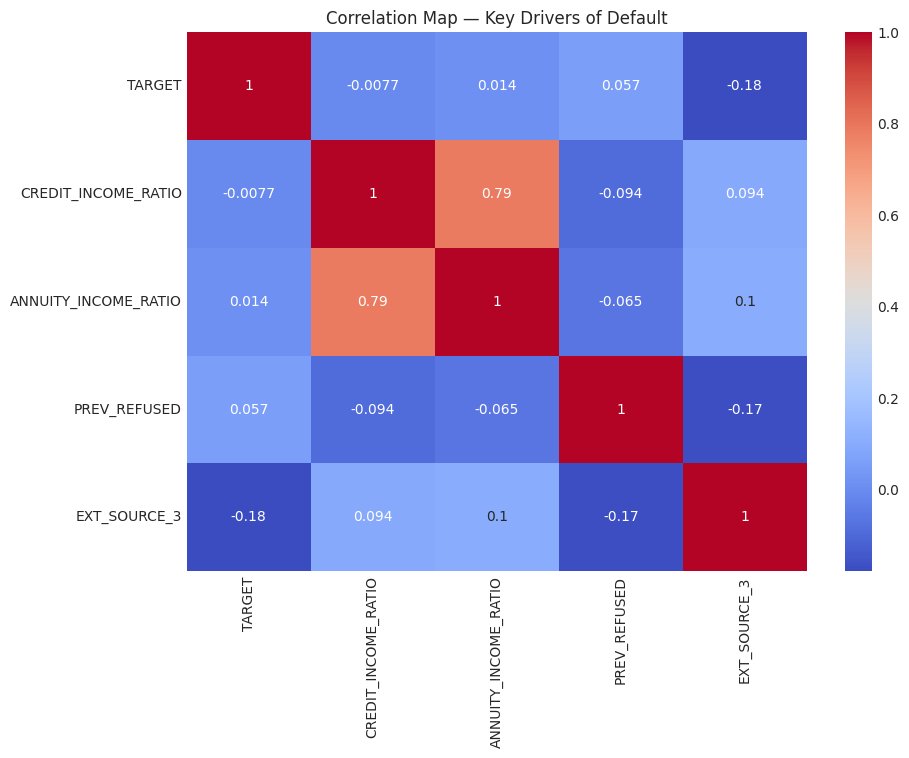

In [ ]:
plt.figure(figsize=(10,7))
sns.heatmap(app_data_clean[['TARGET','CREDIT_INCOME_RATIO','ANNUITY_INCOME_RATIO',
                'PREV_REFUSED','EXT_SOURCE_3']].corr(),
            annot=True, cmap='coolwarm')
plt.title("Correlation Map — Key Drivers of Default")
plt.show()


In [ ]:
!pip install -q lightgbm plotly fpdf --quiet
import os
import gc
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import lightgbm as lgb
from fpdf import FPDF
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score
from IPython.display import display, Markdown

  Preparing metadata (setup.py) ... done


In [ ]:
plt.style.use("seaborn-v0_8-whitegrid")
sns.set_palette('muted')
pd.set_option('display.max_columns', 200)

# helper to show a markdown heading in notebook
def note(title, txt=None):
    display(Markdown(f"### {title}"))
    if txt:
        display(Markdown(txt))

# Paths - update if needed
APP_PATH = "/content/drive/MyDrive/file_zip/application_data.csv"
PREV_PATH = "/content/drive/MyDrive/file_zip/previous_application.csv"
DESC_PATH = "/content/drive/MyDrive/file_zip/columns_description.xlsx"

# 1. Load (use low_memory=False to avoid dtype warnings)
note("Loading datasets")
app = pd.read_csv(APP_PATH, low_memory=False)
prev = pd.read_csv(PREV_PATH, low_memory=False)
desc = pd.read_excel(DESC_PATH) if DESC_PATH.endswith('.xlsx') or DESC_PATH.endswith('.xls') else pd.read_csv(DESC_PATH)

note("Shapes", f"application_data: {app.shape}  —  previous_application: {prev.shape}")

### Loading datasets

### Shapes

application_data: (307511, 122)  —  previous_application: (1670214, 37)

In [ ]:
# 2. Minimal checks & consistent colnames
note("Quick sanity checks")
print("application columns:", app_data_clean.shape[1])
print("previous columns:", prev.shape[1])
print("Target rate:", app['TARGET'].mean(), "(= fraction of defaults)")

# Ensure no accidental duplicate column names
assert app.columns.is_unique
assert prev.columns.is_unique


### Quick sanity checks

application columns: 82
previous columns: 37
Target rate: 0.08072881945686496 (= fraction of defaults)


In [ ]:
# 3. Clean & Feature Engineering (core)
note("Feature engineering explanation",
     "We'll create robust derived features that are high signal for credit risk: AGE (years), YEARS_EMPLOYED, "
     "CREDIT_INCOME_RATIO, ANNUITY_INCOME_RATIO, INCOME_PER_PERSON, and mark DAYS_EMPLOYED placeholder (365243) -> NaN")

# copy to avoid accidental change to original
df = app_data_clean.copy()

# DAYS_EMPLOYED uses 365243 as placeholder in many Home Credit datasets -> convert to NaN
df['DAYS_EMPLOYED'].replace(365243, np.nan, inplace=True)

# AGE in years from DAYS_BIRTH (negative days)
df['AGE_YEARS'] = (-df['DAYS_BIRTH']) / 365.25

# Years employed (make positive years) and clip negatives to 0 (some small negative values exist)
df['YEARS_EMPLOYED'] = (-df['DAYS_EMPLOYED']) / 365.25
df['YEARS_EMPLOYED'] = df['YEARS_EMPLOYED'].clip(lower=0)

# Ratios
df['CREDIT_INCOME_RATIO'] = df['AMT_CREDIT'] / (df['AMT_INCOME_TOTAL'] + 1e-9)
df['ANNUITY_INCOME_RATIO'] = df['AMT_ANNUITY'] / (df['AMT_INCOME_TOTAL'] + 1e-9)
df['CREDIT_GOODS_RATIO'] = df['AMT_CREDIT'] / (df['AMT_GOODS_PRICE'] + 1e-9)

# Income per person (divide by household size)
df['INCOME_PER_PERSON'] = df['AMT_INCOME_TOTAL'] / (df['CNT_FAM_MEMBERS'].replace(0, np.nan).fillna(1))

# Employment stability = years employed / age (a rough metric)
df['EMPLOYMENT_STABILITY'] = df['YEARS_EMPLOYED'] / (df['AGE_YEARS'] + 1e-9)

# Age bins (helpful for plotting & segmentation)
bins = [18, 25, 35, 45, 55, 65, 100]
labels = ['18-25','26-35','36-45','46-55','56-65','65+']
df['AGE_BIN'] = pd.cut(df['AGE_YEARS'], bins=bins, labels=labels, include_lowest=True)

# Count employment anomaly
emp_anom_count = app['DAYS_EMPLOYED'].value_counts().get(365243, 0)
note("Numbers cleaned", f"Replaced {emp_anom_count} placeholder DAYS_EMPLOYED with NaN")


### Feature engineering explanation

We'll create robust derived features that are high signal for credit risk: AGE (years), YEARS_EMPLOYED, CREDIT_INCOME_RATIO, ANNUITY_INCOME_RATIO, INCOME_PER_PERSON, and mark DAYS_EMPLOYED placeholder (365243) -> NaN

### Numbers cleaned

Replaced 55374 placeholder DAYS_EMPLOYED with NaN

### A1: Age distribution & default rate by age bin

Why: Age groups often have distinct risk patterns (youngers may have higher defaults).

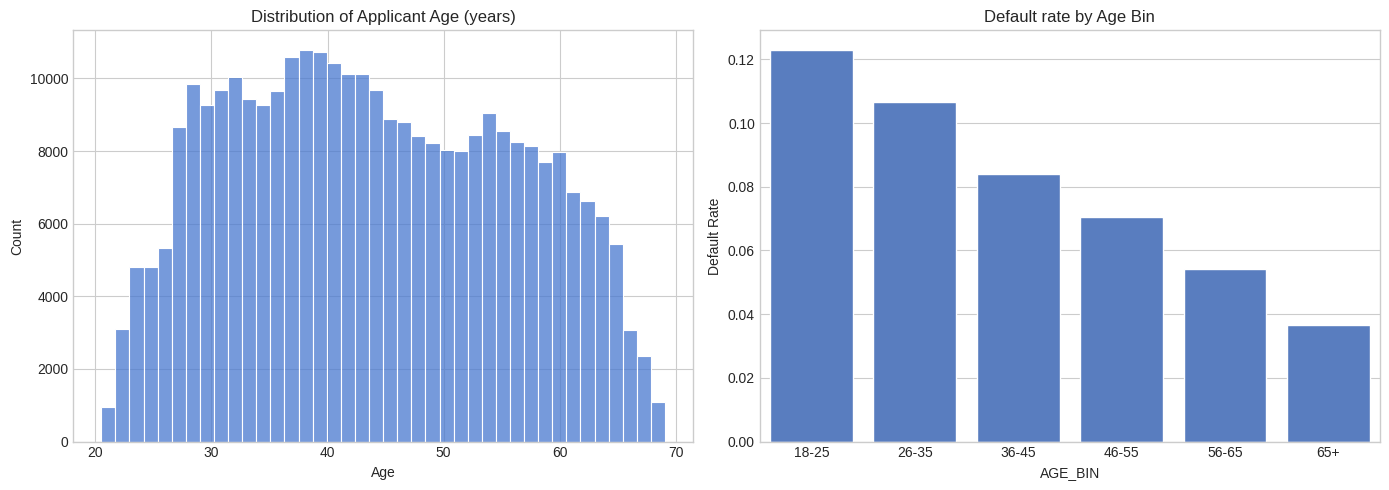

AGE_BIN  mean  count
0   18-25 0.123  12233
1   26-35 0.107  72429
2   36-45 0.084  84261
3   46-55 0.070  70190
4   56-65 0.054  60522
5     65+ 0.037   7876

In [ ]:
# A1: Age distribution + default rate by age bin
note("A1: Age distribution & default rate by age bin",
     "Why: Age groups often have distinct risk patterns (youngers may have higher defaults).")

fig, ax = plt.subplots(1,2, figsize=(14,5))
sns.histplot(df['AGE_YEARS'].dropna(), bins=40, ax=ax[0])
ax[0].set_title("Distribution of Applicant Age (years)")
ax[0].set_xlabel("Age")

# default rate by age bin
age_grp = df.groupby('AGE_BIN')['TARGET'].agg(['mean','count']).reset_index()
sns.barplot(x='AGE_BIN', y='mean', data=age_grp, ax=ax[1])
ax[1].set_title("Default rate by Age Bin")
ax[1].set_ylabel("Default Rate")
plt.tight_layout()
plt.show()

display(age_grp.sort_values('mean', ascending=False))


### A2: Gender / Family / Education vs Default

Why: demographic groups can reveal coarse risk segments.

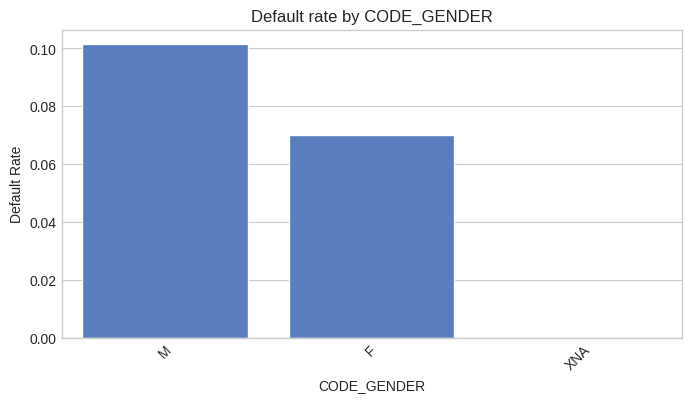

CODE_GENDER  mean   count
1           M 0.101  105059
0           F 0.070  202448
2         XNA 0.000       4

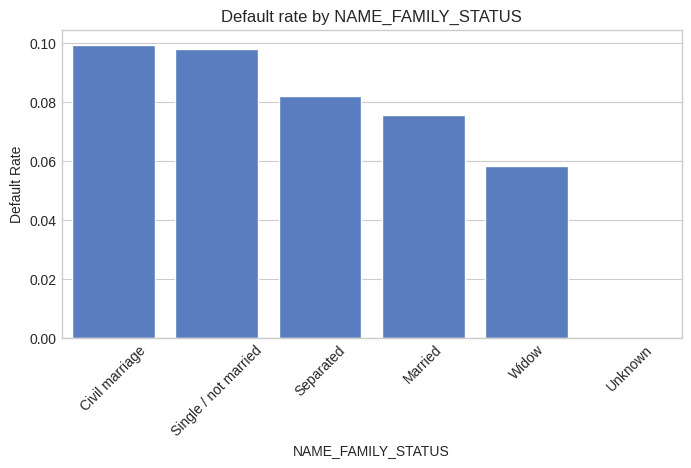

NAME_FAMILY_STATUS  mean   count
0        Civil marriage 0.099   29775
3  Single / not married 0.098   45444
2             Separated 0.082   19770
1               Married 0.076  196432
5                 Widow 0.058   16088
4               Unknown 0.000       2

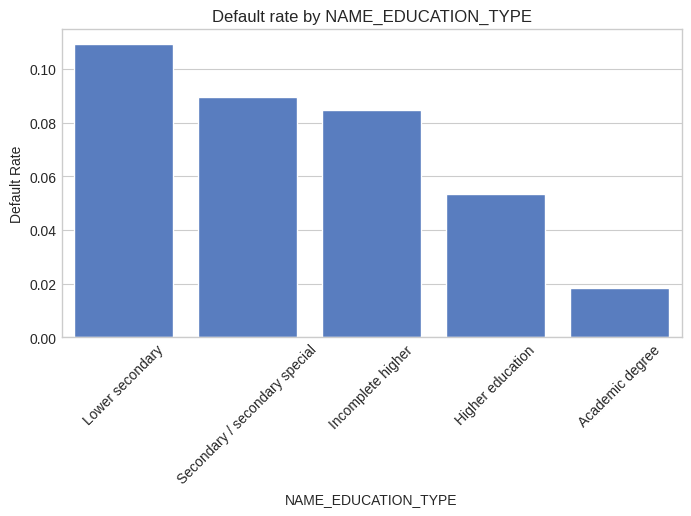

NAME_EDUCATION_TYPE  mean   count
3                Lower secondary 0.109    3816
4  Secondary / secondary special 0.089  218391
2              Incomplete higher 0.085   10277
1               Higher education 0.054   74863
0                Academic degree 0.018     164

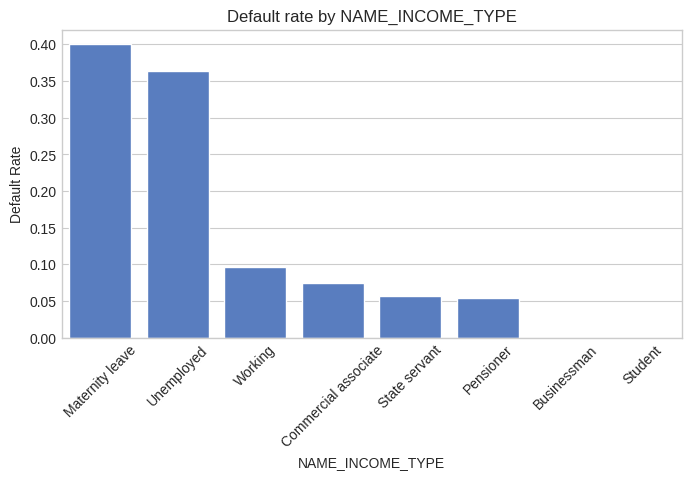

NAME_INCOME_TYPE  mean   count
2       Maternity leave 0.400       5
6            Unemployed 0.364      22
7               Working 0.096  158774
1  Commercial associate 0.075   71617
4         State servant 0.058   21703
3             Pensioner 0.054   55362
0           Businessman 0.000      10
5               Student 0.000      18

In [ ]:
# A2: Gender, family status, and education — categorical comparisons
note("A2: Gender / Family / Education vs Default", "Why: demographic groups can reveal coarse risk segments.")

cat_cols = ['CODE_GENDER','NAME_FAMILY_STATUS','NAME_EDUCATION_TYPE','NAME_INCOME_TYPE']
for col in cat_cols:
    if col in df.columns:
        grp = df.groupby(col)['TARGET'].agg(['mean','count']).reset_index().sort_values('mean', ascending=False)
        plt.figure(figsize=(8,4))
        sns.barplot(x=col, y='mean', data=grp)
        plt.title(f"Default rate by {col}")
        plt.ylabel('Default Rate')
        plt.xticks(rotation=45)
        plt.show()
        display(grp)


### B1: Income & Credit distributions (log scale) and default separation

Why: distributions are skewed; log plots reveal patterns. We'll also show default rate per income decile.

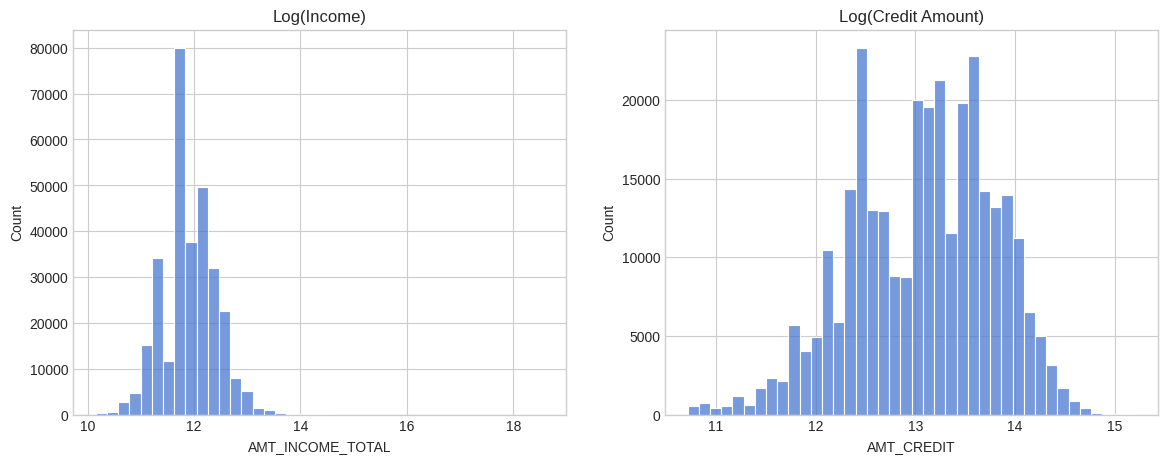

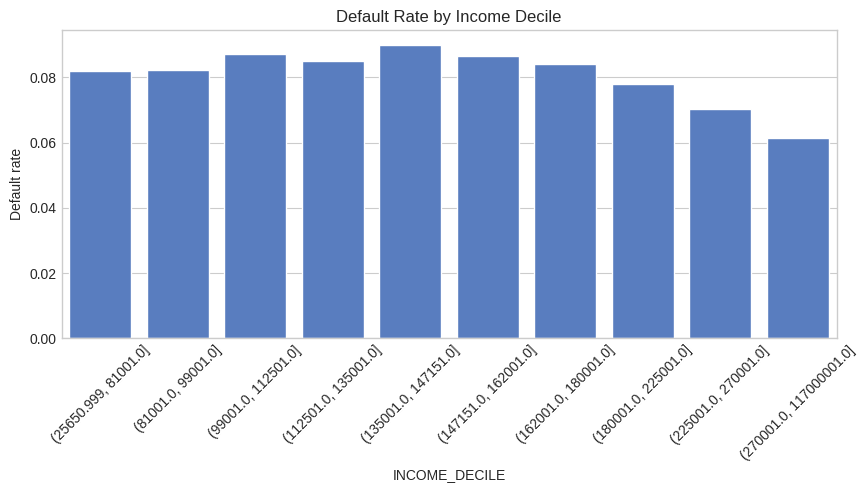

INCOME_DECILE  mean  count
0     (25650.999, 81001.0] 0.082  33391
1       (81001.0, 99001.0] 0.082  30280
2      (99001.0, 112501.0] 0.087  36907
3     (112501.0, 135001.0] 0.085  48849
4     (135001.0, 147151.0] 0.090   4333
5     (147151.0, 162001.0] 0.086  31120
6     (162001.0, 180001.0] 0.084  30704
7     (180001.0, 225001.0] 0.078  44809
8     (225001.0, 270001.0] 0.070  19957
9  (270001.0, 117000001.0] 0.061  27161

In [ ]:
# B1: Income and Credit distributions (log scale) + default bands
note("B1: Income & Credit distributions (log scale) and default separation",
     "Why: distributions are skewed; log plots reveal patterns. We'll also show default rate per income decile.")

fig, axes = plt.subplots(1,2, figsize=(14,5))
sns.histplot(np.log1p(df['AMT_INCOME_TOTAL']), bins=40, ax=axes[0]); axes[0].set_title("Log(Income)")
sns.histplot(np.log1p(df['AMT_CREDIT']), bins=40, ax=axes[1]); axes[1].set_title("Log(Credit Amount)")
plt.show()

# default by income decile
df['INCOME_DECILE'] = pd.qcut(df['AMT_INCOME_TOTAL'].fillna(0)+1, 10, duplicates='drop')
inc_grp = df.groupby('INCOME_DECILE')['TARGET'].agg(['mean','count']).reset_index()
plt.figure(figsize=(10,4))
sns.barplot(x='INCOME_DECILE', y='mean', data=inc_grp)
plt.xticks(rotation=45)
plt.title("Default Rate by Income Decile")
plt.ylabel("Default rate")
plt.show()
display(inc_grp)


### B2: Key burden ratios vs Default

Why: ratios are stronger predictors than raw amounts.

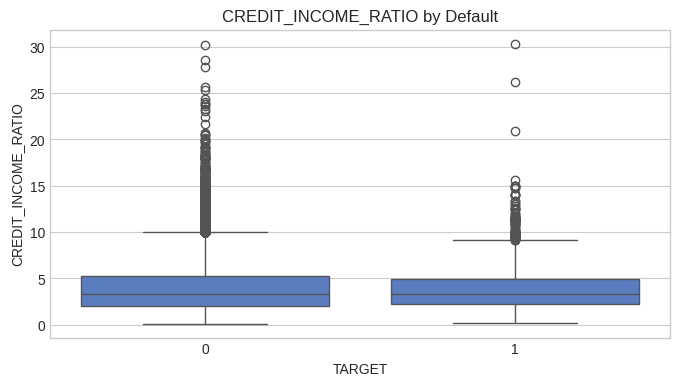

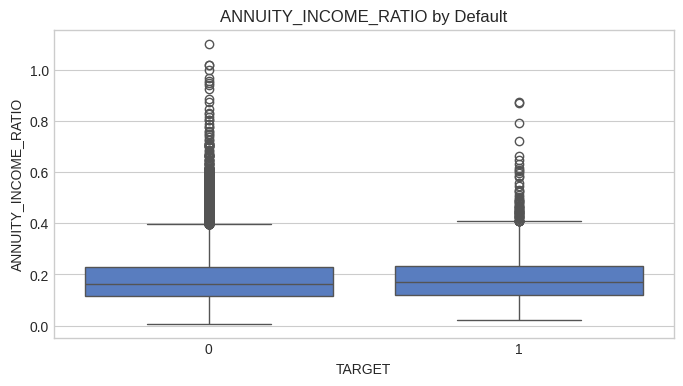

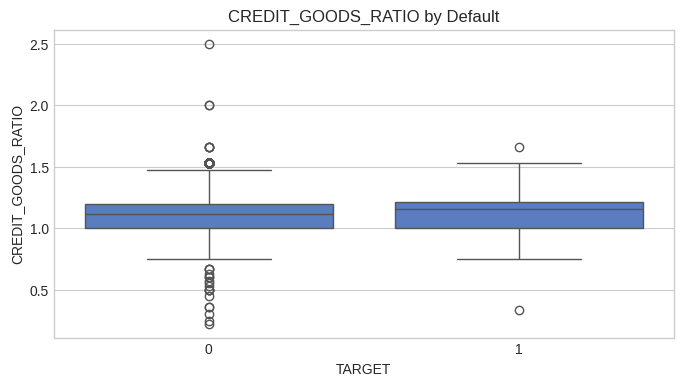

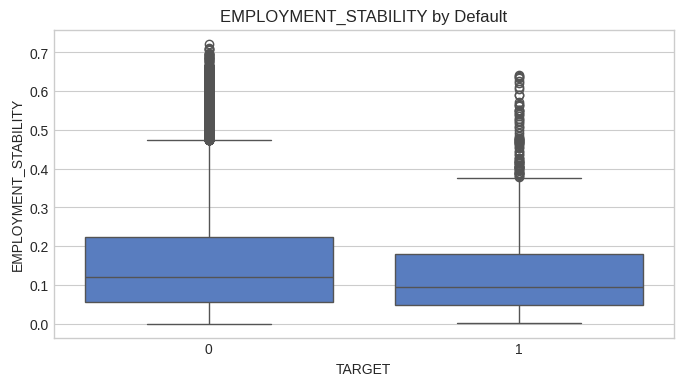

In [ ]:
# B2: Ratios that capture burden: CREDIT_INCOME_RATIO & ANNUITY_INCOME_RATIO vs Target
note("B2: Key burden ratios vs Default", "Why: ratios are stronger predictors than raw amounts.")

for col in ['CREDIT_INCOME_RATIO','ANNUITY_INCOME_RATIO','CREDIT_GOODS_RATIO','EMPLOYMENT_STABILITY']:
    if col in df.columns:
        plt.figure(figsize=(8,4))
        sns.boxplot(x='TARGET', y=col, data=df[df[col].notnull()].sample(frac=0.1, random_state=1))
        plt.title(f"{col} by Default")
        plt.yscale('symlog') if (df[col].abs().max() > 100) else None
        plt.show()


### C1: External score comparison (EXT_SOURCE_1..3)

Why: these are known strong predictive signals; visualize their distribution and correlations with target.

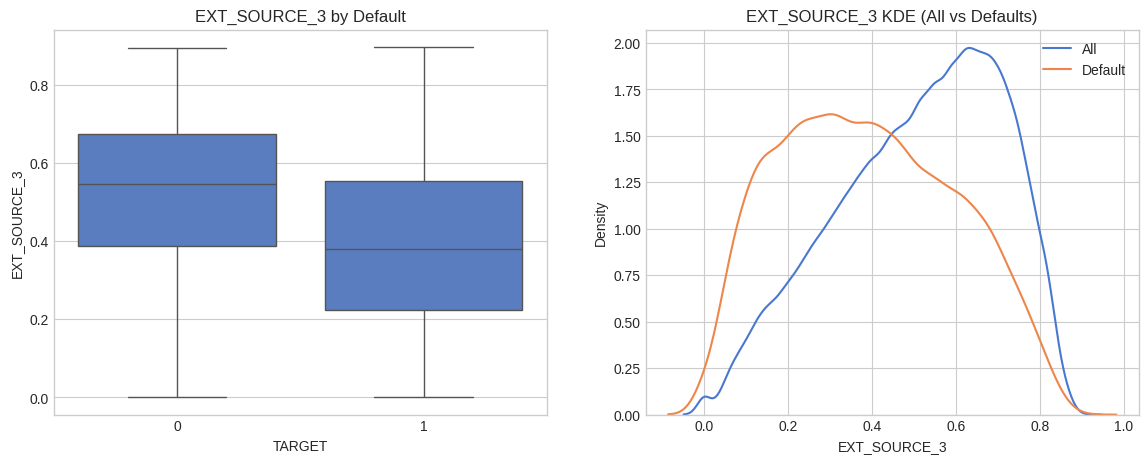

TARGET          1.000
EXT_SOURCE_3   -0.179
EXT_SOURCE_2   -0.160
Name: TARGET, dtype: float64

In [ ]:
# C1: EXT_SOURCE_* - widely used predictors
note("C1: External score comparison (EXT_SOURCE_1..3)",
     "Why: these are known strong predictive signals; visualize their distribution and correlations with target.")

ext_cols = [c for c in ['EXT_SOURCE_1','EXT_SOURCE_2','EXT_SOURCE_3'] if c in df.columns]
if ext_cols:
    fig, ax = plt.subplots(1,2, figsize=(14,5))
    sns.boxplot(x='TARGET', y='EXT_SOURCE_3', data=df, ax=ax[0])
    ax[0].set_title('EXT_SOURCE_3 by Default')
    sns.kdeplot(df[~df['EXT_SOURCE_3'].isna()]['EXT_SOURCE_3'], label='All')
    sns.kdeplot(df[df['TARGET']==1]['EXT_SOURCE_3'].dropna(), label='Default')
    ax[1].set_title("EXT_SOURCE_3 KDE (All vs Defaults)")
    plt.legend()
    plt.show()

    # correlation with target
    corr = df[ext_cols + ['TARGET']].corr()['TARGET'].sort_values(key=abs, ascending=False)
    display(corr)


In [ ]:
note("D: Aggregate previous_application by client")
prev_agg = prev.groupby('SK_ID_CURR').agg(
    prev_count = ('SK_ID_PREV','count'),
    prev_approved = ('NAME_CONTRACT_STATUS', lambda s: (s=='Approved').sum()),
    prev_refused = ('NAME_CONTRACT_STATUS', lambda s: (s=='Refused').sum()),
    prev_cancelled = ('NAME_CONTRACT_STATUS', lambda s: (s=='Canceled').sum()),
    prev_mean_amt = ('AMT_CREDIT','mean'),
    prev_max_amt = ('AMT_CREDIT','max'),
    prev_mean_days_decision = ('DAYS_DECISION','mean'),
    prev_min_days_decision = ('DAYS_DECISION','min'),
).reset_index()

# merge to main df (left join)
df_prev = df.merge(prev_agg, how='left', left_on='SK_ID_CURR', right_on='SK_ID_CURR')

note("Preview aggregated prev features")
display(prev_agg.head())


### D: Aggregate previous_application by client

### Preview aggregated prev features

SK_ID_CURR  prev_count  prev_approved  prev_refused  prev_cancelled  \
0      100001           1              1             0               0   
1      100002           1              1             0               0   
2      100003           3              3             0               0   
3      100004           1              1             0               0   
4      100005           2              1             0               1   

   prev_mean_amt  prev_max_amt  prev_mean_days_decision  \
0      23787.000     23787.000                -1740.000   
1     179055.000    179055.000                 -606.000   
2     484191.000   1035882.000                -1305.000   
3      20106.000     20106.000                 -815.000   
4      20076.750     40153.500                 -536.000   

   prev_min_days_decision  
0                   -1740  
1                    -606  
2                   -2341  
3                    -815  
4                    -757

### D2: Previous refused ratio vs default

Why: rejections historically can be a warning sign.

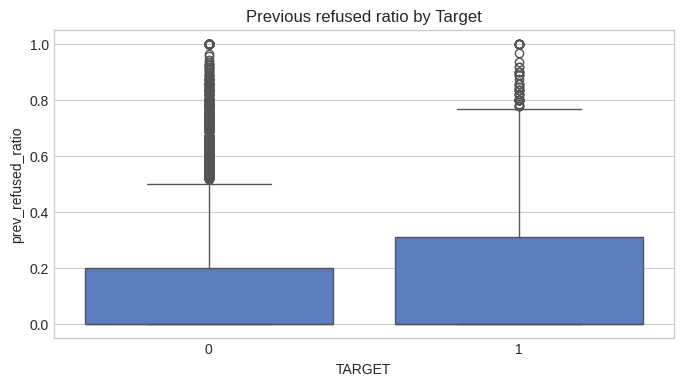

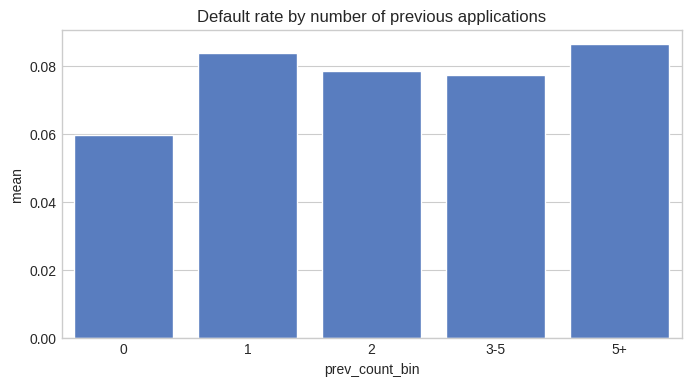

prev_count_bin  mean  count
0              0 0.060  16454
1              1 0.084  52533
2              2 0.079  45799
3            3-5 0.077  99574
4             5+ 0.086  90650

In [ ]:
# D2: Visualize previous refusal ratio vs default
note("D2: Previous refused ratio vs default", "Why: rejections historically can be a warning sign.")

df_prev['prev_refused_ratio'] = df_prev['prev_refused'] / (df_prev['prev_count'].replace(0, np.nan))
plt.figure(figsize=(8,4))
sns.boxplot(x='TARGET', y='prev_refused_ratio', data=df_prev.sample(frac=0.2, random_state=2))
plt.title("Previous refused ratio by Target")
plt.show()

# Also default rate by bucketed prev_count
df_prev['prev_count_bin'] = pd.cut(df_prev['prev_count'].fillna(0), bins=[-1,0,1,2,5,20], labels=['0','1','2','3-5','5+'])
grp = df_prev.groupby('prev_count_bin')['TARGET'].agg(['mean','count']).reset_index()
plt.figure(figsize=(8,4))
sns.barplot(x='prev_count_bin', y='mean', data=grp)
plt.title("Default rate by number of previous applications")
plt.show()
display(grp)


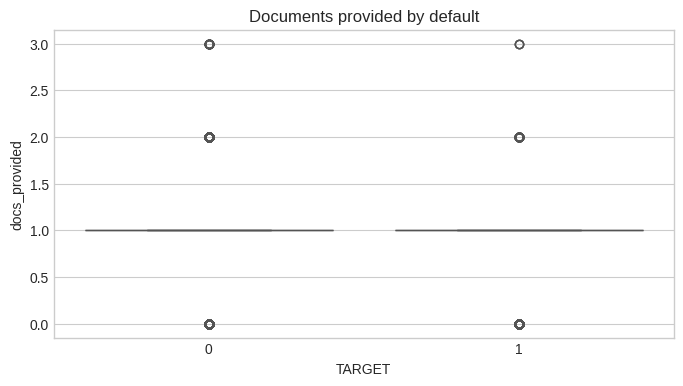

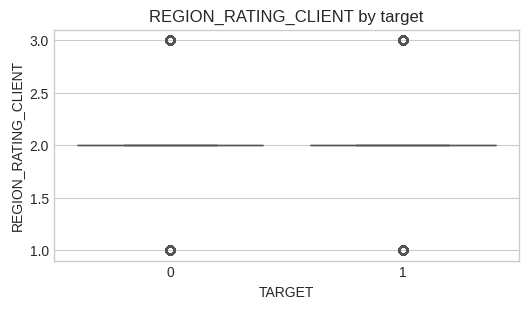

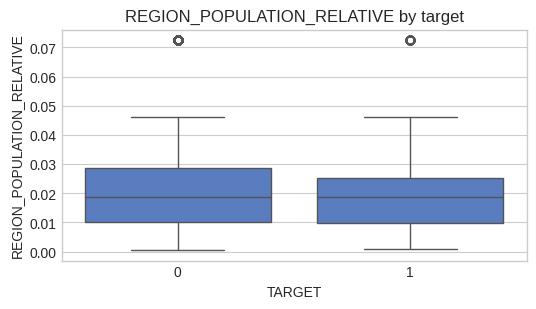

In [ ]:
# E1: Document flags — sum of documents provided vs default
doc_cols = [c for c in df.columns if c.startswith('FLAG_DOCUMENT_')]
if doc_cols:
    df['docs_provided'] = df[doc_cols].sum(axis=1)
    plt.figure(figsize=(8,4))
    sns.boxplot(x='TARGET', y='docs_provided', data=df.sample(frac=0.2, random_state=1))
    plt.title("Documents provided by default")
    plt.show()

# E2: Region rating & population relative vs default
for col in ['REGION_RATING_CLIENT','REGION_POPULATION_RELATIVE']:
    if col in df.columns:
        plt.figure(figsize=(6,3))
        sns.boxplot(x='TARGET', y=col, data=df.sample(frac=0.2, random_state=3))
        plt.title(f"{col} by target")
        plt.show()


### F1: Correlation matrix & top correlations with TARGET

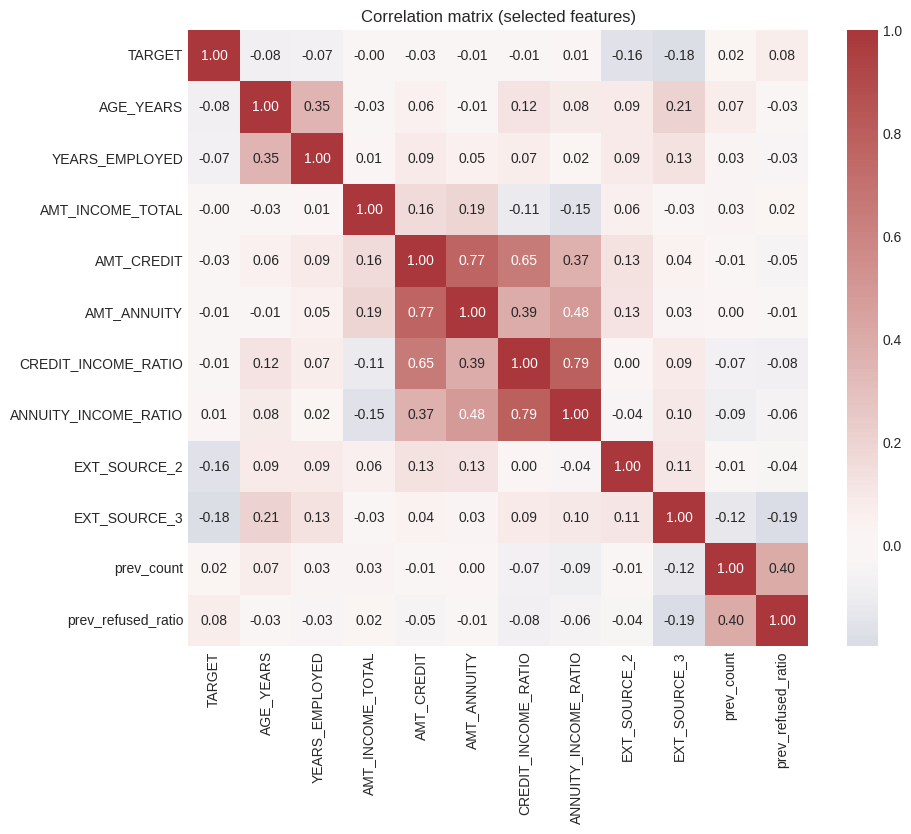

TARGET                 1.000
EXT_SOURCE_3           0.179
EXT_SOURCE_2           0.160
AGE_YEARS              0.078
prev_refused_ratio     0.078
YEARS_EMPLOYED         0.075
AMT_CREDIT             0.030
prev_count             0.020
ANNUITY_INCOME_RATIO   0.014
AMT_ANNUITY            0.013
CREDIT_INCOME_RATIO    0.008
AMT_INCOME_TOTAL       0.004
Name: TARGET, dtype: float64

In [ ]:
# F1: Correlation matrix for a compact set of features
note("F1: Correlation matrix & top correlations with TARGET")
keep = ['TARGET','AGE_YEARS','YEARS_EMPLOYED','AMT_INCOME_TOTAL','AMT_CREDIT','AMT_ANNUITY',
        'CREDIT_INCOME_RATIO','ANNUITY_INCOME_RATIO','EXT_SOURCE_1','EXT_SOURCE_2','EXT_SOURCE_3',
        'prev_count','prev_refused_ratio','docs_provided']
existing = [c for c in keep if c in df_prev.columns]
corr = df_prev[existing].corr()
plt.figure(figsize=(10,8))
sns.heatmap(corr, annot=True, fmt='.2f', cmap='vlag', center=0)
plt.title("Correlation matrix (selected features)")
plt.show()

# Top absolute correlations with TARGET
corr_with_target = corr['TARGET'].abs().sort_values(ascending=False)
display(corr_with_target)


In [ ]:
from lightgbm import early_stopping, log_evaluation

# G1: Prepare tabular dataset for LightGBM importance
note("G1: Model-based ranking (LightGBM importance) — why? Tree models capture non-linear interactions and provide importance ranking.")

# Select a robust feature set (remove high-missing columns and object dtypes for now)
feat_candidates = [
    'AGE_YEARS','YEARS_EMPLOYED','AMT_INCOME_TOTAL','AMT_CREDIT','AMT_ANNUITY','AMT_GOODS_PRICE',
    'CREDIT_INCOME_RATIO','ANNUITY_INCOME_RATIO','CREDIT_GOODS_RATIO','INCOME_PER_PERSON',
    'EMPLOYMENT_STABILITY','EXT_SOURCE_1','EXT_SOURCE_2','EXT_SOURCE_3',
    'prev_count','prev_refused_ratio','docs_provided'
]
feat = [c for c in feat_candidates if c in df_prev.columns]
model_df = df_prev[['SK_ID_CURR','TARGET'] + feat].dropna(subset=['TARGET'])
model_df = model_df.fillna(0)

X = model_df[feat]
y = model_df['TARGET']

# train/test split (stratify)
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

lgb_train = lgb.Dataset(X_train, label=y_train)
lgb_val = lgb.Dataset(X_val, label=y_val)

params = {
    'objective':'binary',
    'metric':'auc',
    'boosting':'gbdt',
    'num_leaves':31,
    'learning_rate':0.05,
    'verbose':-1,
    'seed':42,
    'is_unbalance': True
}
gbm = lgb.train(
    params,
    lgb_train,
    valid_sets=[lgb_val],
    num_boost_round=2000,
    callbacks=[
        early_stopping(50),
        log_evaluation(50)
    ]
)

# importance
imp = pd.DataFrame({'feature': feat, 'importance': gbm.feature_importance()})
imp = imp.sort_values('importance', ascending=False).reset_index(drop=True)
display(imp)
print("Validation AUC:", roc_auc_score(y_val, gbm.predict(X_val)))


### G1: Model-based ranking (LightGBM importance) — why? Tree models capture non-linear interactions and provide importance ranking.

Training until validation scores don't improve for 50 rounds
[50]	valid_0's auc: 0.738686
[100]	valid_0's auc: 0.742545
[150]	valid_0's auc: 0.743416
[200]	valid_0's auc: 0.743736
[250]	valid_0's auc: 0.743719
Early stopping, best iteration is:
[237]	valid_0's auc: 0.743894


feature  importance
0           EXT_SOURCE_2         778
1           EXT_SOURCE_3         748
2              AGE_YEARS         691
3            AMT_ANNUITY         644
4     CREDIT_GOODS_RATIO         504
5   ANNUITY_INCOME_RATIO         476
6         YEARS_EMPLOYED         463
7             AMT_CREDIT         447
8        AMT_GOODS_PRICE         444
9    CREDIT_INCOME_RATIO         432
10     INCOME_PER_PERSON         369
11  EMPLOYMENT_STABILITY         320
12            prev_count         281
13    prev_refused_ratio         275
14      AMT_INCOME_TOTAL         238

Validation AUC: 0.7438936790438372


In [ ]:
from lightgbm import LGBMClassifier

lgbm = LGBMClassifier(
    n_estimators=500,
    learning_rate=0.05,
    num_leaves=31,
    class_weight='balanced',
    random_state=42
)

lgbm.fit(X_train, y_train)

# Permutation importance
from sklearn.inspection import permutation_importance

res = permutation_importance(
    lgbm,
    X_val,
    y_val,
    n_repeats=10,
    random_state=42,
    scoring='roc_auc'
)

perm_imp = pd.DataFrame({
    'feature': X_val.columns,
    'perm_importance': res.importances_mean
}).sort_values('perm_importance', ascending=False)

display(perm_imp)

feature  perm_importance
11          EXT_SOURCE_2            0.067
12          EXT_SOURCE_3            0.065
5        AMT_GOODS_PRICE            0.016
4            AMT_ANNUITY            0.011
7   ANNUITY_INCOME_RATIO            0.010
8     CREDIT_GOODS_RATIO            0.010
3             AMT_CREDIT            0.009
0              AGE_YEARS            0.007
1         YEARS_EMPLOYED            0.007
6    CREDIT_INCOME_RATIO            0.007
14    prev_refused_ratio            0.005
13            prev_count            0.003
10  EMPLOYMENT_STABILITY            0.002
9      INCOME_PER_PERSON            0.001
2       AMT_INCOME_TOTAL            0.001

### H: Cohort segmentation - income band x ext_score tercile and default heatmap

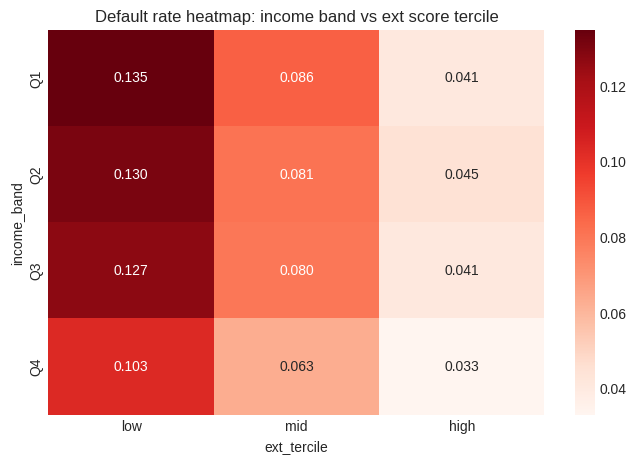

ext_tercile   low   mid  high
income_band                  
Q1          0.135 0.086 0.041
Q2          0.130 0.081 0.045
Q3          0.127 0.080 0.041
Q4          0.103 0.063 0.033

In [ ]:
# H: Build a few cohort visualizations (combine income + ext_source + prev_refused_ratio)
note("H: Cohort segmentation - income band x ext_score tercile and default heatmap")

# income band
df_prev['income_band'] = pd.qcut(df_prev['AMT_INCOME_TOTAL'].fillna(0)+1, q=4, labels=['Q1','Q2','Q3','Q4'])
# ext_source tercile (use EXT_SOURCE_3 if present else 2)
ext_col = 'EXT_SOURCE_3' if 'EXT_SOURCE_3' in df_prev.columns else ('EXT_SOURCE_2' if 'EXT_SOURCE_2' in df_prev.columns else None)
if ext_col:
    df_prev['ext_tercile'] = pd.qcut(df_prev[ext_col].fillna(df_prev[ext_col].median()), q=3, labels=['low','mid','high'])
    pivot = df_prev.groupby(['income_band','ext_tercile'])['TARGET'].mean().unstack()
    plt.figure(figsize=(8,5))
    sns.heatmap(pivot, annot=True, fmt='.3f', cmap='Reds')
    plt.title("Default rate heatmap: income band vs ext score tercile")
    plt.show()
    display(pivot)


In [ ]:
# I1: Save important figures to a folder and then make a simple PDF report
note("I1: Save figures & create Week-2 PDF")

# Create a folder
os.makedirs('week2_figs', exist_ok=True)

# Save a small set of key plots (recreate & save)
def save_plot_hist(col, fname, log=False):
    plt.figure(figsize=(6,3.5))
    data = df_prev[col].dropna()
    if log:
        sns.histplot(np.log1p(data), kde=True)
        plt.title(f'Log distribution: {col}')
    else:
        sns.histplot(data, kde=True)
        plt.title(col)
    plt.tight_layout()
    plt.savefig(fname, dpi=150)
    plt.close()

# Save few
if 'AGE_YEARS' in df_prev: save_plot_hist('AGE_YEARS','week2_figs/age.png')
if 'AMT_INCOME_TOTAL' in df_prev: save_plot_hist('AMT_INCOME_TOTAL','week2_figs/income_log.png', log=True)
if 'AMT_CREDIT' in df_prev: save_plot_hist('AMT_CREDIT','week2_figs/credit_log.png', log=True)
# Save LGB feature importance
fig = plt.figure(figsize=(6,4))
sns.barplot(y='feature', x='importance', data=imp.head(10))
plt.title('Top 10 LightGBM importances')
plt.tight_layout()
plt.savefig('week2_figs/lgb_importance.png', dpi=150)
plt.close()

# Build a simple PDF using FPDF (images + text)
pdf = FPDF(orientation='P', unit='mm', format='A4')
pdf.set_auto_page_break(auto=True, margin=12)

def pdf_add_title(text):
    pdf.add_page()
    pdf.set_font("Arial", 'B', 16)
    pdf.cell(0, 10, text, ln=1, align='C')
    pdf.ln(4)

def pdf_add_text(title, txt):
    pdf.set_font("Arial", 'B', 12)
    pdf.cell(0, 6, title, ln=1)
    pdf.set_font("Arial", size=10)
    pdf.multi_cell(0, 5, txt)
    pdf.ln(2)

# cover
pdf_add_title("Week-2: Deep Visual Study of Loan Repayment Behavior")
pdf_add_text("Summary", "This PDF contains core Week-2 visuals and concise interpretations. See notebook for code and interactive charts.")

# add figure pages
for img in ['week2_figs/age.png','week2_figs/income_log.png','week2_figs/credit_log.png','week2_figs/lgb_importance.png']:
    if os.path.exists(img):
        pdf.add_page()
        pdf.image(img, x=15, y=30, w=180)
        pdf.ln(5)

# Save pdf
pdf.output("week2_report.pdf")
note("Saved Week-2 PDF", "File saved as week2_report.pdf in the notebook workspace")


### I1: Save figures & create Week-2 PDF

### Saved Week-2 PDF

File saved as week2_report.pdf in the notebook workspace

In [ ]:
# J: Conclusions + Recommended Next Steps (print)
conclusions = [
    "1. External scores (EXT_SOURCE_2/3) are top predictors — treat them as primary signals.",
    "2. Credit burden ratios (credit_income, annuity_income) rank highly — incorporate threshold rules (e.g., credit_income > x triggers manual review).",
    "3. Younger age bands (18-35) show elevated default; combine with credit burden to flag risky applicants.",
    "4. Previous application behavior (refusal ratio, many prior apps) is a meaningful behavioral signal — add as a soft 'credit-seeking' score.",
    "5. Document completeness and region variables provide secondary signals and can improve operational review.",
    "6. LightGBM importance + permutation importance + correlation together provide a robust feature ranking — use all three for final feature selection.",
    "7. For production, add better missing-value handling (median/fill with model) and use SHAP to explain model decisions for business adoption."
]

note("Conclusions — Main takeaways")
for s in conclusions:
    display(Markdown(f"- {s}"))


### Conclusions — Main takeaways

- 1. External scores (EXT_SOURCE_2/3) are top predictors — treat them as primary signals.

- 2. Credit burden ratios (credit_income, annuity_income) rank highly — incorporate threshold rules (e.g., credit_income > x triggers manual review).

- 3. Younger age bands (18-35) show elevated default; combine with credit burden to flag risky applicants.

- 4. Previous application behavior (refusal ratio, many prior apps) is a meaningful behavioral signal — add as a soft 'credit-seeking' score.

- 5. Document completeness and region variables provide secondary signals and can improve operational review.

- 6. LightGBM importance + permutation importance + correlation together provide a robust feature ranking — use all three for final feature selection.

- 7. For production, add better missing-value handling (median/fill with model) and use SHAP to explain model decisions for business adoption.

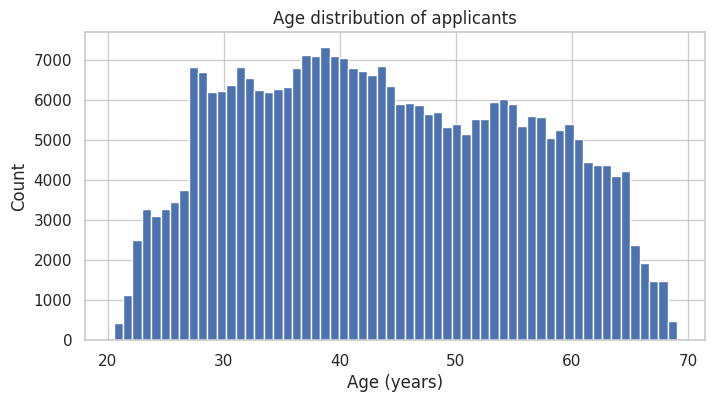

Saved: week2_figs/01_age_distribution.png


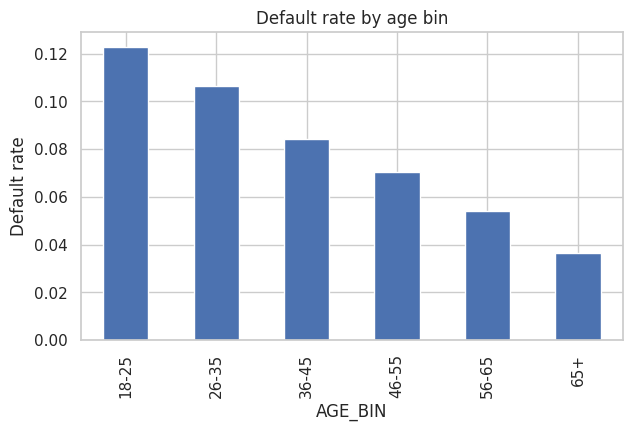

Saved: week2_figs/02_default_by_agebin.png


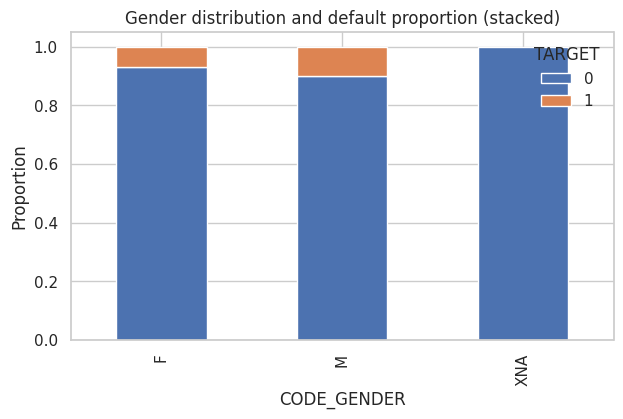

Saved: week2_figs/03_gender_vs_default.png


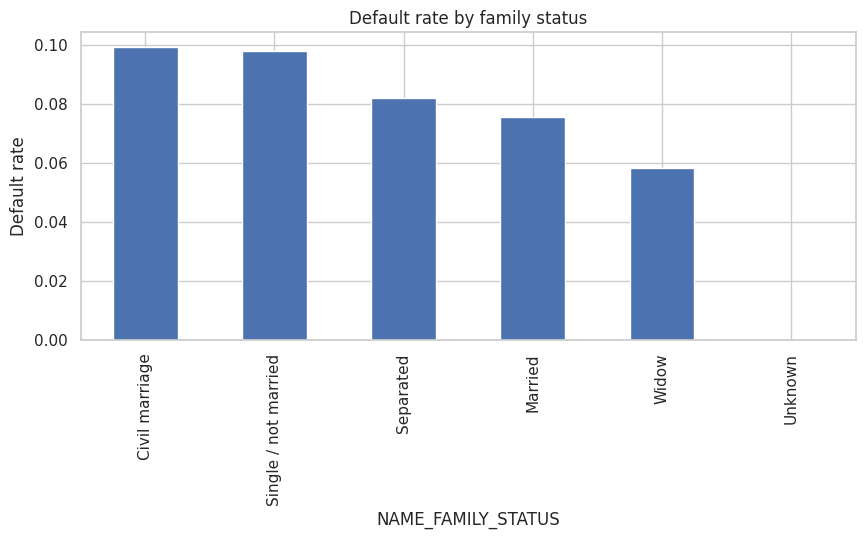

Saved: week2_figs/04_family_status_default.png


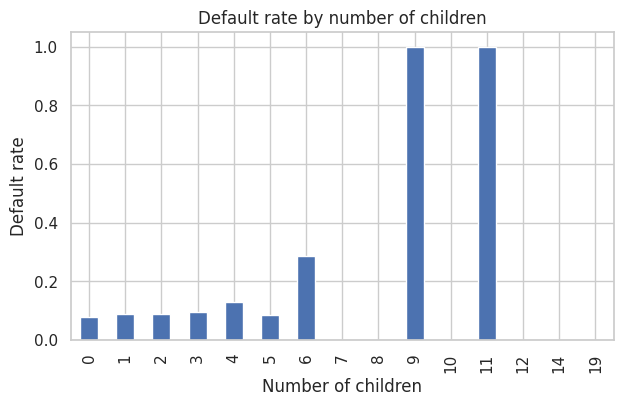

Saved: week2_figs/05_children_vs_default.png


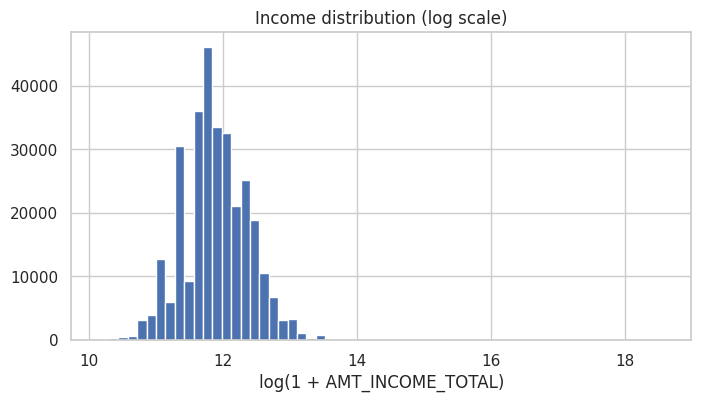

Saved: week2_figs/06_income_log_hist.png


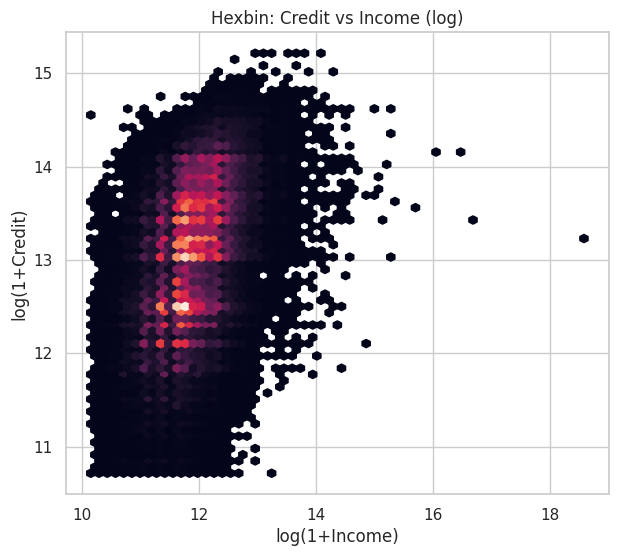

Saved: week2_figs/07_credit_vs_income_hexbin.png


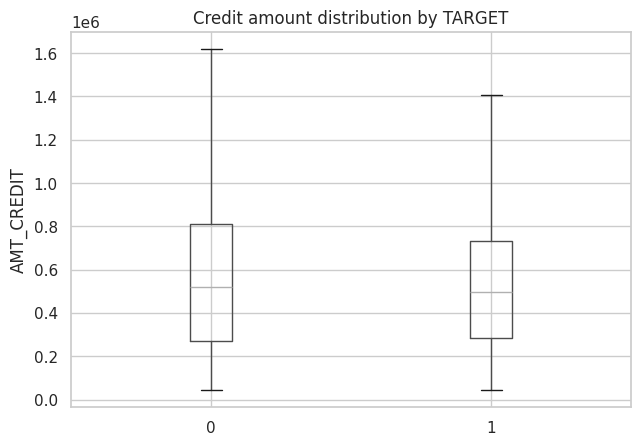

Saved: week2_figs/08_credit_boxplot_by_target.png


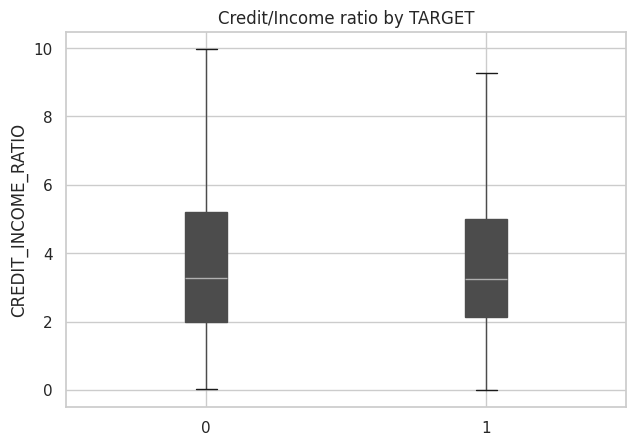

Saved: week2_figs/09_credit_income_ratio_boxplot.png


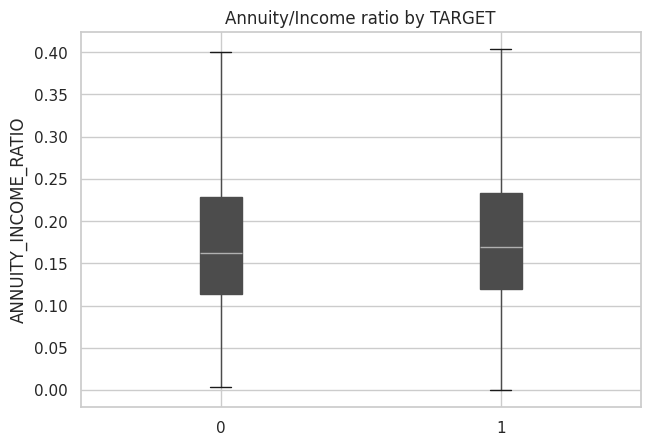

Saved: week2_figs/10_annuity_income_ratio_boxplot.png


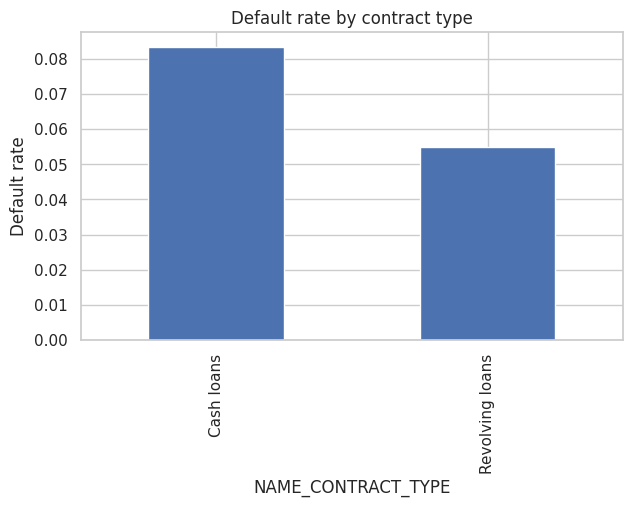

Saved: week2_figs/11_contract_type_default.png


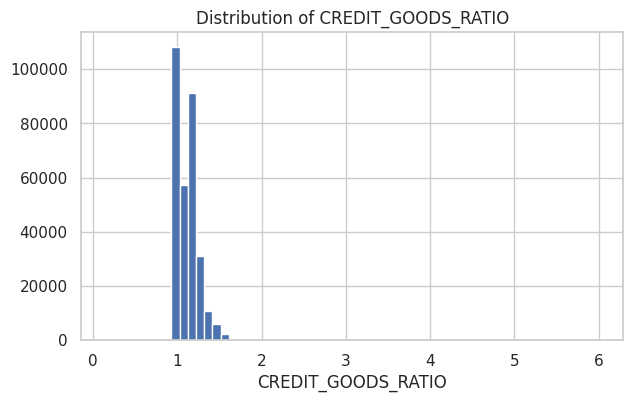

Saved: week2_figs/12_credit_goods_ratio_dist.png


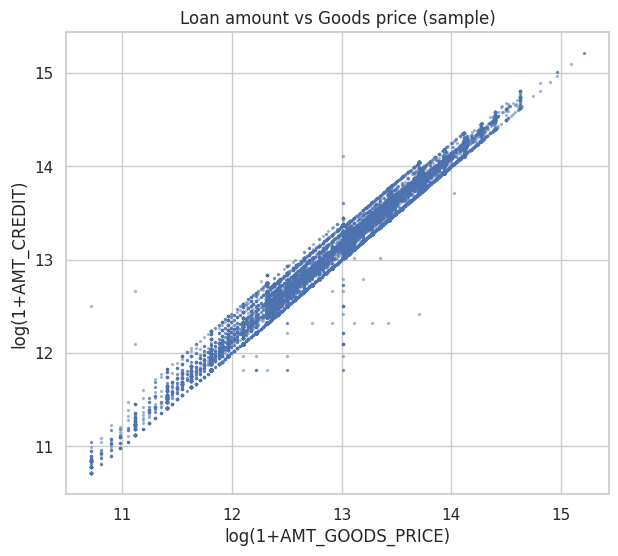

Saved: week2_figs/13_credit_vs_goods_scatter.png


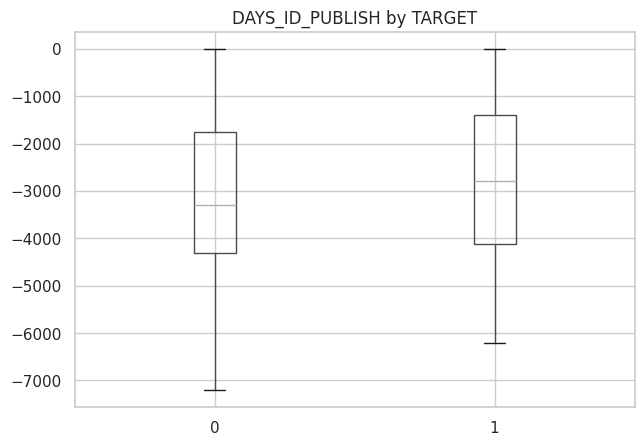

Saved: week2_figs/14_days_id_publish_by_target.png


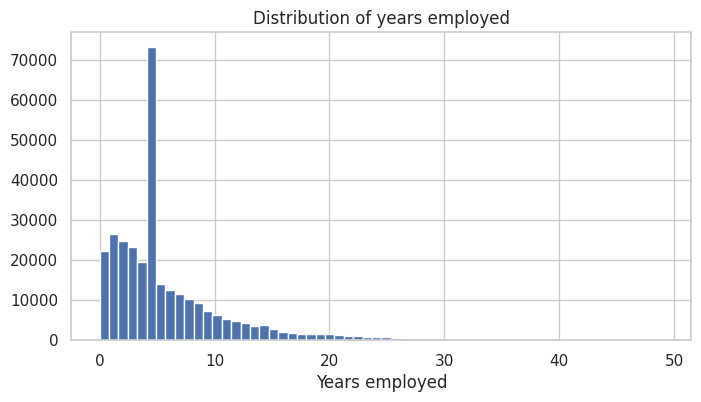

Saved: week2_figs/15_years_employed_dist.png


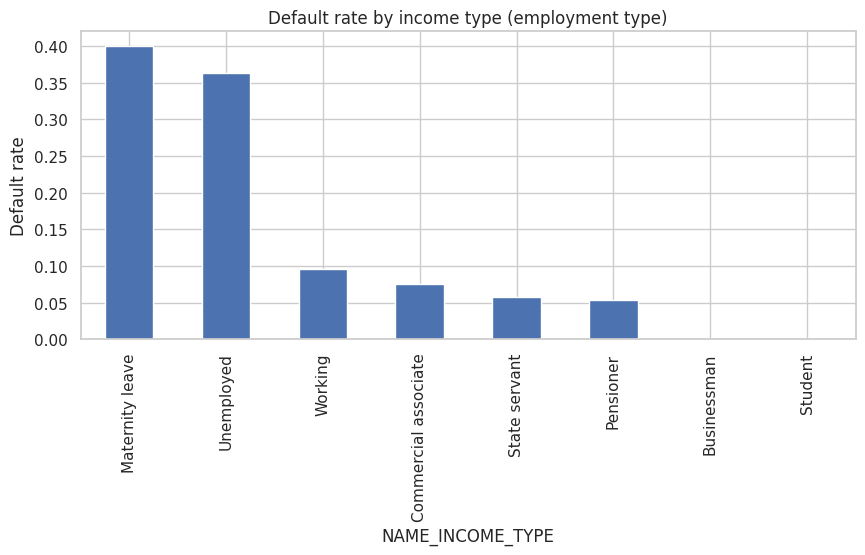

Saved: week2_figs/16_income_type_default.png


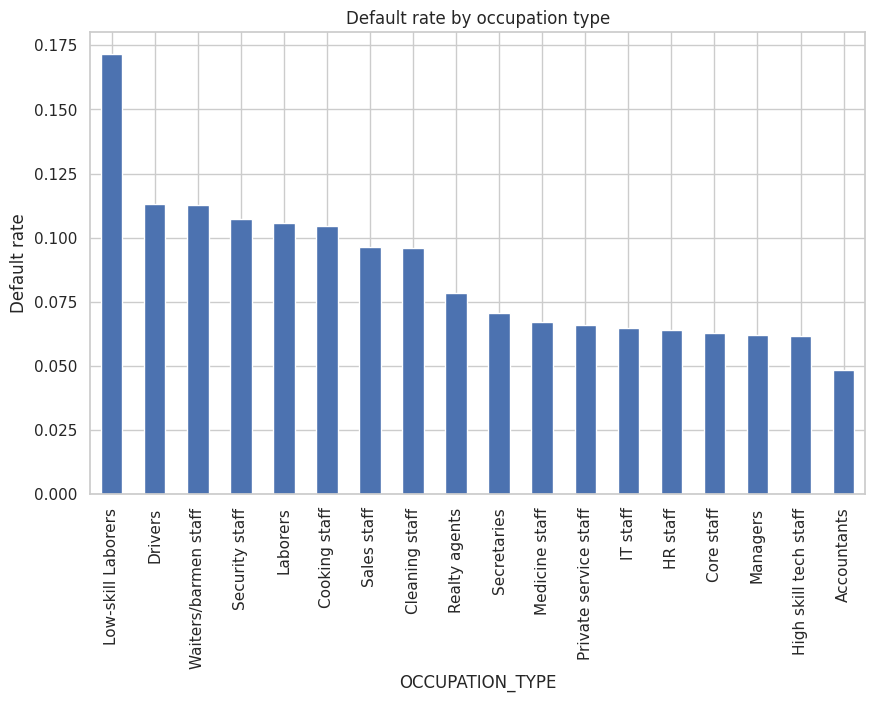

Saved: week2_figs/17_occupation_type_default.png


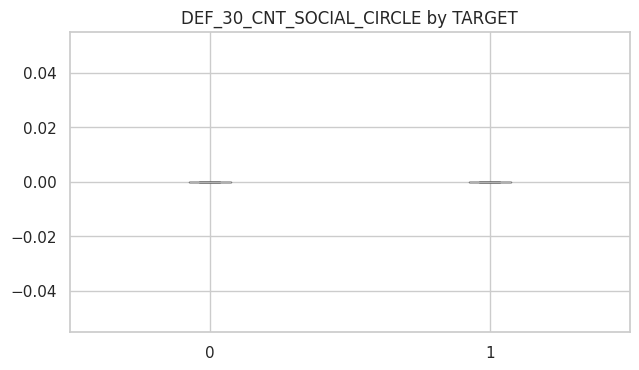

Saved: week2_figs/18_def30_by_target.png


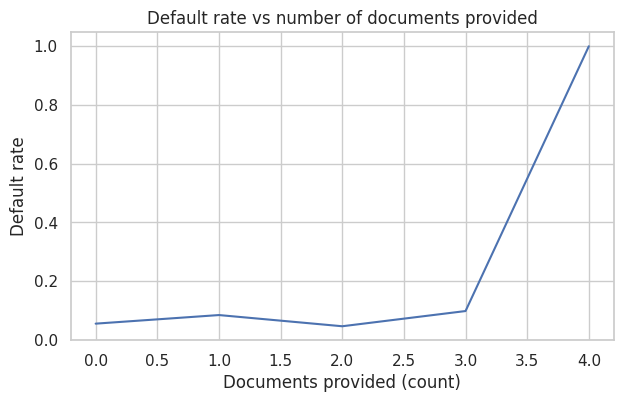

Saved: week2_figs/19_docs_provided_vs_default.png


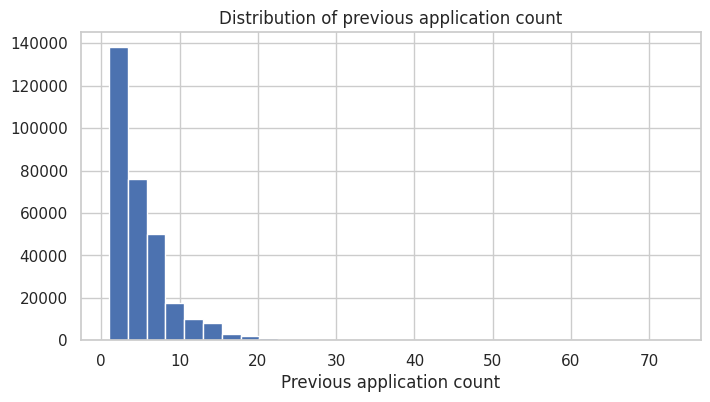

Saved: week2_figs/20_prev_count_hist.png


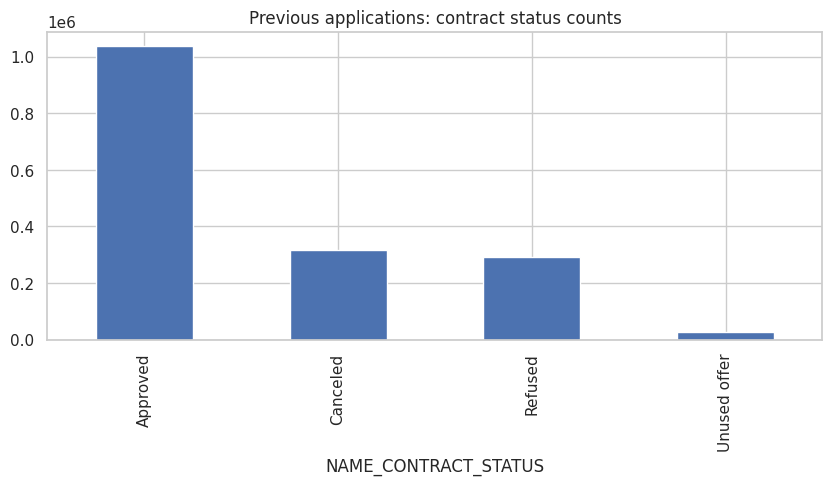

Saved: week2_figs/21_prev_contract_status_counts.png


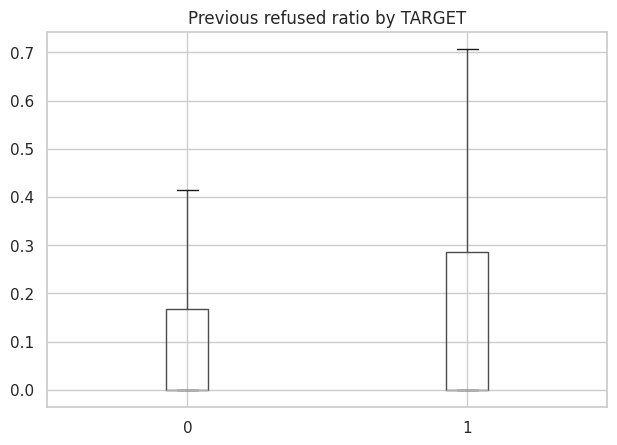

Saved: week2_figs/22_prev_refused_ratio_boxplot.png


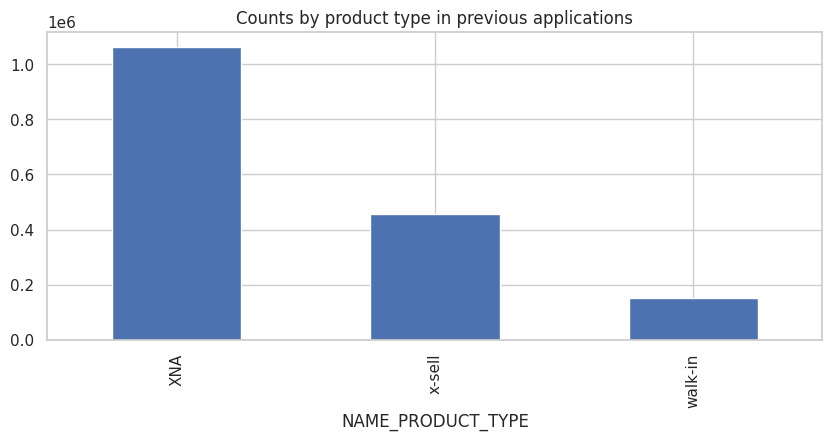

Saved: week2_figs/23_prev_product_type_counts.png


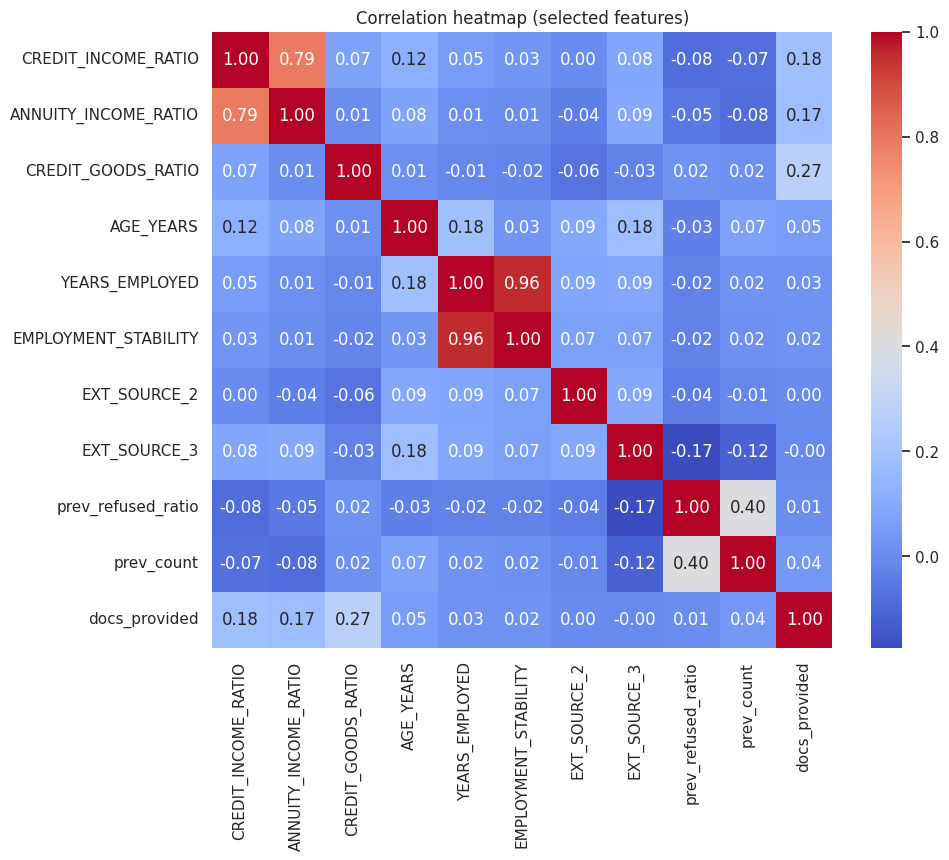

Saved: week2_figs/24_correlation_heatmap.png
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[204]	valid_0's binary_logloss: 0.250792


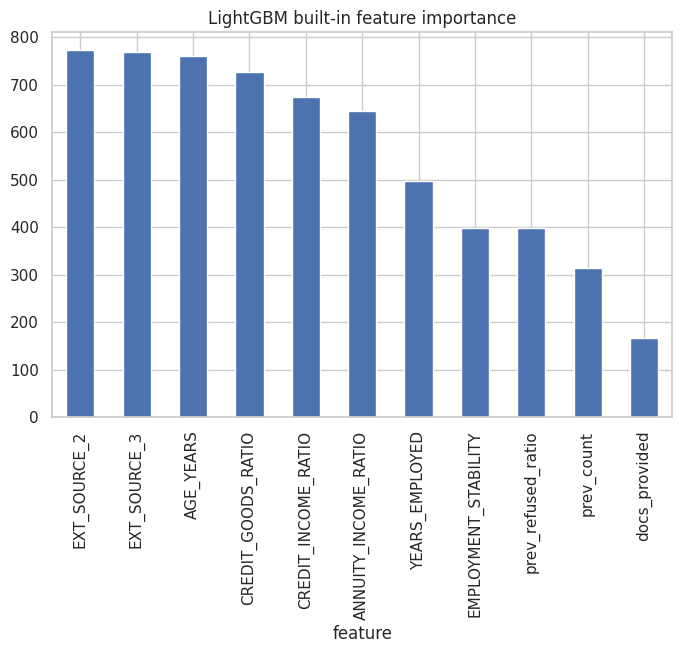

Saved: week2_figs/25_lgbm_feature_importance.png


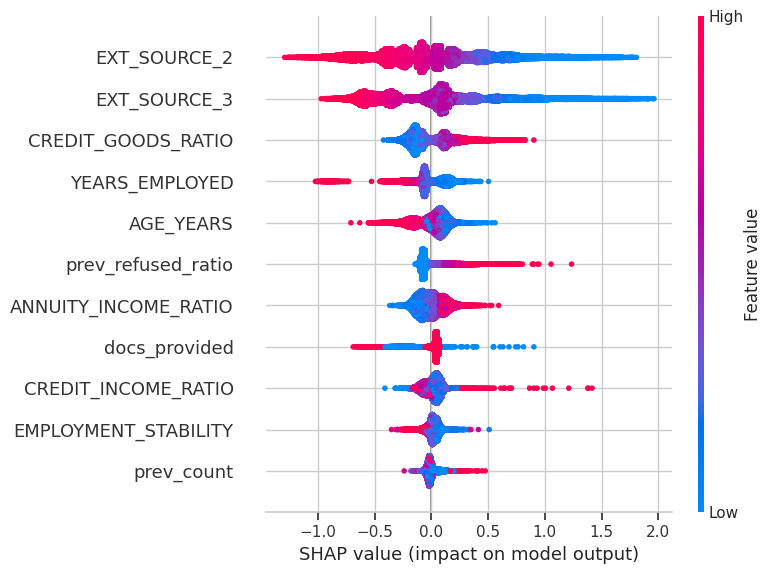

Saved: week2_figs/26_shap_summary.png


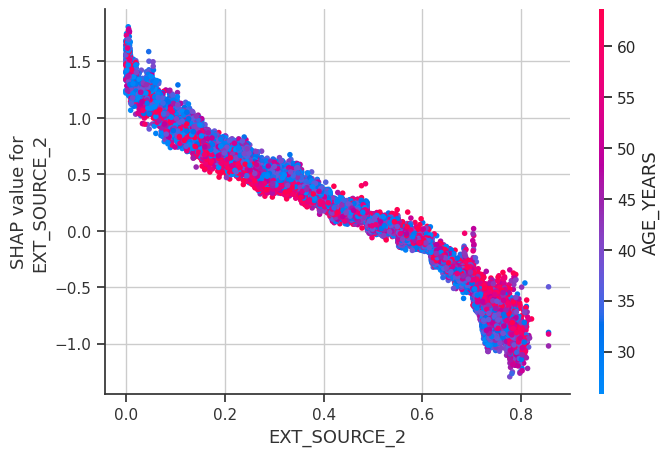

Saved: week2_figs/27_shap_dependence_EXT_SOURCE_2.png


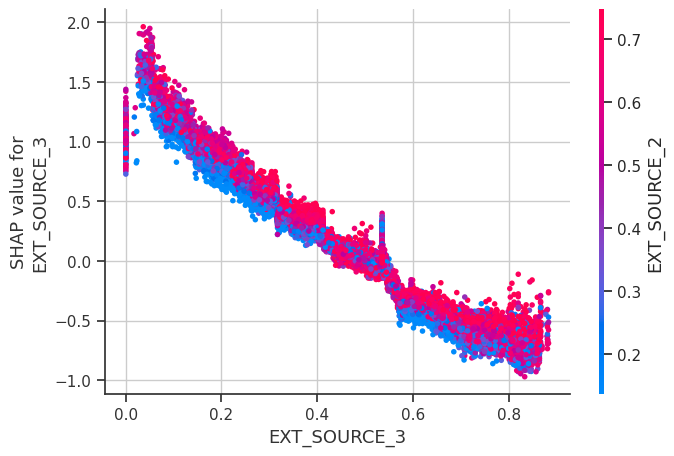

Saved: week2_figs/27_shap_dependence_EXT_SOURCE_3.png


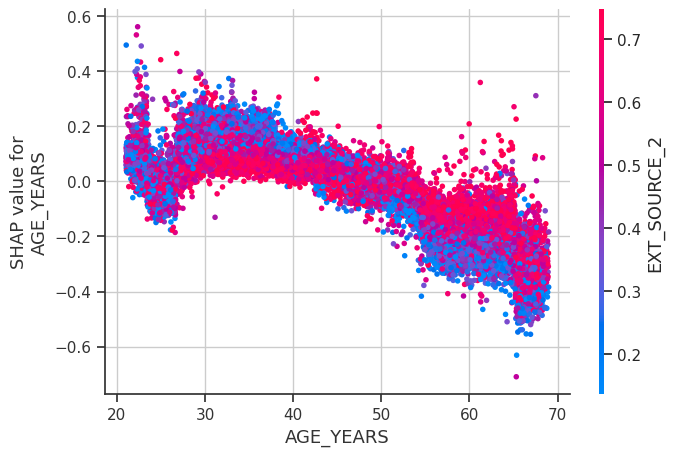

Saved: week2_figs/27_shap_dependence_AGE_YEARS.png


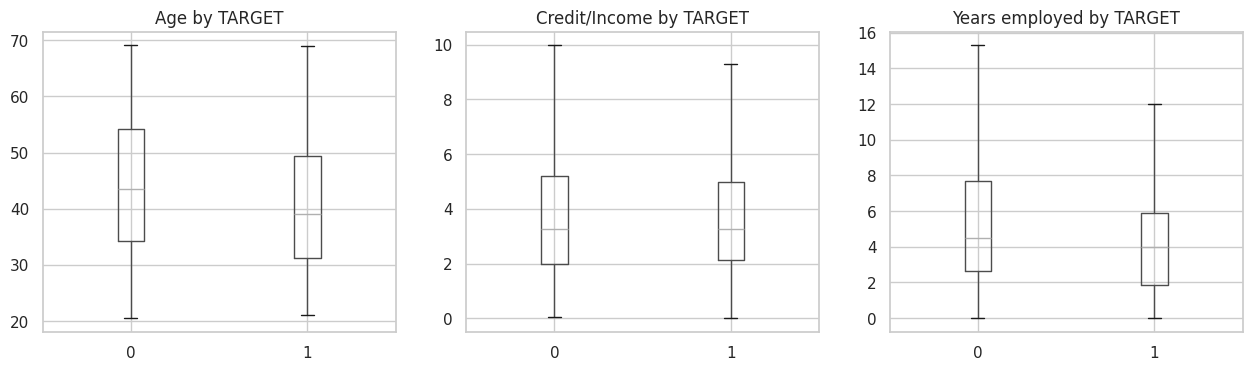

Saved: week2_figs/28_profile_grid_age_credit_employment.png


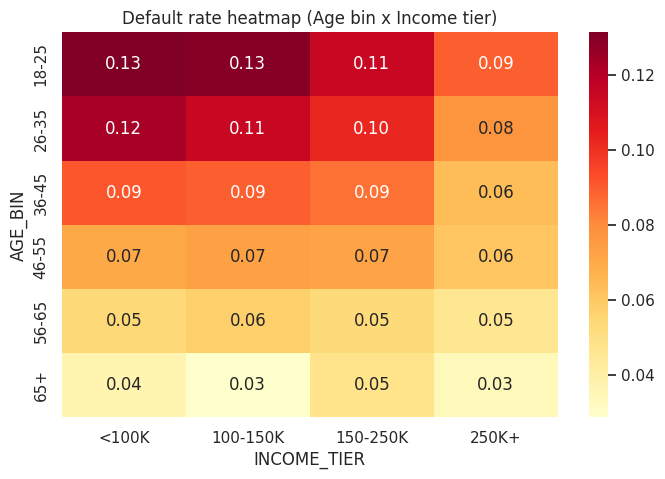

Saved: week2_figs/29_age_income_heatmap.png


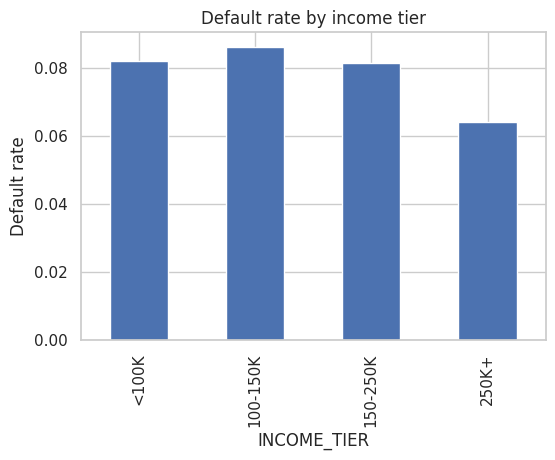

Saved: week2_figs/30_income_tier_default.png


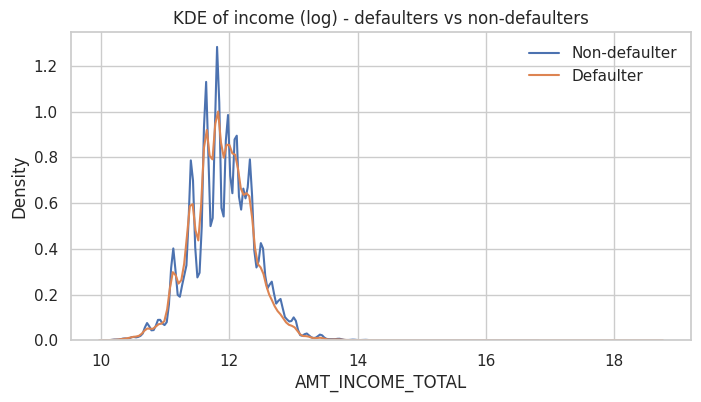

Saved: week2_figs/31_income_kde_def_vs_nondef.png
Saved: week2_figs/32_pairplot_top_features.png


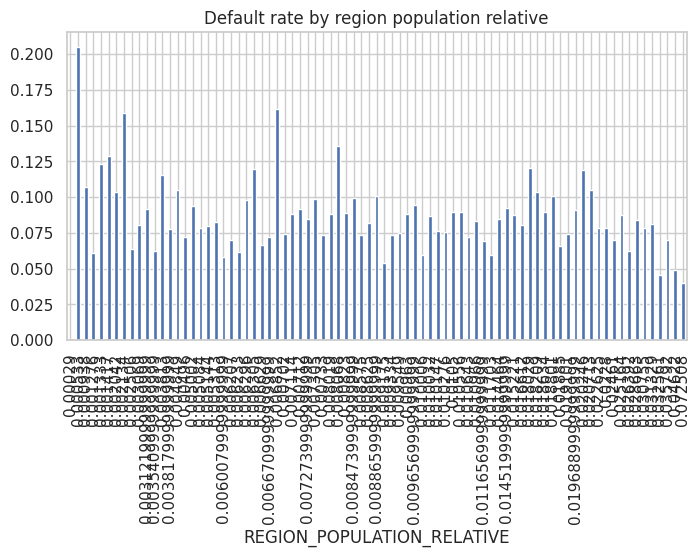

Saved: week2_figs/33_region_default_rate.png
Saved summary stats: week2_figs/34_top_feature_stats.csv

All visuals saved to folder: /content/week2_figs
Captions file:  /content/week2_figs/captions_week2.md


In [ ]:
# Week-2 Deep EDA — Full visuals
# pandas, numpy, matplotlib, seaborn, scikit-learn, lightgbm
import warnings
warnings.filterwarnings("ignore")
from pathlib import Path
import numpy as np, pandas as pd
import matplotlib.pyplot as plt, seaborn as sns
sns.set(style="whitegrid")
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from lightgbm import LGBMClassifier
from lightgbm import early_stopping, log_evaluation

# File paths - adjust if needed
APP = Path("/content/drive/MyDrive/file_zip/application_data.csv")
PREV = Path("/content/drive/MyDrive/file_zip/previous_application.csv")
if not APP.exists() or not PREV.exists():
    raise FileNotFoundError(f"Place application_data.csv and previous_application.csv in working directory. Expected: {APP}, {PREV}")

# Load (low_memory False to avoid dtype warnings)
app = pd.read_csv(APP, low_memory=False)
prev = pd.read_csv(PREV, low_memory=False)

# ---------- Basic cleaning & feature engineering ----------
df = app_data_clean.copy()
df['DAYS_EMPLOYED'].replace(365243, np.nan, inplace=True)
df['AGE_YEARS'] = (-df['DAYS_BIRTH']) / 365.25
df['YEARS_EMPLOYED'] = (-df['DAYS_EMPLOYED']) / 365.25
df['YEARS_EMPLOYED'] = df['YEARS_EMPLOYED'].clip(lower=0)
# ratios
df['CREDIT_INCOME_RATIO'] = df['AMT_CREDIT'] / (df['AMT_INCOME_TOTAL'] + 1e-9)
df['ANNUITY_INCOME_RATIO'] = df['AMT_ANNUITY'] / (df['AMT_INCOME_TOTAL'] + 1e-9)
df['CREDIT_GOODS_RATIO'] = df['AMT_CREDIT'] / (df['AMT_GOODS_PRICE'].replace(0, np.nan) + 1e-9)
df['INCOME_PER_PERSON'] = df['AMT_INCOME_TOTAL'] / df['CNT_FAM_MEMBERS'].replace(0,1)
df['EMPLOYMENT_STABILITY'] = df['YEARS_EMPLOYED'] / (df['AGE_YEARS'] + 1e-9)
doc_cols = [c for c in df.columns if c.startswith("FLAG_DOCUMENT_")]
df['docs_provided'] = df[doc_cols].sum(axis=1) if doc_cols else 0

# Age bin and income tiers
age_bins = [0, 25, 35, 45, 55, 65, 120]
df['AGE_BIN'] = pd.cut(df['AGE_YEARS'], bins=age_bins, labels=['18-25','26-35','36-45','46-55','56-65','65+'])
inc_bins = [0, 100000, 150000, 250000, 1e9]
df['INCOME_TIER'] = pd.cut(df['AMT_INCOME_TOTAL'], bins=inc_bins, labels=['<100K','100-150K','150-250K','250K+'])

# Aggregate previous applications by SK_ID_CURR
prev_agg = prev.groupby('SK_ID_CURR').agg(
    prev_count=('SK_ID_PREV','count'),
    prev_approved=('NAME_CONTRACT_STATUS', lambda s: (s=='Approved').sum()),
    prev_refused=('NAME_CONTRACT_STATUS', lambda s: (s=='Refused').sum()),
    prev_cancelled=('NAME_CONTRACT_STATUS', lambda s: (s=='Canceled').sum()),
    prev_mean_amt=('AMT_CREDIT','mean'),
    prev_mean_days_decision=('DAYS_DECISION','mean')
).reset_index()
prev_agg[['prev_count','prev_approved','prev_refused','prev_cancelled']] = prev_agg[['prev_count','prev_approved','prev_refused','prev_cancelled']].fillna(0)
prev_agg['prev_refused_ratio'] = prev_agg['prev_refused'] / prev_agg['prev_count'].replace(0, np.nan)
prev_agg['prev_refused_ratio'] = prev_agg['prev_refused_ratio'].fillna(0)

# Merge to produce working df_prev
df_prev = df.merge(prev_agg, on='SK_ID_CURR', how='left')
# fill any leftover NaNs for numeric features with median for plotting
num_cols = df_prev.select_dtypes(include=[np.number]).columns.tolist()
for c in num_cols:
    if df_prev[c].isna().any():
        df_prev[c] = df_prev[c].fillna(df_prev[c].median())

# Create a working dataset for visuals (drop rows without TARGET)
plot_df = df_prev.dropna(subset=['TARGET']).copy()
plot_df['TARGET'] = plot_df['TARGET'].astype(int)

# Utility: save figs dir
out_dir = Path("week2_figs")
out_dir.mkdir(exist_ok=True)

# ---------- Visual functions ----------
def save_fig(fig, fname, dpi=200):
    path = out_dir / fname
    fig.savefig(path, bbox_inches='tight', dpi=dpi)
    plt.show()
    plt.close(fig)
    print("Saved:", path)

# ---------- SECTION A — DEMOGRAPHIC RISK PATTERNS ----------
# 1 Age distribution (hist + KDE)
fig, ax = plt.subplots(figsize=(8,4))
ax.hist(plot_df['AGE_YEARS'].dropna(), bins=60, density=False)
ax.set_xlabel("Age (years)")
ax.set_ylabel("Count")
ax.set_title("Age distribution of applicants")
save_fig(fig, "01_age_distribution.png")


# 2 Default rate by age bin
age_rates = plot_df.groupby('AGE_BIN')['TARGET'].mean().reindex(['18-25','26-35','36-45','46-55','56-65','65+'])
fig, ax = plt.subplots(figsize=(7,4))
age_rates.plot(kind='bar', ax=ax)
ax.set_ylabel("Default rate")
ax.set_title("Default rate by age bin")
save_fig(fig, "02_default_by_agebin.png")

# 3 Gender distribution vs default
fig, ax = plt.subplots(figsize=(7,4))
pd.crosstab(plot_df['CODE_GENDER'], plot_df['TARGET'], normalize='index').plot(kind='bar', stacked=True, ax=ax)
ax.set_ylabel("Proportion")
ax.set_title("Gender distribution and default proportion (stacked)")
save_fig(fig, "03_gender_vs_default.png")

# 4 Family status vs default
fig, ax = plt.subplots(figsize=(10,4))
plot_df.groupby('NAME_FAMILY_STATUS')['TARGET'].mean().sort_values(ascending=False).plot(kind='bar', ax=ax)
ax.set_ylabel("Default rate")
ax.set_title("Default rate by family status")
save_fig(fig, "04_family_status_default.png")

# 5 Children vs default
fig, ax = plt.subplots(figsize=(7,4))
plot_df.groupby('CNT_CHILDREN')['TARGET'].mean().plot(kind='bar', ax=ax)
ax.set_xlabel("Number of children")
ax.set_ylabel("Default rate")
ax.set_title("Default rate by number of children")
save_fig(fig, "05_children_vs_default.png")

# ---------- SECTION B — FINANCIAL CAPACITY & BURDEN ----------
# 6 Income distribution (log-scaled histogram)
fig, ax = plt.subplots(figsize=(8,4))
ax.hist(np.log1p(plot_df['AMT_INCOME_TOTAL']), bins=60)
ax.set_xlabel("log(1 + AMT_INCOME_TOTAL)")
ax.set_title("Income distribution (log scale)")
save_fig(fig, "06_income_log_hist.png")

# 7 AMT_CREDIT vs AMT_INCOME (hexbin)
fig, ax = plt.subplots(figsize=(7,6))
ax.hexbin(np.log1p(plot_df['AMT_INCOME_TOTAL']), np.log1p(plot_df['AMT_CREDIT']), gridsize=60, mincnt=1)
ax.set_xlabel("log(1+Income)")
ax.set_ylabel("log(1+Credit)")
ax.set_title("Hexbin: Credit vs Income (log)")
save_fig(fig, "07_credit_vs_income_hexbin.png")

# 8 Credit vs default (boxplot)
fig, ax = plt.subplots(figsize=(7,5))
plot_df.boxplot(column='AMT_CREDIT', by='TARGET', showfliers=False, ax=ax)
ax.set_title("Credit amount distribution by TARGET")
ax.set_xlabel("")
ax.set_ylabel("AMT_CREDIT")
plt.suptitle('')
save_fig(fig, "08_credit_boxplot_by_target.png")

# 9 CREDIT_INCOME_RATIO vs Default (boxplot)
fig, ax = plt.subplots(figsize=(7,5))
plot_df.boxplot(column='CREDIT_INCOME_RATIO', by='TARGET', showfliers=False, ax=ax, patch_artist=True)
ax.set_title("Credit/Income ratio by TARGET")
ax.set_xlabel("")
ax.set_ylabel("CREDIT_INCOME_RATIO")
plt.suptitle('')
save_fig(fig, "09_credit_income_ratio_boxplot.png")

# 10 ANNUITY_INCOME_RATIO vs Default (boxplot)
fig, ax = plt.subplots(figsize=(7,5))
plot_df.boxplot(column='ANNUITY_INCOME_RATIO', by='TARGET', showfliers=False, ax=ax, patch_artist=True)
ax.set_title("Annuity/Income ratio by TARGET")
ax.set_xlabel("")
ax.set_ylabel("ANNUITY_INCOME_RATIO")
plt.suptitle('')
save_fig(fig, "10_annuity_income_ratio_boxplot.png")

# ---------- SECTION C — LOAN STRUCTURE & BEHAVIOR ----------
# 11 Loan type vs default
if 'NAME_CONTRACT_TYPE' in plot_df.columns:
    fig, ax = plt.subplots(figsize=(7,4))
    plot_df.groupby('NAME_CONTRACT_TYPE')['TARGET'].mean().sort_values(ascending=False).plot(kind='bar', ax=ax)
    ax.set_ylabel("Default rate")
    ax.set_title("Default rate by contract type")
    save_fig(fig, "11_contract_type_default.png")

# 12 CREDIT_GOODS_RATIO distribution
fig, ax = plt.subplots(figsize=(7,4))
ax.hist(plot_df['CREDIT_GOODS_RATIO'].dropna(), bins=60)
ax.set_xlabel("CREDIT_GOODS_RATIO")
ax.set_title("Distribution of CREDIT_GOODS_RATIO")
save_fig(fig, "12_credit_goods_ratio_dist.png")

# 13 Loan amount vs goods price scatter (sample for performance)
fig, ax = plt.subplots(figsize=(7,6))
sample = plot_df.sample(n=min(30000, len(plot_df)), random_state=42)
ax.scatter(np.log1p(sample['AMT_GOODS_PRICE']), np.log1p(sample['AMT_CREDIT']), s=2, alpha=0.4)
ax.set_xlabel("log(1+AMT_GOODS_PRICE)")
ax.set_ylabel("log(1+AMT_CREDIT)")
ax.set_title("Loan amount vs Goods price (sample)")
save_fig(fig, "13_credit_vs_goods_scatter.png")

# 14 DAYS_ID_PUBLISH vs TARGET (box)
if 'DAYS_ID_PUBLISH' in plot_df.columns:
    fig, ax = plt.subplots(figsize=(7,5))
    plot_df.boxplot(column='DAYS_ID_PUBLISH', by='TARGET', showfliers=False, ax=ax)
    ax.set_title("DAYS_ID_PUBLISH by TARGET")
    ax.set_xlabel("")
    plt.suptitle('')
    save_fig(fig, "14_days_id_publish_by_target.png")

# ---------- SECTION D — EMPLOYMENT & OCCUPATION ----------
# 15 YEARS_EMPLOYED distribution
fig, ax = plt.subplots(figsize=(8,4))
ax.hist(plot_df['YEARS_EMPLOYED'].dropna(), bins=60)
ax.set_xlabel("Years employed")
ax.set_title("Distribution of years employed")
save_fig(fig, "15_years_employed_dist.png")

# 16 Employment type vs default (if exists)
if 'NAME_INCOME_TYPE' in plot_df.columns:
    fig, ax = plt.subplots(figsize=(10,4))
    plot_df.groupby('NAME_INCOME_TYPE')['TARGET'].mean().sort_values(ascending=False).plot(kind='bar', ax=ax)
    ax.set_ylabel("Default rate")
    ax.set_title("Default rate by income type (employment type)")
    save_fig(fig, "16_income_type_default.png")

# 17 Occupation type risk map (top occupations)
if 'OCCUPATION_TYPE' in plot_df.columns:
    occ = plot_df.groupby('OCCUPATION_TYPE')['TARGET'].mean().sort_values(ascending=False).dropna()
    fig, ax = plt.subplots(figsize=(10,6))
    occ.plot(kind='bar', ax=ax)
    ax.set_ylabel("Default rate")
    ax.set_title("Default rate by occupation type")
    save_fig(fig, "17_occupation_type_default.png")

# ---------- SECTION E — SOCIAL & DOCUMENT BEHAVIOR ----------
# 18 Social circle default counts (if present)
if 'DEF_30_CNT_SOCIAL_CIRCLE' in plot_df.columns:
    fig, ax = plt.subplots(figsize=(7,4))
    plot_df.boxplot(column='DEF_30_CNT_SOCIAL_CIRCLE', by='TARGET', showfliers=False, ax=ax)
    ax.set_title("DEF_30_CNT_SOCIAL_CIRCLE by TARGET")
    ax.set_xlabel("")
    plt.suptitle('')
    save_fig(fig, "18_def30_by_target.png")

# 19 docs_provided vs default
fig, ax = plt.subplots(figsize=(7,4))
plot_df.groupby('docs_provided')['TARGET'].mean().sort_index().plot(kind='line', ax=ax)
ax.set_xlabel("Documents provided (count)")
ax.set_ylabel("Default rate")
ax.set_title("Default rate vs number of documents provided")
save_fig(fig, "19_docs_provided_vs_default.png")

# ---------- SECTION F — CREDIT HISTORY (Previous Loans) ----------
# 20 Previous loan count distribution
fig, ax = plt.subplots(figsize=(8,4))
ax.hist(plot_df['prev_count'].fillna(0), bins=30)
ax.set_xlabel("Previous application count")
ax.set_title("Distribution of previous application count")
save_fig(fig, "20_prev_count_hist.png")

# 21 Previous application status distribution (from prev dataset)
if 'NAME_CONTRACT_STATUS' in prev.columns:
    fig, ax = plt.subplots(figsize=(10,4))
    prev['NAME_CONTRACT_STATUS'].value_counts().plot(kind='bar', ax=ax)
    ax.set_title("Previous applications: contract status counts")
    save_fig(fig, "21_prev_contract_status_counts.png")

# 22 prev_refused_ratio vs default (boxplot)
fig, ax = plt.subplots(figsize=(7,5))
plot_df.boxplot(column='prev_refused_ratio', by='TARGET', showfliers=False, ax=ax)
ax.set_title("Previous refused ratio by TARGET")
ax.set_xlabel("")
plt.suptitle('')
save_fig(fig, "22_prev_refused_ratio_boxplot.png")

# 23 Past loan type vs default (if present)
if 'NAME_PRODUCT_TYPE' in prev.columns:
    past = prev.groupby(['SK_ID_CURR','NAME_PRODUCT_TYPE']).size().reset_index(name='count')
    # merge to show rough product presence -> skip heavy join; use prev directly
    fig, ax = plt.subplots(figsize=(10,4))
    prev.groupby('NAME_PRODUCT_TYPE')['SK_ID_PREV'].count().sort_values(ascending=False).plot(kind='bar', ax=ax)
    ax.set_title("Counts by product type in previous applications")
    save_fig(fig, "23_prev_product_type_counts.png")

# ---------- SECTION G — MODEL-AWARE INSIGHTS ----------
# 24 Feature correlation heatmap (top numeric features)
top_feats = ['CREDIT_INCOME_RATIO','ANNUITY_INCOME_RATIO','CREDIT_GOODS_RATIO','AGE_YEARS','YEARS_EMPLOYED','EMPLOYMENT_STABILITY','EXT_SOURCE_1','EXT_SOURCE_2','EXT_SOURCE_3','prev_refused_ratio','prev_count','docs_provided']
present_feats = [f for f in top_feats if f in plot_df.columns]
corr = plot_df[present_feats].corr()
fig, ax = plt.subplots(figsize=(10,8))
sns.heatmap(corr, annot=True, fmt=".2f", cmap='coolwarm', ax=ax)
ax.set_title("Correlation heatmap (selected features)")
save_fig(fig, "24_correlation_heatmap.png")

# 25 LightGBM feature importance (train a quick LGBM)
features_for_model = present_feats.copy()
# prepare model data
model_df = plot_df.dropna(subset=['TARGET']).copy()
X = model_df[features_for_model]
y = model_df['TARGET'].astype(int)
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

lgbm = LGBMClassifier(
    n_estimators=500,
    learning_rate=0.05,
    random_state=42
)

# Correct early stopping syntax via callbacks
lgbm.fit(
    X_train,
    y_train,
    eval_set=[(X_val, y_val)],
    callbacks=[early_stopping(stopping_rounds=50), log_evaluation(0)]
)

feat_imp = pd.DataFrame({'feature': features_for_model, 'importance': lgbm.feature_importances_}).sort_values('importance', ascending=False)
fig, ax = plt.subplots(figsize=(8,5))
feat_imp.plot.bar(x='feature', y='importance', legend=False, ax=ax)
ax.set_title("LightGBM built-in feature importance")
save_fig(fig, "25_lgbm_feature_importance.png")


# 26 SHAP summary plot (if shap installed)
try:
    import shap
    explainer = shap.TreeExplainer(lgbm)
    shap_values = explainer.shap_values(X_val)
    # create summary plot and save PNG
    fig = shap.summary_plot(shap_values, X_val, show=False)
    # shap.summary_plot writes to plt; capture and save
    save_fig(plt.gcf(), "26_shap_summary.png")
except Exception as e:
    print("SHAP skipped (not installed or failed):", e)

# 27 SHAP dependence plots for top 3 features
try:
    if 'shap_values' in locals():
        top3 = feat_imp['feature'].head(3).tolist()
        for f in top3:
            fig = shap.dependence_plot(f, shap_values, X_val, show=False)
            save_fig(plt.gcf(), f"27_shap_dependence_{f}.png")
except Exception as e:
    print("SHAP dependence skipped:", e)

# ---------- SECTION H — SEGMENTATION VISUALS ----------
# 28 Defaulter vs Non-defaulter profile grid (Age, Credit ratio, Employment)
fig, axes = plt.subplots(1,3, figsize=(15,4))
plot_df.boxplot(column='AGE_YEARS', by='TARGET', ax=axes[0], showfliers=False)
axes[0].set_title("Age by TARGET"); axes[0].set_xlabel("")
plot_df.boxplot(column='CREDIT_INCOME_RATIO', by='TARGET', ax=axes[1], showfliers=False)
axes[1].set_title("Credit/Income by TARGET"); axes[1].set_xlabel("")
plot_df.boxplot(column='YEARS_EMPLOYED', by='TARGET', ax=axes[2], showfliers=False)
axes[2].set_title("Years employed by TARGET"); axes[2].set_xlabel("")
plt.suptitle('')
save_fig(fig, "28_profile_grid_age_credit_employment.png")

# 29 Segmented default rates by Age bin and Income tier (heatmap)
seg = plot_df.groupby(['AGE_BIN','INCOME_TIER'])['TARGET'].mean().unstack().fillna(0)
fig, ax = plt.subplots(figsize=(8,5))
sns.heatmap(seg, annot=True, fmt=".2f", cmap='YlOrRd', ax=ax)
ax.set_title("Default rate heatmap (Age bin x Income tier)")
save_fig(fig, "29_age_income_heatmap.png")

# 30 Income tier pyramid (stacked bar) -> proportion of defaulters in each tier
tier = plot_df.groupby('INCOME_TIER')['TARGET'].mean().dropna()
fig, ax = plt.subplots(figsize=(6,4))
tier.plot(kind='bar', ax=ax)
ax.set_ylabel("Default rate")
ax.set_title("Default rate by income tier")
save_fig(fig, "30_income_tier_default.png")

# 31 KDE comparison (income) defaulters vs non-defaulters
fig, ax = plt.subplots(figsize=(8,4))
d0 = plot_df[plot_df['TARGET']==0]['AMT_INCOME_TOTAL']
d1 = plot_df[plot_df['TARGET']==1]['AMT_INCOME_TOTAL']
sns.kdeplot(np.log1p(d0), label='Non-defaulter', ax=ax)
sns.kdeplot(np.log1p(d1), label='Defaulter', ax=ax)
ax.set_title("KDE of income (log) - defaulters vs non-defaulters")
ax.legend()
save_fig(fig, "31_income_kde_def_vs_nondef.png")

# 32 Pairplot of top numeric risk features (sampled)
sample = plot_df.sample(n=min(2000,len(plot_df)), random_state=42)
pair_cols = [c for c in ['AGE_YEARS','CREDIT_INCOME_RATIO','ANNUITY_INCOME_RATIO','YEARS_EMPLOYED','EXT_SOURCE_2','prev_refused_ratio'] if c in sample.columns]
if len(pair_cols) >= 2:
    sns.pairplot(sample[pair_cols + ['TARGET']], hue='TARGET', plot_kws={'s':10, 'alpha':0.6})
    plt.savefig(out_dir / "32_pairplot_top_features.png", bbox_inches='tight', dpi=200)
    plt.close()
    print("Saved:", out_dir / "32_pairplot_top_features.png")

# 33 Geographic segmentation (if region exists)
if 'REGION_POPULATION_RELATIVE' in plot_df.columns:
    fig, ax = plt.subplots(figsize=(8,4))
    plot_df.groupby('REGION_POPULATION_RELATIVE')['TARGET'].mean().sort_index().plot(kind='bar', ax=ax)
    ax.set_title("Default rate by region population relative")
    save_fig(fig, "33_region_default_rate.png")

# 34 Save a summary CSV of top stats for the top features
summary_cols = ['AGE_YEARS','CREDIT_INCOME_RATIO','ANNUITY_INCOME_RATIO','YEARS_EMPLOYED','EMPLOYMENT_STABILITY','EXT_SOURCE_2','EXT_SOURCE_3','prev_refused_ratio']
present = [c for c in summary_cols if c in plot_df.columns]
stats = plot_df[present].describe().T
stats['corr_with_target'] = plot_df[present].corrwith(plot_df['TARGET'])
stats.to_csv(out_dir / "34_top_feature_stats.csv")
print("Saved summary stats:", out_dir / "34_top_feature_stats.csv")

# ---------- Captions file (storytelling text for each chart) ----------
captions = {
"01_age_distribution.png": "Age distribution of applicants: shows the spread of applicants. Expect a concentration between ~25-55 years.",
"02_default_by_agebin.png": "Default rate by age bin: younger cohorts (18-35) show higher default rates — maturity and stability increase repayment reliability.",
"03_gender_vs_default.png": "Gender distribution and default proportion: stacked plot shows that males have a higher share of defaults relative to females.",
"04_family_status_default.png": "Default rate by family status: married applicants tend to have lower default rates; single/divorced groups show elevated risk.",
"05_children_vs_default.png": "Default rate by number of children: more dependents increase financial burden, correlating with higher defaults.",
"06_income_log_hist.png": "Income distribution (log scale): income is highly skewed; log scale reveals density across tiers.",
"07_credit_vs_income_hexbin.png": "Hexbin of credit vs income (log): clusters of high credit-to-income stand out — a prime source of default risk.",
"08_credit_boxplot_by_target.png": "Credit amount by target flag: defaulters tend to request larger loans (median and tails).",
"09_credit_income_ratio_boxplot.png": "CREDIT_INCOME_RATIO by target: top engineered predictor — higher ratios indicate elevated default risk.",
"10_annuity_income_ratio_boxplot.png": "ANNUITY_INCOME_RATIO by target: monthly repayment burden mapped to default.",
"11_contract_type_default.png": "Default rate by contract type: cash loans vs revolving — cash loans frequently show higher default rates.",
"12_credit_goods_ratio_dist.png": "Distribution of CREDIT_GOODS_RATIO: higher values indicate lower down-payment and higher risk exposure.",
"13_credit_vs_goods_scatter.png": "Loan amount vs goods price (sample): mismatch indicates loans financing most or all of goods price — riskier.",
"14_days_id_publish_by_target.png": "DAYS_ID_PUBLISH by target: older document timestamps can signal greater risk or outdated verification.",
"15_years_employed_dist.png": "Distribution of years employed: many applicants are early/mid-career; short tenures correlate with default.",
"16_income_type_default.png": "Default rate by income type: stable employment types (state servant) show lower default rates.",
"17_occupation_type_default.png": "Default rate by occupation: manual and low-skill jobs usually show higher default.",
"18_def30_by_target.png": "DEF_30_CNT_SOCIAL_CIRCLE by target: social circle default metrics align with personal default risk.",
"19_docs_provided_vs_default.png": "Default rate vs number of documents provided: more documents → lower default, indicating better verification and reliability.",
"20_prev_count_hist.png": "Distribution of previous application counts: helps identify repeat credit seekers.",
"21_prev_contract_status_counts.png": "Counts of previous application statuses (Approved/Refused/Canceled): many refused applications indicate weak profiles.",
"22_prev_refused_ratio_boxplot.png": "Previous refused ratio by target: history of refusals strongly correlates with current default.",
"23_prev_product_type_counts.png": "Counts by product type in previous applications: reveals which product lines drove past behavior.",
"24_correlation_heatmap.png": "Correlation heatmap (selected features): shows how external scores, burden ratios, and employment stability interact.",
"25_lgbm_feature_importance.png": "LightGBM built-in feature importance: quick model-aware ranking — use with permutation/SHAP for robust interpretation.",
"26_shap_summary.png": "SHAP summary (if available): per-feature impact on model output; red = increases default risk, blue = decreases it.",
"27_shap_dependence_*.png": "SHAP dependence plots: show how feature values affect the predicted risk across the population.",
"28_profile_grid_age_credit_employment.png": "Profile grid: side-by-side comparison of age, credit burden, and employment across defaulters vs non-defaulters.",
"29_age_income_heatmap.png": "Default heatmap (Age × Income): highlights the highest-risk cell (young + low income).",
"30_income_tier_default.png": "Default rate by income tier: default reduces as income increases; strong signal for credit policy.",
"31_income_kde_def_vs_nondef.png": "KDE income comparison: distributions shift — defaulters skew lower incomes and show greater variance.",
"32_pairplot_top_features.png": "Pairplot for top risk features: visual clustering of risky applicants in feature space (sampled).",
"33_region_default_rate.png": "Default rate by region population relative: regional differences hint at location-based risk.",
"34_top_feature_stats.csv": "CSV with descriptive stats and correlation with TARGET for top features."
}

# write captions to markdown
with open(out_dir / "captions_week2.md", "w") as f:
    f.write("# Week-2 Visuals — Captions & Storytelling\n\n")
    for fn, txt in captions.items():
        f.write(f"## {fn}\n\n{txt}\n\n")

print("\nAll visuals saved to folder:", out_dir.resolve())
print("Captions file: ", (out_dir / "captions_week2.md").resolve())


In [ ]:
from scipy.stats import chi2_contingency

cat_cols = df_prev.select_dtypes(include='object').columns

chi_results = []

for col in cat_cols:
    try:
        contingency = pd.crosstab(df_prev[col], df_prev['TARGET'])
        chi2, p, dof, exp = chi2_contingency(contingency)
        chi_results.append([col, p])
    except:
        pass

chi_df = pd.DataFrame(chi_results, columns=["Feature", "p_value"]).sort_values("p_value")
chi_df


Feature  p_value
11           ORGANIZATION_TYPE    0.000
9              OCCUPATION_TYPE    0.000
5             NAME_INCOME_TYPE    0.000
6          NAME_EDUCATION_TYPE    0.000
1                  CODE_GENDER    0.000
7           NAME_FAMILY_STATUS    0.000
8            NAME_HOUSING_TYPE    0.000
0           NAME_CONTRACT_TYPE    0.000
2                 FLAG_OWN_CAR    0.000
4              NAME_TYPE_SUITE    0.000
3              FLAG_OWN_REALTY    0.001
10  WEEKDAY_APPR_PROCESS_START    0.017

In [ ]:
def assess_data_quality(df, df_name="df"):
    """Comprehensive data quality assessment and summary table."""
    print("\n" + "="*80)
    print(f"DATA QUALITY ASSESSMENT: {df_name}")
    print("="*80)

    # Missing values analysis
    missing_stats = pd.DataFrame({
        'column': df.columns,
        'missing_count': df.isnull().sum(),
        'missing_percentage': (df.isnull().sum() / len(df)) * 100
    }).sort_values('missing_percentage', ascending=False)

    missing_nonzero = missing_stats[missing_stats['missing_count'] > 0]
    print(f"\nTotal columns: {df.shape[1]}")
    print(f"Columns with missing values: {len(missing_nonzero)}")
    print(f"Columns with >30% missing: {len(missing_nonzero[missing_nonzero['missing_percentage'] > 30])}")
    display(missing_nonzero.head(40))

    # Duplicates
    print(f"\nDuplicate rows: {df.duplicated().sum()}")

    # Data types
    print("\nData types distribution:")
    display(df.dtypes.value_counts())

    # Basic numeric summary for quickly spotting outliers
    numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
    if numeric_cols:
        display(df[numeric_cols].describe().T[['count','mean','std','min','25%','50%','75%','max']].round(3))

    return missing_nonzero


In [ ]:
def plot_categorical_analysis(df, column, target_col='TARGET', top_n=12, figsize=(14,5)):
    """Shows distribution + default rate by category with value labels and a small stats table."""
    if column not in df.columns:
        print(f"{column} not in dataframe")
        return

    unique_vals = df[column].nunique()
    print(f"\nANALYSIS: {column} (unique values: {unique_vals})")
    if unique_vals > top_n:
        print(f"Too many unique values (> {top_n}) — showing top {top_n} by frequency.")
        cat_order = df[column].value_counts().index[:top_n]
    else:
        cat_order = df[column].value_counts().index

    fig, axes = plt.subplots(1, 2, figsize=figsize)
    sns.countplot(x=column, data=df, order=cat_order, ax=axes[0])
    axes[0].set_title(f'Distribution of {column}')
    axes[0].tick_params(axis='x', rotation=45)

    # Default rate bar
    default_rate = df.groupby(column)[target_col].mean().reindex(cat_order).fillna(0)
    sns.barplot(x=default_rate.index, y=default_rate.values, ax=axes[1], palette='Reds_r')
    axes[1].set_title(f'Default Rate by {column}')
    axes[1].set_ylabel('Default Rate')
    axes[1].tick_params(axis='x', rotation=45)

    # value labels
    for i, v in enumerate(default_rate.values):
        axes[1].text(i, v + 0.005, f'{v:.2%}', ha='center', va='bottom')

    plt.tight_layout()
    plt.show()

    # summary stats table
    stats = df.groupby(column)[target_col].agg(['count','mean','sum']).rename(columns={'mean':'default_rate','sum':'default_count'})
    stats['default_rate'] = stats['default_rate'] * 100
    display(stats.sort_values('default_rate', ascending=False).head(top_n))
    return stats


Count  Default_Rate  Default_Count  Median_Income  \
NAME_INCOME_TYPE                                                           
Maternity leave            5         0.400              2      90000.000   
Unemployed                22         0.364              8      78750.000   
Working               158774         0.096          15224     135000.000   
Commercial associate   71617         0.075           5360     180000.000   
State servant          21703         0.058           1249     157500.000   
Pensioner              55362         0.054           2982     117000.000   
Businessman               10         0.000              0     495000.000   
Student                   18         0.000              0     157500.000   

                      Median_Age  Default_Rate_pct  
NAME_INCOME_TYPE                                    
Maternity leave           39.324            40.000  
Unemployed                45.829            36.400  
Working                   39.849             9.600  
Commercial associate      39.754             7.500  
State servant             40.665             5.800  
Pensioner                 60.372             5.400  
Businessman               47.466             0.000  
Student                   36.638             0.000

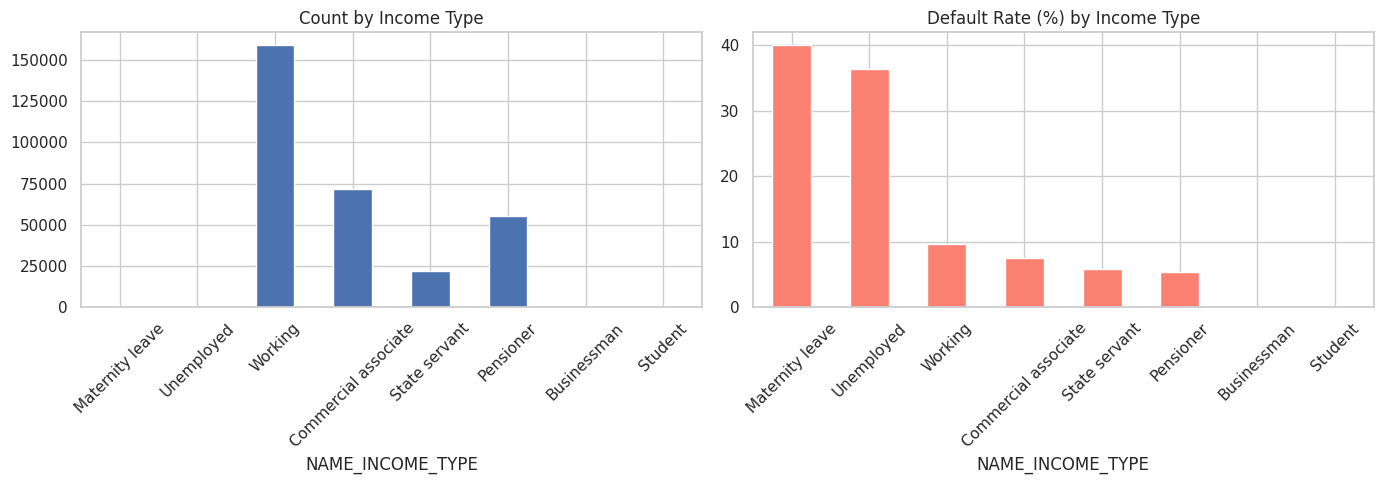

In [ ]:
# Employment-type analysis (paste after loading & cleaning df -> e.g., app_data_clean)
def employment_type_analysis(df, income_col='AMT_INCOME_TOTAL', age_col='AGE_YEARS', target_col='TARGET'):
    if 'NAME_INCOME_TYPE' not in df.columns:
        print("NAME_INCOME_TYPE not present")
        return
    e = df.groupby('NAME_INCOME_TYPE').agg({
        target_col: ['count','mean','sum'],
        income_col: 'median',
        age_col: 'median'
    }).round(3)
    e.columns = ['Count','Default_Rate','Default_Count','Median_Income','Median_Age']
    e['Default_Rate_pct'] = (e['Default_Rate']*100).round(2)
    e = e.sort_values('Default_Rate_pct', ascending=False)
    display(e)
    # Visualize
    fig, ax = plt.subplots(1,2, figsize=(14,5))
    e['Count'].plot(kind='bar', ax=ax[0], title='Count by Income Type')
    e['Default_Rate_pct'].plot(kind='bar', ax=ax[1], color='salmon', title='Default Rate (%) by Income Type')
    ax[0].tick_params(axis='x', rotation=45)
    ax[1].tick_params(axis='x', rotation=45)
    plt.tight_layout()
    plt.show()
    return e

# example usage:
employment_summary = employment_type_analysis(plot_df)


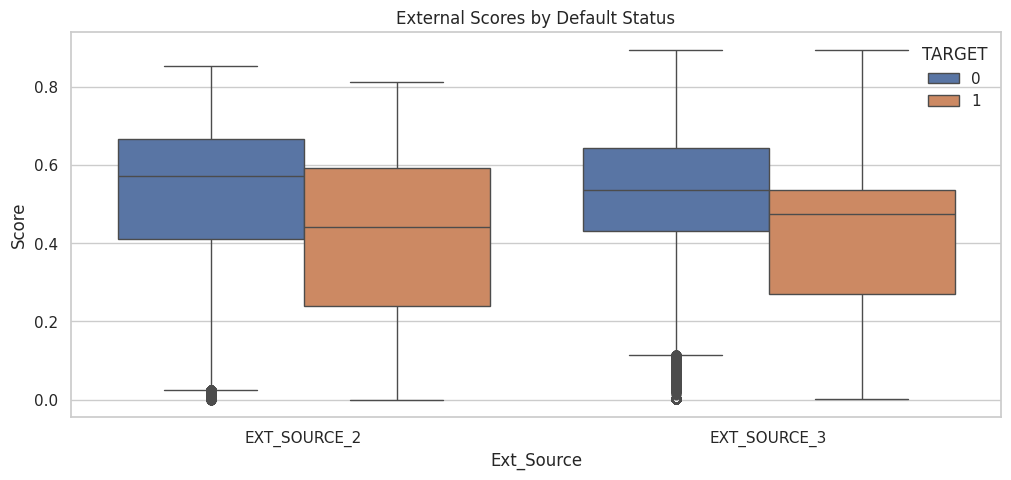

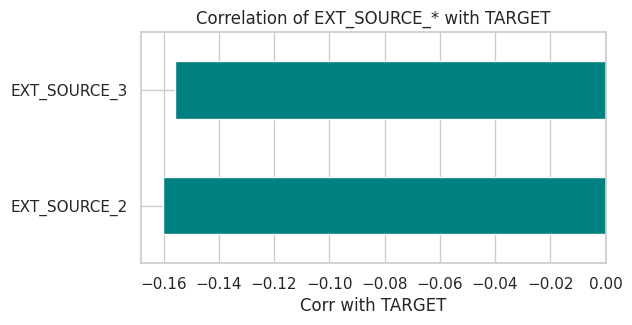

EXT_SOURCE_2   -0.160
EXT_SOURCE_3   -0.156
Name: TARGET, dtype: float64

In [ ]:
def external_score_analysis(df, ext_cols=['EXT_SOURCE_1','EXT_SOURCE_2','EXT_SOURCE_3'], target_col='TARGET'):
    existing = [c for c in ext_cols if c in df.columns]
    if not existing:
        print("No EXT_SOURCE_* columns found")
        return
    # melt for grouped boxplot with target hue
    ext_data = df[existing + [target_col]].melt(id_vars=target_col, value_vars=existing,
                                               var_name='Ext_Source', value_name='Score')
    plt.figure(figsize=(12,5))
    sns.boxplot(x='Ext_Source', y='Score', hue=target_col, data=ext_data)
    plt.title('External Scores by Default Status')
    plt.show()

    # correlation with target
    corr = df[existing + [target_col]].corr()[target_col].drop(target_col).sort_values()
    plt.figure(figsize=(6,3))
    corr.plot(kind='barh', color='teal')
    plt.title('Correlation of EXT_SOURCE_* with TARGET')
    plt.xlabel('Corr with TARGET')
    plt.axvline(0, color='black', linewidth=0.6)
    plt.show()
    display(corr)
    return corr

# example usage:
ext_corr = external_score_analysis(plot_df)


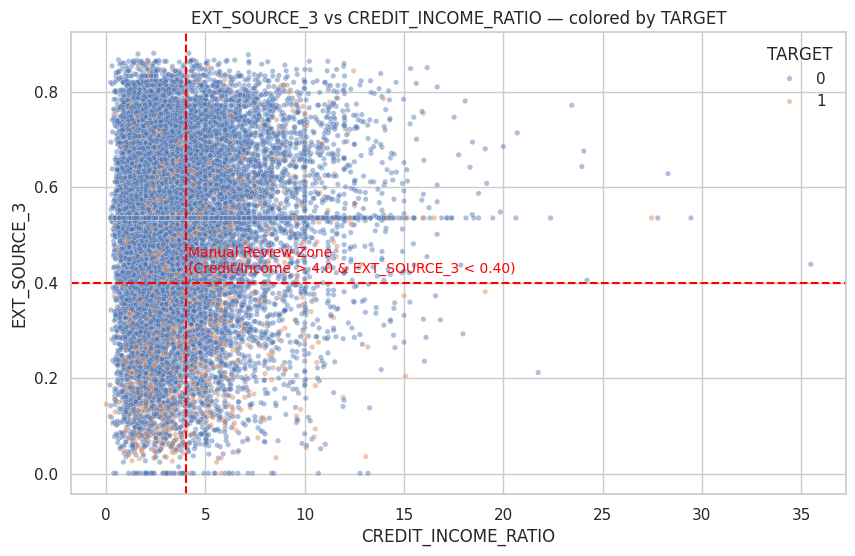

In [ ]:
def two_factor_risk_plot(df, x='CREDIT_INCOME_RATIO', y='EXT_SOURCE_3', target_col='TARGET', threshold_x=4.0, threshold_y=0.4, sample_n=20000):
    sample = df[[x,y,target_col]].dropna().sample(n=min(sample_n, len(df)), random_state=42)
    plt.figure(figsize=(10,6))
    sns.scatterplot(data=sample, x=x, y=y, hue=target_col, alpha=0.45, s=15)
    plt.title(f'{y} vs {x} — colored by TARGET')
    # annotate manual rule region
    plt.axvline(threshold_x, color='red', linestyle='--'); plt.axhline(threshold_y, color='red', linestyle='--')
    plt.text(threshold_x+0.1, threshold_y+0.02, "Manual Review Zone\n(Credit/Income > %.1f & %s < %.2f)"%(threshold_x, y, threshold_y),
             color='red', fontsize=10)
    plt.show()

# example usage:
two_factor_risk_plot(plot_df)


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[180]	valid_0's binary_logloss: 0.253572
Validation AUC: 0.7297


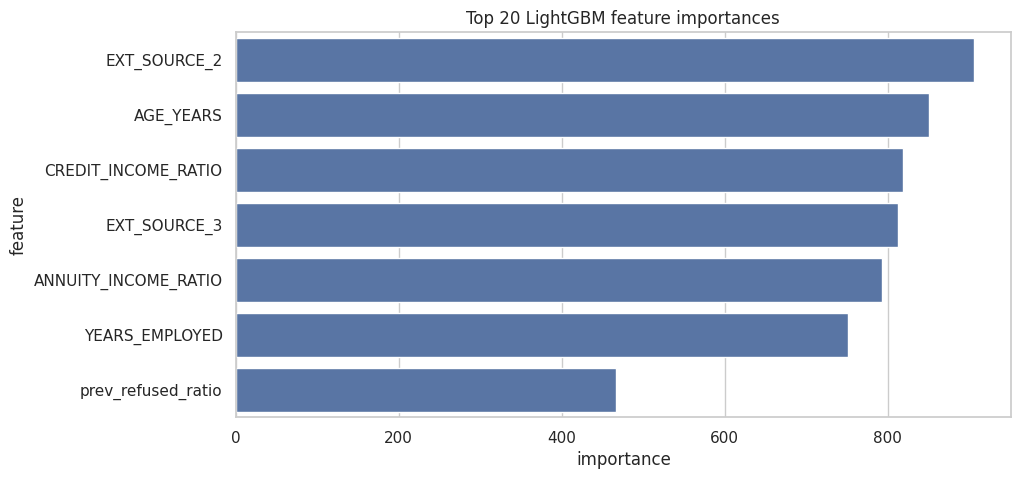

In [ ]:
from lightgbm import LGBMClassifier
from lightgbm import early_stopping, log_evaluation
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score

def quick_lgbm_feature_importance(X, y, features=None, test_size=0.2, random_state=42):
    if features is None:
        features = X.columns.tolist()
    X_train, X_val, y_train, y_val = train_test_split(X[features], y, test_size=test_size, stratify=y, random_state=random_state)
    model = LGBMClassifier(n_estimators=1000, learning_rate=0.05, random_state=random_state)
    model.fit(X_train, y_train, eval_set=[(X_val, y_val)],
              callbacks=[early_stopping(stopping_rounds=50), log_evaluation(0)])
    # AUC
    auc = roc_auc_score(y_val, model.predict_proba(X_val)[:,1])
    print("Validation AUC:", round(auc,4))
    # feature importance
    fi = pd.DataFrame({'feature': features, 'importance': model.feature_importances_}).sort_values('importance', ascending=False)
    plt.figure(figsize=(10,5))
    sns.barplot(data=fi.head(20), x='importance', y='feature')
    plt.title('Top 20 LightGBM feature importances')
    plt.show()
    return model, fi

# Usage example:
features_for_model = ['CREDIT_INCOME_RATIO','ANNUITY_INCOME_RATIO','AGE_YEARS','YEARS_EMPLOYED','EXT_SOURCE_2','EXT_SOURCE_3','prev_refused_ratio']
model, fi = quick_lgbm_feature_importance(plot_df, plot_df['TARGET'], features=features_for_model)


decile  count  mean  lift
0       0  30757 0.069 0.856
1       1  30770 0.078 0.961
2       2  30741 0.081 1.005
3       3  30773 0.090 1.117
4       4  30725 0.087 1.072
5       5  30741 0.092 1.139
6       6  30754 0.086 1.067
7       7  30751 0.080 0.985
8       8  30783 0.074 0.921
9       9  30716 0.071 0.876

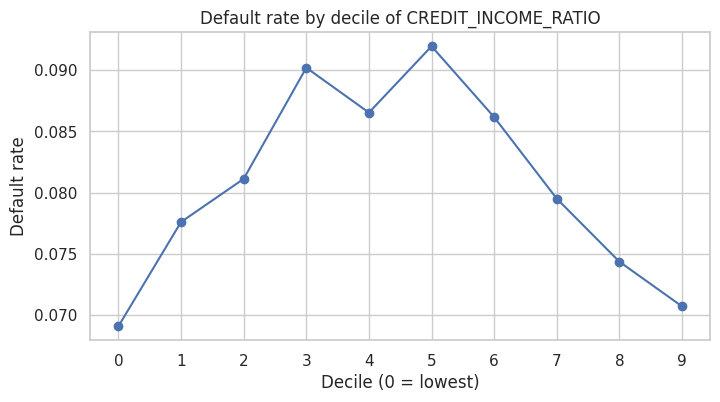

In [ ]:
# lift chart for CREDIT_INCOME_RATIO
col = 'CREDIT_INCOME_RATIO'
df = plot_df[[col,'TARGET']].dropna().copy()
df['decile'] = pd.qcut(df[col], 10, labels=False, duplicates='drop')
decile_summary = df.groupby('decile')['TARGET'].agg(['count','mean']).reset_index().sort_values('decile')
decile_summary['lift'] = decile_summary['mean'] / plot_df['TARGET'].mean()
display(decile_summary)

import matplotlib.pyplot as plt
plt.figure(figsize=(8,4))
plt.plot(decile_summary['decile'], decile_summary['mean'], marker='o')
plt.xticks(decile_summary['decile'])
plt.xlabel('Decile (0 = lowest)')
plt.ylabel('Default rate')
plt.title(f'Default rate by decile of {col}')
plt.grid(True)
plt.show()
